# Negative samples for the dataset

In [2]:
import pandas as pd
import numpy as np
import pydicom
import png
import math
from PIL import Image
from pathlib import Path
import boto3
import matplotlib.pyplot as plt

data_path = '/home/szelesteya/projects/EMBED_Open_Data/'
tables_path = data_path + 'tables/'
image_root_path = '/media/szelesteya/F824D4D024D492CC/EMBED-images/'
image_dcm_path = image_root_path + 'dicom-negative/'
image_png_path = image_root_path + 'negative'

In [2]:
cli_df = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv', low_memory=False)

# Only keeping result BIRADS-1 and BIRADS-2 screenings
neg_cli_df = cli_df[(cli_df.asses.isin(['N'])) & 
                    cli_df.desc.str.contains('screen', case=False)][['Unnamed: 0',
                                                                     'empi_anon',
                                                                     'acc_anon',
                                                                     'side',
                                                                     'calcfind',
                                                                     'calcdistri',
                                                                     'otherfind',
                                                                     'numfind',
                                                                     'path_severity',
                                                                     'age_at_study',
                                                                     'ETHNICITY_DESC',
                                                                     'study_date_anon',
                                                                     'asses']]

In [3]:
# Merging clinical information with medical ones
meta_df = (pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv', low_memory=False))
meta_red_df = meta_df[(meta_df['spot_mag'] != 1.0) &
                      (meta_df['FinalImageType'] == '2D')][['empi_anon',
                                                            'acc_anon',
                                                            'ImageLateralityFinal',
                                                            'anon_dicom_path',
                                                            'ROI_coords']]

# Rename columns to prepare for merge
meta_red_ren_df = meta_red_df.rename(columns={'ImageLateralityFinal':'side'})

In [4]:
neg_full_df = neg_cli_df.merge(meta_red_ren_df, on=['empi_anon','acc_anon','side'])

# Keeping relevant columns
neg_empi_df = neg_full_df[[ 'empi_anon',
                           'acc_anon',
                           'anon_dicom_path',
                           'side',
                           'asses',
                           'age_at_study',
                           'calcfind',
                           'calcdistri',
                           'otherfind',
                           'numfind',
                           'ROI_coords',
                           'ETHNICITY_DESC',
                           'study_date_anon']]

# Rename columns to be more consistent
neg_empi_df = neg_empi_df.rename(columns={'ETHNICITY_DESC':'eth_desc',
                                          'calcfind':'calc_find',
                                          'calcdistri':'calc_distrib',
                                          'otherfind':'other_find',
                                          'numfind':'num_find'})

# Generate paths for png extraction
neg_empi_df.loc[:, 'relative_dcm_path'] = neg_empi_df['anon_dicom_path'].apply(lambda x: '/'.join(x.split('/')[5:]))

In [5]:
# Ordering negative data by study date
neg_empi_ord_df = neg_empi_df.sort_values(by=['study_date_anon'], ascending=False)

# Choosing unique patients
neg_empi_fin_df = neg_empi_ord_df.drop_duplicates(subset=['empi_anon'], keep='first')[['empi_anon',
                                                                                       'acc_anon',
                                                                                       'side',
                                                                                       'asses',
                                                                                       'age_at_study',
                                                                                       'relative_dcm_path',
                                                                                       'calc_find',
                                                                                       'calc_distrib',
                                                                                       'other_find',
                                                                                       'num_find',
                                                                                       'ROI_coords',
                                                                                       'eth_desc',
                                                                                       'study_date_anon']]

In [6]:
neg_empi_fin_df

,empi_anon,acc_anon,side,asses,age_at_study,relative_dcm_path,calc_find,calc_distrib,other_find,num_find,ROI_coords,eth_desc,study_date_anon
2692,29011563,1572834723540517,R,N,82.651937,cohort_1/29011563/1.2.846.113979.3.61.1.622904...,NaN,NaN,NaN,1,(),African American or Black,2021-02-17
2627,11485524,6356263291812846,L,N,74.038481,cohort_1/11485524/1.2.844.113973.3.64.1.622065...,NaN,NaN,NaN,1,(),African American or Black,2021-02-10
5224,41042249,9346948292263998,R,N,67.763198,cohort_2/41042249/1.2.845.113978.3.60.1.621182...,NaN,NaN,NaN,1,(),Caucasian or White,2021-01-31
5328,12927057,6114291372605113,R,N,68.045203,cohort_2/12927057/1.2.841.113975.3.61.1.622750...,NaN,NaN,NaN,1,(),Caucasian or White,2021-01-24
2607,60191895,9641409346677793,R,N,62.073828,cohort_1/60191895/1.2.843.113978.3.64.1.621798...,NaN,NaN,NaN,1,(),African American or Black,2021-01-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,38150865,4128139548946126,R,N,58.886904,cohort_2/38150865/1.2.846.113979.3.57.1.476427...,NaN,NaN,NaN,1,(),"Unknown, Unavailable or Unreported",2012-10-18
260,67346874,2767166477579401,R,N,74.941991,cohort_1/67346874/1.2.848.113972.3.66.1.473688...,NaN,NaN,NaN,1,(),"Unknown, Unavailable or Unreported",2012-10-03
30,91807259,2219178450688890,R,N,50.224166,cohort_1/91807259/1.2.848.113972.3.66.1.473036...,NaN,NaN,NaN,1,(),African American or Black,2012-10-02
246,61908711,5543419799839526,L,N,46.892133,cohort_1/61908711/1.2.845.113975.3.61.1.473779...,NaN,NaN,NaN,1,(),African American or Black,2012-09-19


In [139]:
with open(data_path + 'negative_empirical.csv', 'w') as f:
    neg_empi_fin_df.to_csv(f, index=False)

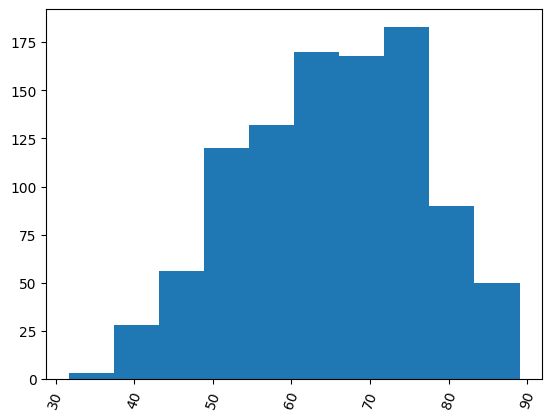

In [37]:
bins = plt.hist(neg_empi_fin_df['age_at_study'], bins=10)
plt.xticks(rotation=70)
plt.show()

In [7]:
with open(data_path + 'negative_path.csv', 'w') as f:
    neg_empi_fin_df['relative_dcm_path'].to_csv(f, index=False)

In [8]:
%%bash -s "$image_dcm_path" "{data_path}negative_path.csv"

# Pulling dicom files with AWS CLI (Python API didn't work)
dcm_dest_path="$1"
dcm_paths="$2"
ind=$((1))

tail -n +2 $dcm_paths | head -n 1000 | while IFS= read -r line; do
    relative_path=$(echo "$line" | awk -v OFS='/' '{$1=$1; print}')
    dcm_name=$(echo "$relative_path" | cut -d '/' -f 3-)
               
    file="${dcm_dest_path}$relative_path"
    dir=$(dirname $file)
    mkdir $dir -p
    echo "$ind / 1000"
    if [ -f "${dcm_dest_path}$dcm_name" ]; then
        echo "Moving file $file"
        mv "${dcm_dest_path}$dcm_name" "${dcm_dest_path}$relative_path"
        rmdir $dir -p
    else        
        if [ -f "$file" ]; then
            echo "File already present"
        else
            echo "Pulling file $file"
            aws s3 cp "s3://embed-dataset-open/images/$relative_path" "${dcm_dest_path}/$dcm_name" --profile my-dev-profile
        fi
    fi

    ind=$((ind+1))
    clear
done

1 / 1000
File already present
2 / 1000
File already present
3 / 1000
File already present
4 / 1000
File already present
5 / 1000
File already present
6 / 1000
File already present
7 / 1000
File already present
8 / 1000
File already present
9 / 1000
File already present
10 / 1000
File already present
11 / 1000
File already present
12 / 1000
File already present
13 / 1000
File already present
14 / 1000
File already present
15 / 1000
File already present
16 / 1000
File already present
17 / 1000
File already present
18 / 1000
File already present
19 / 1000
File already present
20 / 1000
File already present
21 / 1000
File already present
22 / 1000
File already present
23 / 1000
File already present
24 / 1000
File already present
25 / 1000
File already present
26 / 1000
File already present
27 / 1000
File already present
28 / 1000
File already present
29 / 1000
File already present
30 / 1000
File already present
31 / 1000
File already present
32 / 1000
File already present
33 / 1000
File al

rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20854918/1.2.846.113977.3.63.1.60883549.20191235.1082809/1.2.843.113685.2750824979.1577772173.4471.11603': Directory not empty


94 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67700949/1.2.841.113973.3.66.1.60324602.20191019.1122814/1.2.840.113688.2750824983.1570688043.2509.43103/1.2.826.0.1.3680043.8.498.53528753134974754863917364535963904815.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67700949/1.2.841.113973.3.66.1.60324602.20191019.1122814/1.2.840.113688.2750824983.1570688043.2509.43103': Directory not empty


95 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65957252/1.2.842.113971.3.57.1.60552468.20191113.1082022/1.2.847.113690.2750824973.1573539053.4081.20002/1.2.826.0.1.3680043.8.498.18438273713016500341710962805283241075.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65957252/1.2.842.113971.3.57.1.60552468.20191113.1082022/1.2.847.113690.2750824973.1573539053.4081.20002': Directory not empty


96 / 1000
File already present
97 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44107951/1.2.848.113979.3.64.1.60789939.20191217.1120008/1.2.844.113683.2750828053.1576476406.2020.344512/1.2.826.0.1.3680043.8.498.10884977605224699412909672304529674796.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44107951/1.2.848.113979.3.64.1.60789939.20191217.1120008/1.2.844.113683.2750828053.1576476406.2020.344512': Directory not empty


98 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18651693/1.2.844.113977.3.60.1.60620021.20191125.1081558/1.2.844.113685.2750824657.1574318156.5105.11876/1.2.826.0.1.3680043.8.498.12052133070684422943024617103704026999.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18651693/1.2.844.113977.3.60.1.60620021.20191125.1081558/1.2.844.113685.2750824657.1574318156.5105.11876': Directory not empty


99 / 1000
File already present
100 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61885738/1.2.840.113972.3.62.1.61096311.20200138.1090842/1.2.845.113681.2750824980.1580364120.5000.11677/1.2.826.0.1.3680043.8.498.95353093452340240647545669959828984008.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61885738/1.2.840.113972.3.62.1.61096311.20200138.1090842/1.2.845.113681.2750824980.1580364120.5000.11677': Directory not empty


101 / 1000
File already present
102 / 1000
File already present
103 / 1000
File already present
104 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56079691/1.2.844.113976.3.58.1.60950794.20200118.1140943/1.2.847.113687.2750851752.1578553280.4200.101775/1.2.826.0.1.3680043.8.498.41802358880179145469716825891488674114.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56079691/1.2.844.113976.3.58.1.60950794.20200118.1140943/1.2.847.113687.2750851752.1578553280.4200.101775': Directory not empty


105 / 1000
File already present
106 / 1000
File already present
107 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61568797/1.2.844.113976.3.64.1.60145817.20190923.1091857/1.2.841.113688.2750825165.1568616413.4985.19901/1.2.826.0.1.3680043.8.498.11181403296383851834592803952349083763.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61568797/1.2.844.113976.3.64.1.60145817.20190923.1091857/1.2.841.113688.2750825165.1568616413.4985.19901': Directory not empty


108 / 1000
File already present
109 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33814754/1.2.846.113971.3.59.1.60657632.20191132.1150636/1.2.845.113682.2750824498.1574750062.4413.279955/1.2.826.0.1.3680043.8.498.89684027505718776445995798469614390086.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33814754/1.2.846.113971.3.59.1.60657632.20191132.1150636/1.2.845.113682.2750824498.1574750062.4413.279955': Directory not empty


110 / 1000
File already present
111 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78518131/1.2.846.113971.3.58.1.62077516.20200730.1120807/1.2.842.113688.2750851779.1595920681.5028.58960/1.2.826.0.1.3680043.8.498.61296117444161615550898052090667642761.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78518131/1.2.846.113971.3.58.1.62077516.20200730.1120807/1.2.842.113688.2750851779.1595920681.5028.58960': Directory not empty


112 / 1000
File already present
113 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21791256/1.2.847.113973.3.57.1.61837447.20200626.1115647/1.2.845.113685.2750828065.1592460503.4152.3229/1.2.826.0.1.3680043.8.498.13433843863787677608967023578056113602.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21791256/1.2.847.113973.3.57.1.61837447.20200626.1115647/1.2.845.113685.2750828065.1592460503.4152.3229': Directory not empty


114 / 1000
File already present
115 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13628635/1.2.846.113978.3.65.1.60161800.20190922.1102563/1.2.847.113683.2750824981.1568787034.4549.23521/1.2.826.0.1.3680043.8.498.80164692347356001521605582275562944882.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13628635/1.2.846.113978.3.65.1.60161800.20190922.1102563/1.2.847.113683.2750824981.1568787034.4549.23521': Directory not empty


116 / 1000
File already present
117 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73637331/1.2.845.113970.3.65.1.62000061.20200723.1072959/1.2.845.113685.2750824546.1594882230.4906.2004/1.2.826.0.1.3680043.8.498.11930726962868091213076269172799084287.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73637331/1.2.845.113970.3.65.1.62000061.20200723.1072959/1.2.845.113685.2750824546.1594882230.4906.2004': Directory not empty


118 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95737636/1.2.845.113970.3.60.1.59929797.20190817.1132418/1.2.845.113686.2750824546.1565764305.4315.405587/1.2.826.0.1.3680043.8.498.61485011272700252464656020283999571715.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95737636/1.2.845.113970.3.60.1.59929797.20190817.1132418/1.2.845.113686.2750824546.1565764305.4315.405587': Directory not empty


119 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29864890/1.2.848.113975.3.65.1.60442666.20191037.1101034/1.2.843.113684.2750824981.1572244686.4100.32711/1.2.826.0.1.3680043.8.498.42396588623544222761444920284444859418.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29864890/1.2.848.113975.3.65.1.60442666.20191037.1101034/1.2.843.113684.2750824981.1572244686.4100.32711': Directory not empty


120 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79405064/1.2.845.113973.3.59.1.60606856.20191125.1124834/1.2.846.113687.2750825167.1574144156.4670.40879/1.2.826.0.1.3680043.8.498.40116175416255111472586085371843594032.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79405064/1.2.845.113973.3.59.1.60606856.20191125.1124834/1.2.846.113687.2750825167.1574144156.4670.40879': Directory not empty


121 / 1000
File already present
122 / 1000
File already present
123 / 1000
File already present
124 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81488045/1.2.844.113976.3.65.1.60236663.20190934.1101118/1.2.840.113686.2750824491.1569566098.4556.39980/1.2.826.0.1.3680043.8.498.22603200759828581861293359319899385094.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81488045/1.2.844.113976.3.65.1.60236663.20190934.1101118/1.2.840.113686.2750824491.1569566098.4556.39980': Directory not empty


125 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82244913/1.2.845.113972.3.66.1.60304016.20191016.1131362/1.2.843.113684.2750824499.1570516273.4774.384702/1.2.826.0.1.3680043.8.498.13376756955667463603175008040010867185.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82244913/1.2.845.113972.3.66.1.60304016.20191016.1131362/1.2.843.113684.2750824499.1570516273.4774.384702': Directory not empty


126 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63999340/1.2.843.113974.3.65.1.60714375.20191210.1123943/1.2.845.113681.2750824545.1575533334.4116.98590/1.2.826.0.1.3680043.8.498.64258504079874585671989949679287436443.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63999340/1.2.843.113974.3.65.1.60714375.20191210.1123943/1.2.845.113681.2750824545.1575533334.4116.98590': Directory not empty


127 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69166430/1.2.846.113976.3.65.1.60766082.20191217.1074030/1.2.844.113688.2750824483.1576218490.4668.10165/1.2.826.0.1.3680043.8.498.10688117948506694091942793233282789778.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69166430/1.2.846.113976.3.65.1.60766082.20191217.1074030/1.2.844.113688.2750824483.1576218490.4668.10165': Directory not empty


128 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53633964/1.2.848.113973.3.64.1.61788975.20200617.1094734/1.2.849.113682.2750824545.1591771556.4260.16500/1.2.826.0.1.3680043.8.498.12972539823699633843762287745151614906.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53633964/1.2.848.113973.3.64.1.61788975.20200617.1094734/1.2.849.113682.2750824545.1591771556.4260.16500': Directory not empty


129 / 1000
File already present
130 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/93138418/1.2.840.113979.3.58.1.60617367.20191125.1143539/1.2.847.113684.2750824981.1574230096.4421.44654/1.2.826.0.1.3680043.8.498.93151560145999428087768414254029436600.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/93138418/1.2.840.113979.3.58.1.60617367.20191125.1143539/1.2.847.113684.2750824981.1574230096.4421.44654': Directory not empty


131 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46129715/1.2.848.113977.3.63.1.60186333.20190920.1075363/1.2.848.113690.2750824972.1568960333.4152.10229/1.2.826.0.1.3680043.8.498.11917469734353980876300638161301046555.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46129715/1.2.848.113977.3.63.1.60186333.20190920.1075363/1.2.848.113690.2750824972.1568960333.4152.10229': Directory not empty


132 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/73135040/1.2.846.113970.3.58.1.60035343.20190831.1100955/1.2.841.113682.2750824983.1567058866.4875.34399/1.2.826.0.1.3680043.8.498.56352705040450914464872997373799086421.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/73135040/1.2.846.113970.3.58.1.60035343.20190831.1100955/1.2.841.113682.2750824983.1567058866.4875.34399': Directory not empty


133 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56854951/1.2.847.113979.3.59.1.60656899.20191127.1114218/1.2.847.113684.2750828053.1574748119.2995.450692/1.2.826.0.1.3680043.8.498.78897211853840822873238305363403110371.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56854951/1.2.847.113979.3.59.1.60656899.20191127.1114218/1.2.847.113684.2750828053.1574748119.2995.450692': Directory not empty


134 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81396614/1.2.845.113975.3.62.1.61123504.20200207.1145205/1.2.847.113688.2750825165.1580711000.4362.76996/1.2.826.0.1.3680043.8.498.11794970263547236229798353376560732409.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81396614/1.2.845.113975.3.62.1.61123504.20200207.1145205/1.2.847.113688.2750825165.1580711000.4362.76996': Directory not empty


135 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/79459134/1.2.846.113975.3.63.1.59820895.20190737.1110058/1.2.845.113685.2750824981.1564380413.4217.28461/1.2.826.0.1.3680043.8.498.61362951887355462146235244154941874593.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/79459134/1.2.846.113975.3.63.1.59820895.20190737.1110058/1.2.845.113685.2750824981.1564380413.4217.28461': Directory not empty


136 / 1000
File already present
137 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92928907/1.2.840.113976.3.66.1.61283040.20200234.1094051/1.2.849.113688.2750824507.1582625764.3950.26850/1.2.826.0.1.3680043.8.498.10284649657900769525599002911492698789.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92928907/1.2.840.113976.3.66.1.61283040.20200234.1094051/1.2.849.113688.2750824507.1582625764.3950.26850': Directory not empty


138 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55529729/1.2.844.113974.3.61.1.60417787.20191029.1121143/1.2.848.113686.2750824545.1571898621.4811.224834/1.2.826.0.1.3680043.8.498.25330340295350319946253862621866354722.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55529729/1.2.844.113974.3.61.1.60417787.20191029.1121143/1.2.848.113686.2750824545.1571898621.4811.224834': Directory not empty


139 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85605726/1.2.845.113973.3.57.1.59850919.20190804.1075032/1.2.842.113690.2750851775.1564730808.4268.35720/1.2.826.0.1.3680043.8.498.93917998387080519142135354212285222575.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85605726/1.2.845.113973.3.57.1.59850919.20190804.1075032/1.2.842.113690.2750851775.1564730808.4268.35720': Directory not empty


140 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46855193/1.2.841.113970.3.61.1.61414378.20200322.1145125/1.2.846.113689.2750851773.1584082845.4129.282618/1.2.826.0.1.3680043.8.498.53766403746822024191917817824264269036.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46855193/1.2.841.113970.3.61.1.61414378.20200322.1145125/1.2.846.113689.2750851773.1584082845.4129.282618': Directory not empty


141 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/97318478/1.2.844.113973.3.58.1.61023946.20200126.1102261/1.2.849.113690.2750824551.1579598730.4877.35929/1.2.826.0.1.3680043.8.498.67477576376519692545179930686421919998.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/97318478/1.2.844.113973.3.58.1.61023946.20200126.1102261/1.2.849.113690.2750824551.1579598730.4877.35929': Directory not empty


142 / 1000
File already present
143 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85807551/1.2.840.113688.2750824981.1570107286.3480.19704/1.2.847.113682.2750824981.1570107283.3481.19708/1.2.826.0.1.3680043.8.498.10648178784553335827229932903730289331.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85807551/1.2.840.113688.2750824981.1570107286.3480.19704/1.2.847.113682.2750824981.1570107283.3481.19708': Directory not empty


144 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68257398/1.2.846.113975.3.64.1.59939284.20190821.1104803/1.2.846.113684.2750824545.1565850523.4519.202031/1.2.826.0.1.3680043.8.498.97504965921554493813818231706565754721.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68257398/1.2.846.113975.3.64.1.59939284.20190821.1104803/1.2.846.113684.2750824545.1565850523.4519.202031': Directory not empty


145 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19827985/1.2.845.113970.3.63.1.61397999.20200320.1081327/1.2.844.113689.2750824505.1583994738.4608.52234/1.2.826.0.1.3680043.8.498.39145434645534016596161613458690200860.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19827985/1.2.845.113970.3.63.1.61397999.20200320.1081327/1.2.844.113689.2750824505.1583994738.4608.52234': Directory not empty


146 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50042795/1.2.843.113977.3.64.1.59741415.20190725.1101356/1.2.849.113682.2750824550.1563344994.4266.107483/1.2.826.0.1.3680043.8.498.96452386851230992968213790941455002050.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50042795/1.2.843.113977.3.64.1.59741415.20190725.1101356/1.2.849.113682.2750824550.1563344994.4266.107483': Directory not empty


147 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39454374/1.2.848.113979.3.65.1.60207791.20190928.1092761/1.2.848.113685.2750828050.1569306137.4140.302970/1.2.826.0.1.3680043.8.498.91939724530759279632138383727742809127.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39454374/1.2.848.113979.3.65.1.60207791.20190928.1092761/1.2.848.113685.2750828050.1569306137.4140.302970': Directory not empty


148 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53045681/1.2.849.113972.3.57.1.59666060.20190706.1102955/1.2.841.113683.2130706441.1562308352.4291.83298/1.2.826.0.1.3680043.8.498.10515436005668022903391544841294493195.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53045681/1.2.849.113972.3.57.1.59666060.20190706.1102955/1.2.841.113683.2130706441.1562308352.4291.83298': Directory not empty


149 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89054868/1.2.847.113975.3.64.1.59612467.20190633.1095615/1.2.845.113686.2750824542.1561531254.4581.25522/1.2.826.0.1.3680043.8.498.11138863400494025563592674448738100322.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89054868/1.2.847.113975.3.64.1.59612467.20190633.1095615/1.2.845.113686.2750824542.1561531254.4581.25522': Directory not empty


150 / 1000
File already present
151 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39140705/1.2.847.113972.3.61.1.61129127.20200207.1093658/1.2.840.113690.2750824659.1580797952.2451.309845/1.2.826.0.1.3680043.8.498.55037148904676559820271684881454888475.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39140705/1.2.847.113972.3.61.1.61129127.20200207.1093658/1.2.840.113690.2750824659.1580797952.2451.309845': Directory not empty


152 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82827336/1.2.844.113978.3.58.1.61006604.20200118.1094355/1.2.841.113683.2750824548.1579242930.5082.53454/1.2.826.0.1.3680043.8.498.66271984485393233226487355360107094149.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82827336/1.2.844.113978.3.58.1.61006604.20200118.1094355/1.2.841.113683.2750824548.1579242930.5082.53454': Directory not empty


153 / 1000
File already present
154 / 1000
File already present
155 / 1000
File already present
156 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60006517/1.2.845.113971.3.58.1.60787975.20191225.1135444/1.2.841.113689.2750824545.1576477898.3955.221780/1.2.826.0.1.3680043.8.498.38679146927008515321245029583702919043.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60006517/1.2.845.113971.3.58.1.60787975.20191225.1135444/1.2.841.113689.2750824545.1576477898.3955.221780': Directory not empty


157 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/40928337/1.2.849.113977.3.61.1.61190468.20200212.1080808/1.2.841.113686.2750824501.1581489275.4492.82552/1.2.826.0.1.3680043.8.498.89558623448670183670407048885090229436.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/40928337/1.2.849.113977.3.61.1.61190468.20200212.1080808/1.2.841.113686.2750824501.1581489275.4492.82552': Directory not empty


158 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80614078/1.2.844.113971.3.58.1.59974036.20190828.1072963/1.2.848.113682.2750828064.1566367310.4998.61366/1.2.826.0.1.3680043.8.498.11276618129437025210982350793805440046.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80614078/1.2.844.113971.3.58.1.59974036.20190828.1072963/1.2.848.113682.2750828064.1566367310.4998.61366': Directory not empty


159 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75018535/1.2.845.113978.3.58.1.60202470.20190924.1092215/1.2.847.113682.2750824502.1569220284.4149.128399/1.2.826.0.1.3680043.8.498.66621953739977881077643994790838866388.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75018535/1.2.845.113978.3.58.1.60202470.20190924.1092215/1.2.847.113682.2750824502.1569220284.4149.128399': Directory not empty


160 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93538892/1.2.847.113977.3.66.1.61150195.20200208.1134160/1.2.841.113689.2750824979.1580968280.5020.34929/1.2.826.0.1.3680043.8.498.19833721245482750440183111198297969312.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93538892/1.2.847.113977.3.66.1.61150195.20200208.1134160/1.2.841.113689.2750824979.1580968280.5020.34929': Directory not empty


161 / 1000
File already present
162 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96072010/1.2.849.113974.3.65.1.61085701.20200138.1104231/1.2.841.113690.2750824491.1580279690.2722.38784/1.2.826.0.1.3680043.8.498.60228860878920979303384708313794194135.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96072010/1.2.849.113974.3.65.1.61085701.20200138.1104231/1.2.841.113690.2750824491.1580279690.2722.38784': Directory not empty


163 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18245824/1.2.847.113979.3.59.1.61211173.20200218.1120717/1.2.843.113688.2750851779.1581663674.4506.64195/1.2.826.0.1.3680043.8.498.13260418990467566391998061688053967702.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18245824/1.2.847.113979.3.59.1.61211173.20200218.1120717/1.2.843.113688.2750851779.1581663674.4506.64195': Directory not empty


164 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11762574/1.2.842.113978.3.59.1.61295419.20200228.1075008/1.2.841.113687.2750824975.1582783402.3880.7998/1.2.826.0.1.3680043.8.498.13010130061192641296865917244374799838.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11762574/1.2.842.113978.3.59.1.61295419.20200228.1075008/1.2.841.113687.2750824975.1582783402.3880.7998': Directory not empty


165 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54238865/1.2.848.113973.3.62.1.59411905.20190530.1/1.2.840.113683.2750824662.1559025300.4668.22596/1.2.826.0.1.3680043.8.498.18739077877815307887594827790674388904.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54238865/1.2.848.113973.3.62.1.59411905.20190530.1/1.2.840.113683.2750824662.1559025300.4668.22596': Directory not empty


166 / 1000
File already present
167 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25403261/1.2.843.113976.3.65.1.59772146.20190731.1130816/1.2.844.113689.2750824498.1563776346.5053.162340/1.2.826.0.1.3680043.8.498.12313005630616009792806618779601297015.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25403261/1.2.843.113976.3.65.1.59772146.20190731.1130816/1.2.844.113689.2750824498.1563776346.5053.162340': Directory not empty


168 / 1000
File already present
169 / 1000
File already present
170 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56073514/1.2.844.113976.3.65.1.60945533.20200117.1101158/1.2.844.113621.2.404.1196017357155222.13960200109104056.10017/1.2.826.0.1.3680043.8.498.95521605869577942422470546619738461965.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56073514/1.2.844.113976.3.65.1.60945533.20200117.1101158/1.2.844.113621.2.404.1196017357155222.13960200109104056.10017': Directory not empty


171 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/34504175/1.2.844.113975.3.60.1.59752594.20190721.1105126/1.2.843.113684.2750825164.1563429871.860.32247/1.2.826.0.1.3680043.8.498.64897966019002149945354667617813063491.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/34504175/1.2.844.113975.3.60.1.59752594.20190721.1105126/1.2.843.113684.2750825164.1563429871.860.32247': Directory not empty


172 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86771122/1.2.845.113978.3.64.1.60606309.20191127.1104945/1.2.847.113685.2750824550.1574145033.4490.123773/1.2.826.0.1.3680043.8.498.94976876196234112891153475534255374945.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86771122/1.2.845.113978.3.64.1.60606309.20191127.1104945/1.2.847.113685.2750824550.1574145033.4490.123773': Directory not empty


173 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74691979/1.2.840.113977.3.65.1.59749343.20190720.1/1.2.840.113687.2750825169.1563429874.862.5263/1.2.826.0.1.3680043.8.498.59207862822552645891713289284071511926.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74691979/1.2.840.113977.3.65.1.59749343.20190720.1/1.2.840.113687.2750825169.1563429874.862.5263': Directory not empty


174 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21726342/1.2.843.113977.3.59.1.59236891.20190507.1093039/1.2.849.113690.2750824975.1556690771.5244.24894/1.2.826.0.1.3680043.8.498.22227624780836382671971483126966171954.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21726342/1.2.843.113977.3.59.1.59236891.20190507.1093039/1.2.849.113690.2750824975.1556690771.5244.24894': Directory not empty


175 / 1000
File already present
176 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65562761/1.2.840.113978.3.66.1.61071493.20200132.1135226/1.2.842.113690.2750824658.1580106758.4814.622855/1.2.826.0.1.3680043.8.498.50474902791526022712867233035788094832.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65562761/1.2.840.113978.3.66.1.61071493.20200132.1135226/1.2.842.113690.2750824658.1580106758.4814.622855': Directory not empty


177 / 1000
File already present
178 / 1000
File already present
179 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16300326/1.2.848.113976.3.66.1.59784366.20190728.1113803/1.2.842.113684.2750824983.1563861972.5184.27628/1.2.826.0.1.3680043.8.498.10990041121045433724232538212539755772.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16300326/1.2.848.113976.3.66.1.59784366.20190728.1113803/1.2.842.113684.2750824983.1563861972.5184.27628': Directory not empty


180 / 1000
File already present
181 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96208962/1.2.845.113970.3.58.1.59913702.20190819.1121111/1.2.842.113689.2750828067.1565589467.5029.32194/1.2.826.0.1.3680043.8.498.10311078971813543459438559403185018524.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96208962/1.2.845.113970.3.58.1.59913702.20190819.1121111/1.2.842.113689.2750828067.1565589467.5029.32194': Directory not empty


182 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72718275/1.2.845.113971.3.60.1.59616249.20190634.1090136/1.2.840.113690.2750824500.1561617313.4625.69257/1.2.826.0.1.3680043.8.498.86428057219226006556663796544119517798.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72718275/1.2.845.113971.3.60.1.59616249.20190634.1090136/1.2.840.113690.2750824500.1561617313.4625.69257': Directory not empty


183 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42698944/1.2.848.113975.3.58.1.60667329.20191129.1144622/1.2.847.113682.2750824503.1574836131.4340.267102/1.2.826.0.1.3680043.8.498.53765876971927689107605358154823690691.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42698944/1.2.848.113975.3.58.1.60667329.20191129.1144622/1.2.847.113682.2750824503.1574836131.4340.267102': Directory not empty


184 / 1000
File already present
185 / 1000
File already present
186 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65483379/1.2.843.113973.3.61.1.59802810.20190732.1151223/1.2.841.113684.2750825172.1564034853.4777.46929/1.2.826.0.1.3680043.8.498.60719330335431580224587493734856000871.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65483379/1.2.843.113973.3.61.1.59802810.20190732.1151223/1.2.841.113684.2750825172.1564034853.4777.46929': Directory not empty


187 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61937020/1.2.846.113977.3.65.1.60898816.20200108.1132233/1.2.842.113688.2750851776.1577948455.4359.78533/1.2.826.0.1.3680043.8.498.10760582967025134074216444556143598167.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61937020/1.2.846.113977.3.65.1.60898816.20200108.1132233/1.2.842.113688.2750851776.1577948455.4359.78533': Directory not empty


188 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29464326/1.2.849.113975.3.57.1.60601860.20191126.1093606/1.2.848.113690.2750824503.1574145045.4652.93066/1.2.826.0.1.3680043.8.498.10170243093409812324553794329592211082.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29464326/1.2.849.113975.3.57.1.60601860.20191126.1093606/1.2.848.113690.2750824503.1574145045.4652.93066': Directory not empty


189 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83993418/1.2.845.113970.3.66.1.60615978.20191130.1103323/1.2.848.113686.2750824973.1574316549.4245.34271/1.2.826.0.1.3680043.8.498.40959924172300718244301612274218283418.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83993418/1.2.845.113970.3.66.1.60615978.20191130.1103323/1.2.848.113686.2750824973.1574316549.4245.34271': Directory not empty


190 / 1000
File already present
191 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60635465/1.2.848.113977.3.66.1.60984497.20200116.1154344/1.2.847.113686.2750824498.1578983976.4480.257677/1.2.826.0.1.3680043.8.498.11193670937511524300743723522966092678.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60635465/1.2.848.113977.3.66.1.60984497.20200116.1154344/1.2.847.113686.2750824498.1578983976.4480.257677': Directory not empty


192 / 1000
File already present
193 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29790363/1.2.849.113970.3.65.1.60588064.20191118.1071251/1.2.844.113686.2750828050.1574059421.2777.68044/1.2.826.0.1.3680043.8.498.57487548033539076097174379754804320930.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29790363/1.2.849.113970.3.65.1.60588064.20191118.1071251/1.2.844.113686.2750828050.1574059421.2777.68044': Directory not empty


194 / 1000
File already present
195 / 1000
File already present
196 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38980188/1.2.842.113973.3.63.1.58986840.20190327.1124543/1.2.847.113689.2750824504.1553495385.4247.41617/1.2.826.0.1.3680043.8.498.99702444538319408646369595105210936196.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38980188/1.2.842.113973.3.63.1.58986840.20190327.1124543/1.2.847.113689.2750824504.1553495385.4247.41617': Directory not empty


197 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/63578719/1.2.840.113978.3.65.1.61201560.20200220.1124536/1.2.849.113681.2750824984.1581573472.4984.38482/1.2.826.0.1.3680043.8.498.78222309273258643561235676145277925370.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/63578719/1.2.840.113978.3.65.1.61201560.20200220.1124536/1.2.849.113681.2750824984.1581573472.4984.38482': Directory not empty


198 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29417201/1.2.848.113974.3.61.1.60977923.20200122.1093565/1.2.845.113689.2750824973.1578981240.4406.17257/1.2.826.0.1.3680043.8.498.12540982576396300034393255819099003356.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29417201/1.2.848.113974.3.61.1.60977923.20200122.1093565/1.2.845.113689.2750824973.1578981240.4406.17257': Directory not empty


199 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39782227/1.2.528.1.1010.101.2.6947.6948.1.20190510150019295/1.2.532.1.1009.109.3.6944.6952.1.20190510150019299/1.2.826.0.1.3680043.8.498.67374091871962381906426051557495738008.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39782227/1.2.528.1.1010.101.2.6947.6948.1.20190510150019295/1.2.532.1.1009.109.3.6944.6952.1.20190510150019299': Directory not empty


200 / 1000
File already present
201 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87687324/1.2.845.113972.3.65.1.59752979.20190718.1121710/1.2.840.113686.2750824499.1563431490.4601.141612/1.2.826.0.1.3680043.8.498.63526665736625308362068790600854117934.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87687324/1.2.845.113972.3.65.1.59752979.20190718.1121710/1.2.840.113686.2750824499.1563431490.4601.141612': Directory not empty


202 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55584653/1.2.847.113972.3.61.1.61138560.20200210.1080642/1.2.843.113686.2750824978.1580882402.4729.6217/1.2.826.0.1.3680043.8.498.11849628938795314599542394591962752751.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55584653/1.2.847.113972.3.61.1.61138560.20200210.1080642/1.2.843.113686.2750824978.1580882402.4729.6217': Directory not empty


203 / 1000
File already present
204 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80701580/1.2.848.113977.3.60.1.59219717.20190438.1095045/1.2.844.113684.2750824543.1556519400.4250.22716/1.2.826.0.1.3680043.8.498.86643311157935417179108233229872800536.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80701580/1.2.848.113977.3.60.1.59219717.20190438.1095045/1.2.844.113684.2750824543.1556519400.4250.22716': Directory not empty


205 / 1000
File already present
206 / 1000
File already present
207 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13389063/1.2.846.113978.3.58.1.61119292.20200208.1092458/1.2.840.113686.2750824485.1580711684.5101.27788/1.2.826.0.1.3680043.8.498.40059313887001460121152059720852335946.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13389063/1.2.846.113978.3.58.1.61119292.20200208.1092458/1.2.840.113686.2750824485.1580711684.5101.27788': Directory not empty


208 / 1000
File already present
209 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33584218/1.2.849.113972.3.65.1.59202752.20190428.1152137/1.2.841.113690.2750824500.1556173867.4392.88677/1.2.826.0.1.3680043.8.498.62982881134691526845864509531060208591.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33584218/1.2.849.113972.3.65.1.59202752.20190428.1152137/1.2.841.113690.2750824500.1556173867.4392.88677': Directory not empty


210 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93341277/1.2.844.113973.3.59.1.58904769.20190314.1082205/1.2.842.113688.2750824542.1552458945.4031.133841/1.2.826.0.1.3680043.8.498.13390798002929791774239040394762580746.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93341277/1.2.844.113973.3.59.1.58904769.20190314.1082205/1.2.842.113688.2750824542.1552458945.4031.133841': Directory not empty


211 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96676670/1.2.848.113978.3.59.1.59564663.20190626.1092752/1.2.848.113689.2750828070.1560924654.5121.260925/1.2.826.0.1.3680043.8.498.91971014395923398995022714077759784289.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96676670/1.2.848.113978.3.59.1.59564663.20190626.1092752/1.2.848.113689.2750828070.1560924654.5121.260925': Directory not empty


212 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45849073/1.2.847.113974.3.59.1.60284640.20191008.1141116/1.2.840.113684.2750825167.1570113524.4479.67129/1.2.826.0.1.3680043.8.498.33895504211667470045612195755273097030.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45849073/1.2.847.113974.3.59.1.60284640.20191008.1141116/1.2.840.113684.2750825167.1570113524.4479.67129': Directory not empty


213 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/58661718/1.2.846.113973.3.65.1.60574408.20191120.1125845/1.2.847.113687.2750828067.1573711401.5077.55609/1.2.826.0.1.3680043.8.498.64502437100581107128095417108242944880.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/58661718/1.2.846.113973.3.65.1.60574408.20191120.1125845/1.2.847.113687.2750828067.1573711401.5077.55609': Directory not empty


214 / 1000
File already present
215 / 1000
File already present
216 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/22311779/1.2.845.113973.3.66.1.59372864.20190522.1120203/1.2.849.113686.2750824976.1558418596.3428.27244/1.2.826.0.1.3680043.8.498.75859924011326788630446291619685819237.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/22311779/1.2.845.113973.3.66.1.59372864.20190522.1120203/1.2.849.113686.2750824976.1558418596.3428.27244': Directory not empty


217 / 1000
File already present
218 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41737961/1.2.844.113975.3.58.1.60809936.20191222.1143446/1.2.848.113686.2750824551.1576651154.4731.343260/1.2.826.0.1.3680043.8.498.12738048637296320766234113899880848199.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41737961/1.2.844.113975.3.58.1.60809936.20191222.1143446/1.2.848.113686.2750824551.1576651154.4731.343260': Directory not empty


219 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51434544/1.2.840.113978.3.61.1.60910869.20200111.1111509/1.2.841.113681.2750828055.1578120237.5065.175684/1.2.826.0.1.3680043.8.498.62178269770464144626359525532181842484.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51434544/1.2.840.113978.3.61.1.60910869.20200111.1111509/1.2.841.113681.2750828055.1578120237.5065.175684': Directory not empty


220 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51445821/1.2.844.113978.3.60.1.61096592.20200139.1095738/1.2.847.113683.2750851748.1580366706.3556.37627/1.2.826.0.1.3680043.8.498.94267930027362096376859261457176802293.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51445821/1.2.844.113978.3.60.1.61096592.20200139.1095738/1.2.847.113683.2750851748.1580366706.3556.37627': Directory not empty


221 / 1000
File already present
222 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13139891/1.2.841.113971.3.60.1.60202824.20190930.1102160/1.2.844.113683.2750824979.1569220147.4504.44028/1.2.826.0.1.3680043.8.498.54536872907126365159612314228850661595.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13139891/1.2.841.113971.3.60.1.60202824.20190930.1102160/1.2.844.113683.2750824979.1569220147.4504.44028': Directory not empty


223 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54140758/1.2.844.113979.3.62.1.58783353.20190230.1114416/1.2.848.113690.2750825173.1550815711.4890.59176/1.2.826.0.1.3680043.8.498.21556691675227207412229787873811428996.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54140758/1.2.844.113979.3.62.1.58783353.20190230.1114416/1.2.848.113690.2750825173.1550815711.4890.59176': Directory not empty


224 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/97048766/1.2.847.113972.3.58.1.59571352.20190625.1084658/1.2.844.113684.2750851776.1561014064.4507.19026/1.2.826.0.1.3680043.8.498.14064792386659211106547097204983417991.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/97048766/1.2.847.113972.3.58.1.59571352.20190625.1084658/1.2.844.113684.2750851776.1561014064.4507.19026': Directory not empty


225 / 1000
File already present
226 / 1000
File already present
227 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65629417/1.2.847.113973.3.66.1.59574436.20190628.1/1.2.847.113682.2750824503.1561012167.4381.92287/1.2.826.0.1.3680043.8.498.87342930125195138464274398612186486310.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65629417/1.2.847.113973.3.66.1.59574436.20190628.1/1.2.847.113682.2750824503.1561012167.4381.92287': Directory not empty


228 / 1000
File already present
229 / 1000
File already present
230 / 1000
File already present
231 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79566675/1.2.849.113972.3.61.1.60542785.20191118.1084030/1.2.841.113684.2750824550.1573453950.4613.108938/1.2.826.0.1.3680043.8.498.11540034143089974145980076508507310390.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79566675/1.2.849.113972.3.61.1.60542785.20191118.1084030/1.2.841.113684.2750824550.1573453950.4613.108938': Directory not empty


232 / 1000
File already present
233 / 1000
File already present
234 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60282216/1.2.846.113976.3.64.1.60124427.20190920.1095638/1.2.841.113689.2750824501.1568269775.4755.133966/1.2.826.0.1.3680043.8.498.24438680246737086546319898950260798375.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60282216/1.2.846.113976.3.64.1.60124427.20190920.1095638/1.2.841.113689.2750824501.1568269775.4755.133966': Directory not empty


235 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15108650/1.2.843.113979.3.65.1.60917342.20200111.1084836/1.2.849.113684.2750824979.1578290870.4118.11961/1.2.826.0.1.3680043.8.498.55493891995052580440636378731900200243.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15108650/1.2.843.113979.3.65.1.60917342.20200111.1084836/1.2.849.113684.2750824979.1578290870.4118.11961': Directory not empty


236 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18807994/1.2.848.113979.3.64.1.60323054.20191014.1120304/1.2.841.113689.2750824656.1570686970.4496.37248/1.2.826.0.1.3680043.8.498.98786083310663164973521373283896838425.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18807994/1.2.848.113979.3.64.1.60323054.20191014.1120304/1.2.841.113689.2750824656.1570686970.4496.37248': Directory not empty


237 / 1000
File already present
238 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/72804936/1.2.844.113975.3.65.1.59935803.20190820.1123410/1.2.845.113686.2750824544.1565850520.4515.282518/1.2.826.0.1.3680043.8.498.37670866844180733664213324607772632861.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/72804936/1.2.844.113975.3.65.1.59935803.20190820.1123410/1.2.845.113686.2750824544.1565850520.4515.282518': Directory not empty


239 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21750107/1.2.845.113970.3.62.1.60885950.20191232.1141909/1.2.844.113681.2750824550.1577772002.4815.217276/1.2.826.0.1.3680043.8.498.11020068443521037919777634687330574621.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21750107/1.2.845.113970.3.62.1.60885950.20191232.1141909/1.2.844.113681.2750824550.1577772002.4815.217276': Directory not empty


240 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25394351/1.2.847.113972.3.64.1.59120193.20190421.1/1.2.848.113686.2750828053.1555311049.4115.3800/1.2.826.0.1.3680043.8.498.92750206426192592244067855787357369425.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25394351/1.2.847.113972.3.64.1.59120193.20190421.1/1.2.848.113686.2750828053.1555311049.4115.3800': Directory not empty


241 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64698570/1.2.843.113979.3.60.1.59174495.20190428.1105532/1.2.849.113685.2750824489.1555915232.4985.391822/1.2.826.0.1.3680043.8.498.90255541952870571398198824805904926290.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64698570/1.2.843.113979.3.60.1.59174495.20190428.1105532/1.2.849.113685.2750824489.1555915232.4985.391822': Directory not empty


242 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30082839/1.2.841.113974.3.57.1.60324243.20191015.1173835/1.2.844.113687.2750851781.1570690155.4257.339976/1.2.826.0.1.3680043.8.498.10391057462017138397929523694541446106.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30082839/1.2.841.113974.3.57.1.60324243.20191015.1173835/1.2.844.113687.2750851781.1570690155.4257.339976': Directory not empty


243 / 1000
File already present
244 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37806726/1.2.840.113976.3.65.1.60005736.20190833.1102240/1.2.843.113683.2750824976.1566801388.4795.28586/1.2.826.0.1.3680043.8.498.49461238649919912786184390158299966021.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37806726/1.2.840.113976.3.65.1.60005736.20190833.1102240/1.2.843.113683.2750824976.1566801388.4795.28586': Directory not empty


245 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52854172/1.2.847.113978.3.60.1.59199691.20190431.1101360/1.2.841.113683.2750824980.1556172154.5184.38135/1.2.826.0.1.3680043.8.498.11159300854448808139748730230678051440.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52854172/1.2.847.113978.3.60.1.59199691.20190431.1101360/1.2.841.113683.2750824980.1556172154.5184.38135': Directory not empty


246 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70123358/1.2.840.113978.3.61.1.59961064.20190820.1123016/1.2.849.113684.2750824549.1566196147.4684.114108/1.2.826.0.1.3680043.8.498.11204354177789880355273823858681815673.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70123358/1.2.840.113978.3.61.1.59961064.20190820.1123016/1.2.849.113684.2750824549.1566196147.4684.114108': Directory not empty


247 / 1000
File already present
248 / 1000
File already present
249 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28871450/1.2.846.113972.3.61.1.60127614.20190915.1123033/1.2.844.113682.2750828069.1568268649.5104.550324/1.2.826.0.1.3680043.8.498.81608567679472004715780525618541874632.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28871450/1.2.846.113972.3.61.1.60127614.20190915.1123033/1.2.844.113682.2750828069.1568268649.5104.550324': Directory not empty


250 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28516271/1.2.845.113973.3.59.1.58816338.20190235.1134531/1.2.847.113689.2750824978.1551247511.5093.43264/1.2.826.0.1.3680043.8.498.83774915215637846433902311882186525360.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28516271/1.2.845.113973.3.59.1.58816338.20190235.1134531/1.2.847.113689.2750824978.1551247511.5093.43264': Directory not empty


251 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91529608/1.2.845.113976.3.63.1.60409582.20191031.1121136/1.2.843.113683.2750828068.1571810619.5114.728124/1.2.826.0.1.3680043.8.498.22745985085047219251482874640942874260.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91529608/1.2.845.113976.3.63.1.60409582.20191031.1121136/1.2.843.113683.2750828068.1571810619.5114.728124': Directory not empty


252 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83157439/1.2.845.113979.3.65.1.60363567.20191017.1072321/1.2.844.113681.2750828071.1571292195.4293.130767/1.2.826.0.1.3680043.8.498.96056003288972850796581117384027202937.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83157439/1.2.845.113979.3.65.1.60363567.20191017.1072321/1.2.844.113681.2750828071.1571292195.4293.130767': Directory not empty


253 / 1000
File already present
254 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96216867/1.2.847.113970.3.65.1.59846583.20190809.1103508/1.2.846.113689.2750851778.1564642484.1754.46749/1.2.826.0.1.3680043.8.498.83825860676766040726571032620277133484.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96216867/1.2.847.113970.3.65.1.59846583.20190809.1103508/1.2.846.113689.2750851778.1564642484.1754.46749': Directory not empty


255 / 1000
File already present
256 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20491721/1.2.842.113978.3.57.1.59087836.20190411.1134524/1.2.847.113689.2750825168.1554790063.4736.53541/1.2.826.0.1.3680043.8.498.17838852420987846513714777888894119603.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20491721/1.2.842.113978.3.57.1.59087836.20190411.1134524/1.2.847.113689.2750825168.1554790063.4736.53541': Directory not empty


257 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35330709/1.2.842.113978.3.60.1.58653916.20190211.1104810/1.2.844.113687.2750824463.1549261891.4158.16628/1.2.826.0.1.3680043.8.498.91272802059909488852981352419094821491.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35330709/1.2.842.113978.3.60.1.58653916.20190211.1104810/1.2.844.113687.2750824463.1549261891.4158.16628': Directory not empty


258 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25578440/1.2.848.113976.3.66.1.58490877.20190115.1/1.2.843.113685.2750824499.1547015488.4628.20082/1.2.826.0.1.3680043.8.498.33250376083498239029636698202049594013.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25578440/1.2.848.113976.3.66.1.58490877.20190115.1/1.2.843.113685.2750824499.1547015488.4628.20082': Directory not empty


259 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89267073/1.2.846.113971.3.60.1.58665790.20190214.1125334/1.2.841.113685.2750824976.1549347015.4625.37698/1.2.826.0.1.3680043.8.498.31745771376841376620660739726173032569.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89267073/1.2.846.113971.3.60.1.58665790.20190214.1125334/1.2.841.113685.2750824976.1549347015.4625.37698': Directory not empty


260 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77427386/1.2.845.113979.3.65.1.60629560.20191131.1090133/1.2.846.113687.2750824482.1574404274.3607.16790/1.2.826.0.1.3680043.8.498.10892017155367682913900022658759082260.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77427386/1.2.845.113979.3.65.1.60629560.20191131.1090133/1.2.846.113687.2750824482.1574404274.3607.16790': Directory not empty


261 / 1000
File already present
262 / 1000
File already present
263 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92948695/1.2.843.113973.3.66.1.60322737.20191017.1103718/1.2.845.113682.2750824546.1570689833.3775.111890/1.2.826.0.1.3680043.8.498.37391288900988504554599577503326007113.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92948695/1.2.843.113973.3.66.1.60322737.20191017.1103718/1.2.845.113682.2750824546.1570689833.3775.111890': Directory not empty


264 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46616188/1.2.846.113971.3.60.1.58986882.20190331.1125713/1.2.841.113683.2750824507.1553495390.4248.43849/1.2.826.0.1.3680043.8.498.55719594324869534119742778445950997409.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46616188/1.2.846.113971.3.60.1.58986882.20190331.1125713/1.2.841.113683.2750824507.1553495390.4248.43849': Directory not empty


265 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41859349/1.2.848.113974.3.58.1.59970537.20190826.1104834/1.2.842.113690.2750828070.1566280870.2506.503971/1.2.826.0.1.3680043.8.498.40206368791100082521145680917890230131.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41859349/1.2.848.113974.3.58.1.59970537.20190826.1104834/1.2.842.113690.2750828070.1566280870.2506.503971': Directory not empty


266 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98311595/1.2.846.113971.3.62.1.60470750.20191038.1092258/1.2.849.113686.2750824981.1572502911.5113.17873/1.2.826.0.1.3680043.8.498.26192412752182653868738354629601330945.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98311595/1.2.846.113971.3.62.1.60470750.20191038.1092258/1.2.849.113686.2750824981.1572502911.5113.17873': Directory not empty


267 / 1000
File already present
268 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59665349/1.2.849.113971.3.63.1.58633141.20190132.1083260/1.2.841.113686.2750824491.1548916386.4127.5055/1.2.826.0.1.3680043.8.498.30174970728466242951991949141278563541.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59665349/1.2.849.113971.3.63.1.58633141.20190132.1083260/1.2.841.113686.2750824491.1548916386.4127.5055': Directory not empty


269 / 1000
File already present
270 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28871458/1.2.842.113975.3.65.1.60354986.20191020.1133257/1.2.845.113682.2750824545.1571121115.4151.213986/1.2.826.0.1.3680043.8.498.10931963737048152281548174720143042969.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28871458/1.2.842.113975.3.65.1.60354986.20191020.1133257/1.2.845.113682.2750824545.1571121115.4151.213986': Directory not empty


271 / 1000
File already present
272 / 1000
File already present
273 / 1000
File already present
274 / 1000
File already present
275 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74164112/1.2.847.113970.3.65.1.59828580.20190734.1095645/1.2.848.113689.2750824978.1564466733.5231.30655/1.2.826.0.1.3680043.8.498.64523965113829805256416710088922337550.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74164112/1.2.847.113970.3.65.1.59828580.20190734.1095645/1.2.848.113689.2750824978.1564466733.5231.30655': Directory not empty


276 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/37444856/1.2.840.113970.3.63.1.60025509.20190833.1104610/1.2.842.113685.2750824505.1566973870.4524.373515/1.2.826.0.1.3680043.8.498.99714542971825673059563371585244834985.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/37444856/1.2.840.113970.3.63.1.60025509.20190833.1104610/1.2.842.113685.2750824505.1566973870.4524.373515': Directory not empty


277 / 1000
File already present
278 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/31127526/1.2.846.113977.3.60.1.59810670.20190727.1121852/1.2.841.113685.2750828054.1564120991.1372.494770/1.2.826.0.1.3680043.8.498.15737516963766903658336813925608082015.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/31127526/1.2.846.113977.3.60.1.59810670.20190727.1121852/1.2.841.113685.2750828054.1564120991.1372.494770': Directory not empty


279 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39071828/1.2.848.113976.3.62.1.58864312.20190311.1130751/1.2.841.113681.2750824976.1551852368.5238.33467/1.2.826.0.1.3680043.8.498.87921609736456598202972049640699879093.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39071828/1.2.848.113976.3.62.1.58864312.20190311.1130751/1.2.841.113681.2750824976.1551852368.5238.33467': Directory not empty


280 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51719306/1.2.841.113972.3.61.1.59694676.20190717.1083805/1.2.847.113687.2750824979.1562738846.4160.6758/1.2.826.0.1.3680043.8.498.49193391315809129361315714153158133036.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51719306/1.2.841.113972.3.61.1.59694676.20190717.1083805/1.2.847.113687.2750824979.1562738846.4160.6758': Directory not empty


281 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25226304/1.2.841.113974.3.63.1.59749368.20190726.1/1.2.849.113682.2750824984.1563429823.4894.5667/1.2.826.0.1.3680043.8.498.48214020041337474613633120306567566613.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25226304/1.2.841.113974.3.63.1.59749368.20190726.1/1.2.849.113682.2750824984.1563429823.4894.5667': Directory not empty


282 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78205490/1.2.841.113979.3.61.1.59628646.20190630.1105609/1.2.844.113683.2750824550.1561702950.4286.176068/1.2.826.0.1.3680043.8.498.72954017610485262865478146143107776738.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78205490/1.2.841.113979.3.61.1.59628646.20190630.1105609/1.2.844.113683.2750824550.1561702950.4286.176068': Directory not empty


283 / 1000
File already present
284 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63552678/1.2.841.113974.3.57.1.60070734.20190912.1123827/1.2.846.113684.2750824975.1567578526.5083.31557/1.2.826.0.1.3680043.8.498.12777482228150899135660348965127478233.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63552678/1.2.841.113974.3.57.1.60070734.20190912.1123827/1.2.846.113684.2750824975.1567578526.5083.31557': Directory not empty


285 / 1000
File already present
286 / 1000
File already present
287 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42002535/1.2.842.113974.3.61.1.60340117.20191016.1095548/1.2.840.113682.2750824504.1571034663.4566.137005/1.2.826.0.1.3680043.8.498.56983024814797889747648486435129400805.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42002535/1.2.842.113974.3.61.1.60340117.20191016.1095548/1.2.840.113682.2750824504.1571034663.4566.137005': Directory not empty


288 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26700616/1.2.847.113979.3.58.1.60322416.20191016.1093526/1.2.847.113684.2750824657.1570686966.4500.21842/1.2.826.0.1.3680043.8.498.98831822368022762599071455179741936265.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26700616/1.2.847.113979.3.58.1.60322416.20191016.1093526/1.2.847.113684.2750824657.1570686966.4500.21842': Directory not empty


289 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85285223/1.2.849.113973.3.63.1.59910910.20190813.1093521/1.2.845.113688.2750851781.1565593354.3221.95772/1.2.826.0.1.3680043.8.498.21027525535853326280204182654671432774.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85285223/1.2.849.113973.3.63.1.59910910.20190813.1093521/1.2.845.113688.2750851781.1565593354.3221.95772': Directory not empty


290 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68608880/1.2.845.113970.3.62.1.59614802.20190631.1135116/1.2.845.113681.2750824660.1561544239.8192.313128/1.2.826.0.1.3680043.8.498.82166089666926200361527806087234902220.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68608880/1.2.845.113970.3.62.1.59614802.20190631.1135116/1.2.845.113681.2750824660.1561544239.8192.313128': Directory not empty


291 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12673962/1.2.840.113978.3.57.1.59565808.20190624.1145222/1.2.842.113690.2750828062.1560924670.5101.483443/1.2.826.0.1.3680043.8.498.61171844570514703809555100178154683285.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12673962/1.2.840.113978.3.57.1.59565808.20190624.1145222/1.2.842.113690.2750828062.1560924670.5101.483443': Directory not empty


292 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51111173/1.2.840.113977.3.65.1.60303488.20191017.1103156/1.2.848.113689.2750824984.1570515111.5073.28424/1.2.826.0.1.3680043.8.498.77549138231722160318083266047848147874.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51111173/1.2.840.113977.3.65.1.60303488.20191017.1103156/1.2.848.113689.2750824984.1570515111.5073.28424': Directory not empty


293 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33668140/1.2.843.113974.3.61.1.59873390.20190809.1094027/1.2.847.113688.2750825168.1565071933.4242.16637/1.2.826.0.1.3680043.8.498.32355768866270361579261948993920184962.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33668140/1.2.843.113974.3.61.1.59873390.20190809.1094027/1.2.847.113688.2750825168.1565071933.4242.16637': Directory not empty


294 / 1000
File already present
295 / 1000
File already present
296 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81368175/1.2.844.113972.3.64.1.58921677.20190320.1084432/1.2.845.113684.2750824984.1552630151.1516.20270/1.2.826.0.1.3680043.8.498.75213150253163504897727064155511124937.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81368175/1.2.844.113972.3.64.1.58921677.20190320.1084432/1.2.845.113684.2750824984.1552630151.1516.20270': Directory not empty


297 / 1000
File already present
298 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21858905/1.2.840.113978.3.59.1.58384523.20181226.1143732/1.2.845.113690.2750824978.1545285832.4849.53374/1.2.826.0.1.3680043.8.498.55468451942279459412678357610782948004.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21858905/1.2.840.113978.3.59.1.58384523.20181226.1143732/1.2.845.113690.2750824978.1545285832.4849.53374': Directory not empty


299 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45507470/1.2.844.113972.3.66.1.59341261.20190521.1111744/1.2.848.113690.2750824977.1557986725.4873.45772/1.2.826.0.1.3680043.8.498.12981573127670169574020106295857992784.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45507470/1.2.844.113972.3.66.1.59341261.20190521.1111744/1.2.848.113690.2750824977.1557986725.4873.45772': Directory not empty


300 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88028851/1.2.845.113970.3.65.1.59992088.20190829.1093214/1.2.845.113687.2750824482.1566541411.1341.237291/1.2.826.0.1.3680043.8.498.86771269607129752905684512758056663125.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88028851/1.2.845.113970.3.65.1.59992088.20190829.1093214/1.2.845.113687.2750824482.1566541411.1341.237291': Directory not empty


301 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87655528/1.2.846.113972.3.57.1.59533464.20190623.1094625/1.2.844.113685.2750828047.1560495621.4392.302683/1.2.826.0.1.3680043.8.498.13077404181218775196564180177345543342.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87655528/1.2.846.113972.3.57.1.59533464.20190623.1094625/1.2.844.113685.2750828047.1560495621.4392.302683': Directory not empty


302 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39198788/1.2.847.113683.2750828046.1545980213.4942.152514/1.2.844.113682.2750828062.1545980238.5095.130949/1.2.826.0.1.3680043.8.498.89577180940218226045970402101406342236.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39198788/1.2.847.113683.2750828046.1545980213.4942.152514/1.2.844.113682.2750828062.1545980238.5095.130949': Directory not empty


303 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70052404/1.2.847.113978.3.65.1.59573841.20190624.1124741/1.2.841.113685.2750824486.1561012324.4820.425568/1.2.826.0.1.3680043.8.498.46120006546057113168407756557921970855.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70052404/1.2.847.113978.3.65.1.59573841.20190624.1124741/1.2.841.113685.2750824486.1561012324.4820.425568': Directory not empty


304 / 1000
File already present
305 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27713609/1.2.841.113976.3.60.1.58808399.20190235.1152547/1.2.848.113682.2750851774.1551164842.4302.101915/1.2.826.0.1.3680043.8.498.69870890480653481319796077522843101641.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27713609/1.2.841.113976.3.60.1.58808399.20190235.1152547/1.2.848.113682.2750851774.1551164842.4302.101915': Directory not empty


306 / 1000
File already present
307 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54377696/1.2.840.113978.3.66.1.59896195.20190814.1082615/1.2.842.113685.2750824659.1565332364.4604.131736/1.2.826.0.1.3680043.8.498.49575411521999233600451532559763454330.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54377696/1.2.840.113978.3.66.1.59896195.20190814.1082615/1.2.842.113685.2750824659.1565332364.4604.131736': Directory not empty


308 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89359074/1.2.843.113970.3.65.1.59701252.20190712.1091738/1.2.843.113684.2750825165.1562824910.4476.17631/1.2.826.0.1.3680043.8.498.16609463508278105502183736132637734865.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89359074/1.2.843.113970.3.65.1.59701252.20190712.1091738/1.2.843.113684.2750825165.1562824910.4476.17631': Directory not empty


309 / 1000
File already present
310 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15753367/1.2.849.113978.3.59.1.58321462.20181214.1094519/1.2.841.113681.2750824978.1544594776.5237.21927/1.2.826.0.1.3680043.8.498.12823467306146611784691951027343450526.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15753367/1.2.849.113978.3.59.1.58321462.20181214.1094519/1.2.841.113681.2750824978.1544594776.5237.21927': Directory not empty


311 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18026307/1.2.841.113970.3.57.1.57830795.20180929.1122442/1.2.848.113685.2750824661.1537943676.4684.247035/1.2.826.0.1.3680043.8.498.78739411462504493628169915346947640960.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18026307/1.2.841.113970.3.57.1.57830795.20180929.1122442/1.2.848.113685.2750824661.1537943676.4684.247035': Directory not empty


312 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10283168/1.2.848.113978.3.62.1.59183051.20190427.1110954/1.2.849.113688.2750828055.1556001715.4291.42077/1.2.826.0.1.3680043.8.498.61978411193082939992479459491377339285.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10283168/1.2.848.113978.3.62.1.59183051.20190427.1110954/1.2.849.113688.2750828055.1556001715.4291.42077': Directory not empty


313 / 1000
File already present
314 / 1000
File already present
315 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44269387/1.2.844.113978.3.65.1.59959041.20190822.1072529/1.2.849.113683.2750824484.1566196321.3540.26534/1.2.826.0.1.3680043.8.498.10457048576164500321854765428101603584.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44269387/1.2.844.113978.3.65.1.59959041.20190822.1072529/1.2.849.113683.2750824484.1566196321.3540.26534': Directory not empty


316 / 1000
File already present
317 / 1000
File already present
318 / 1000
File already present
319 / 1000
File already present
320 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67058766/1.2.842.113972.3.64.1.58524154.20190115.1133822/1.2.849.113689.2750828070.1547447992.4886.3880/1.2.826.0.1.3680043.8.498.12198987129867974487310034467442379103.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67058766/1.2.842.113972.3.64.1.58524154.20190115.1133822/1.2.849.113689.2750828070.1547447992.4886.3880': Directory not empty


321 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67796072/1.2.847.113974.3.60.1.59759057.20190721.1/1.2.844.113685.2750828070.1563519753.5114.61385/1.2.826.0.1.3680043.8.498.41746796703558331637999292309525397023.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67796072/1.2.847.113974.3.60.1.59759057.20190721.1/1.2.844.113685.2750828070.1563519753.5114.61385': Directory not empty


322 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81352604/1.2.846.113973.3.57.1.59886893.20190815.1142959/1.2.842.113687.2750828065.1565157616.1087.21103/1.2.826.0.1.3680043.8.498.87855106418798264240483663024886264770.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81352604/1.2.846.113973.3.57.1.59886893.20190815.1142959/1.2.842.113687.2750828065.1565157616.1087.21103': Directory not empty


323 / 1000
File already present
324 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/47542156/1.2.845.113979.3.65.1.59295346.20190511.1131839/1.2.845.113683.2750824972.1557382397.4618.40567/1.2.826.0.1.3680043.8.498.40596025434012968229171694870099903190.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/47542156/1.2.845.113979.3.65.1.59295346.20190511.1131839/1.2.845.113683.2750824972.1557382397.4618.40567': Directory not empty


325 / 1000
File already present
326 / 1000
File already present
327 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16211615/1.2.845.113979.3.57.1.59425132.20190535.1/1.2.848.113685.2750824976.1559109533.5109.6148/1.2.826.0.1.3680043.8.498.96736460153661785102398257124599554439.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16211615/1.2.845.113979.3.57.1.59425132.20190535.1/1.2.848.113685.2750824976.1559109533.5109.6148': Directory not empty


328 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53896241/1.2.848.113972.3.60.1.59605841.20190631.1084248/1.2.843.113681.2750824551.1561531254.4583.13211/1.2.826.0.1.3680043.8.498.99629251674359101254731259677670003388.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53896241/1.2.848.113972.3.60.1.59605841.20190631.1084248/1.2.843.113681.2750824551.1561531254.4583.13211': Directory not empty


329 / 1000
File already present
330 / 1000
File already present
331 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75129008/1.2.840.113976.3.60.1.59611886.20190628.1090302/1.2.849.113687.2750828061.1561530741.4493.98426/1.2.826.0.1.3680043.8.498.94300164867347721059296810822281143659.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75129008/1.2.840.113976.3.60.1.59611886.20190628.1090302/1.2.849.113687.2750828061.1561530741.4493.98426': Directory not empty


332 / 1000
File already present
333 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86258318/1.2.844.113970.3.63.1.57872662.20181012.1092723/1.2.846.113686.2750824663.1538548524.4358.203676/1.2.826.0.1.3680043.8.498.21927498598903149205381626690157883126.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86258318/1.2.844.113970.3.63.1.57872662.20181012.1092723/1.2.846.113686.2750824663.1538548524.4358.203676': Directory not empty


334 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59314597/1.2.849.113977.3.58.1.59270548.20190509.1123551/1.2.848.113682.2750825173.1557123324.3378.42679/1.2.826.0.1.3680043.8.498.34919719606747317219401958061591835382.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59314597/1.2.849.113977.3.58.1.59270548.20190509.1123551/1.2.848.113682.2750825173.1557123324.3378.42679': Directory not empty


335 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10412436/1.2.843.113978.3.59.1.59425683.20190536.1094442/1.2.848.113685.2750824502.1559111509.4590.190256/1.2.826.0.1.3680043.8.498.98953135113752635047363114992585195989.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10412436/1.2.843.113978.3.59.1.59425683.20190536.1094442/1.2.848.113685.2750824502.1559111509.4590.190256': Directory not empty


336 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76593212/1.2.847.113972.3.63.1.57666405.20180838.1083533/1.2.842.113689.2750824504.1535610703.4577.11981/1.2.826.0.1.3680043.8.498.49211976611866755703176129846138345007.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76593212/1.2.847.113972.3.63.1.57666405.20180838.1083533/1.2.842.113689.2750824504.1535610703.4577.11981': Directory not empty


337 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27545813/1.2.840.113970.3.63.1.59515912.20190615.1/1.2.844.113682.2750824484.1560321122.4528.108902/1.2.826.0.1.3680043.8.498.27443126018822156383365809974636477258.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27545813/1.2.840.113970.3.63.1.59515912.20190615.1/1.2.844.113682.2750824484.1560321122.4528.108902': Directory not empty


338 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33867916/1.2.844.113975.3.64.1.59505405.20190617.1091325/1.2.849.113690.2750824660.1560234821.4799.172166/1.2.826.0.1.3680043.8.498.10443947156019526423911356076646592473.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33867916/1.2.844.113975.3.64.1.59505405.20190617.1091325/1.2.849.113690.2750824660.1560234821.4799.172166': Directory not empty


339 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80695714/1.2.846.113688.2750828168.1553330639.4883.1052/1.2.845.113684.2750828169.1553330647.4880.1071/1.2.826.0.1.3680043.8.498.57241214565735313183714527484696015003.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80695714/1.2.846.113688.2750828168.1553330639.4883.1052/1.2.845.113684.2750828169.1553330647.4880.1071': Directory not empty


340 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20675632/1.2.843.113975.3.58.1.58161895.20181119.1124912/1.2.848.113685.2750824501.1542349550.4612.176671/1.2.826.0.1.3680043.8.498.37891617996778796075299207859714279021.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20675632/1.2.843.113975.3.58.1.58161895.20181119.1124912/1.2.848.113685.2750824501.1542349550.4612.176671': Directory not empty


341 / 1000
File already present
342 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53486941/1.2.849.113977.3.62.1.57699346.20180912.1122821/1.2.847.113687.2750824665.1536129399.4782.278069/1.2.826.0.1.3680043.8.498.64741717982167696180935188246569143049.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53486941/1.2.849.113977.3.62.1.57699346.20180912.1122821/1.2.847.113687.2750824665.1536129399.4782.278069': Directory not empty


343 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17709142/1.2.849.113974.3.60.1.57673717.20180831.1/1.2.844.113688.2750824502.1535697231.4066.9395/1.2.826.0.1.3680043.8.498.12798800257260834175677750381421413150.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17709142/1.2.849.113974.3.60.1.57673717.20180831.1/1.2.844.113688.2750824502.1535697231.4066.9395': Directory not empty


344 / 1000
File already present
345 / 1000
File already present
346 / 1000
File already present
347 / 1000
File already present
348 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19149363/1.2.846.113976.3.57.1.59363161.20190528.1103158/1.2.846.113684.2750824505.1558333745.4785.94143/1.2.826.0.1.3680043.8.498.58323321862881398869962739422855414986.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19149363/1.2.846.113976.3.57.1.59363161.20190528.1103158/1.2.846.113684.2750824505.1558333745.4785.94143': Directory not empty


349 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56968007/1.2.846.113972.3.64.1.57363436.20180715.1131123/1.2.845.113687.2750828064.1531291173.4769.1204/1.2.826.0.1.3680043.8.498.75865808814618603574455542256024929323.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/56968007/1.2.846.113972.3.64.1.57363436.20180715.1131123/1.2.845.113687.2750828064.1531291173.4769.1204': Directory not empty


350 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90327720/1.2.843.113973.3.60.1.57336309.20180712.1130844/1.2.848.113690.2750824549.1530858557.4771.42535/1.2.826.0.1.3680043.8.498.12387802129237693493196050909511837791.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90327720/1.2.843.113973.3.60.1.57336309.20180712.1130844/1.2.848.113690.2750824549.1530858557.4771.42535': Directory not empty


351 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44469276/1.2.848.113975.3.57.1.58763676.20190222.1/1.2.840.113686.2750824978.1550638475.4084.4759/1.2.826.0.1.3680043.8.498.72842927464114491094048974052924743499.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44469276/1.2.848.113975.3.57.1.58763676.20190222.1/1.2.840.113686.2750824978.1550638475.4084.4759': Directory not empty


352 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36014537/1.2.845.113977.3.57.1.57557112.20180818.1090343/1.2.847.113689.2750851773.1534143971.521.14258/1.2.826.0.1.3680043.8.498.12045910053947479595997560516652742044.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36014537/1.2.845.113977.3.57.1.57557112.20180818.1090343/1.2.847.113689.2750851773.1534143971.521.14258': Directory not empty


353 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72325308/1.2.846.113971.3.58.1.57602454.20180823.1125229/1.2.848.113685.2750824490.1534746864.4425.28332/1.2.826.0.1.3680043.8.498.12564362630859291966302741705741237613.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72325308/1.2.846.113971.3.58.1.57602454.20180823.1125229/1.2.848.113685.2750824490.1534746864.4425.28332': Directory not empty


354 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13905725/1.2.849.113979.3.63.1.59299505.20190510.1092939/1.2.840.113682.2750824504.1557479048.3481.15097/1.2.826.0.1.3680043.8.498.69877558339587790803849602539564606868.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13905725/1.2.849.113979.3.63.1.59299505.20190510.1092939/1.2.840.113682.2750824504.1557479048.3481.15097': Directory not empty


355 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54799321/1.2.843.113976.3.60.1.58026411.20181031.1100617/1.2.843.113683.2750828070.1540537669.4951.1897/1.2.826.0.1.3680043.8.498.81935318166742372930840669640405362013.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54799321/1.2.843.113976.3.60.1.58026411.20181031.1100617/1.2.843.113683.2750828070.1540537669.4951.1897': Directory not empty


356 / 1000
File already present
357 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66611333/1.2.844.113973.3.63.1.57976878.20181025.1133908/1.2.847.113686.2750824467.1539955430.4223.1578/1.2.826.0.1.3680043.8.498.83796343853201915255594686816465445282.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66611333/1.2.844.113973.3.63.1.57976878.20181025.1133908/1.2.847.113686.2750824467.1539955430.4223.1578': Directory not empty


358 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45714285/1.2.846.113977.3.58.1.59488791.20190615.1100238/1.2.843.113687.2750824498.1559888973.3878.110077/1.2.826.0.1.3680043.8.498.93095635101982896487472184711185979835.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45714285/1.2.846.113977.3.58.1.59488791.20190615.1100238/1.2.843.113687.2750824498.1559888973.3878.110077': Directory not empty


359 / 1000
File already present
360 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44385915/1.2.845.113971.3.57.1.59321719.20190516.1094122/1.2.840.113688.2750824979.1557813806.4660.19325/1.2.826.0.1.3680043.8.498.19302294331380675356382115896732632616.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44385915/1.2.845.113971.3.57.1.59321719.20190516.1094122/1.2.840.113688.2750824979.1557813806.4660.19325': Directory not empty


361 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17366872/1.2.842.113972.3.60.1.57536690.20180817.1084736/1.2.840.113687.2750824978.1533795765.4891.16509/1.2.826.0.1.3680043.8.498.83757925119828143546231266435086336164.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17366872/1.2.842.113972.3.60.1.57536690.20180817.1084736/1.2.840.113687.2750824978.1533795765.4891.16509': Directory not empty


362 / 1000
File already present
363 / 1000
File already present
364 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27330453/1.2.845.113976.3.61.1.59371445.20190530.1131247/1.2.840.113684.2750828063.1558422453.3210.479945/1.2.826.0.1.3680043.8.498.12895748146181015448428093122232372911.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27330453/1.2.845.113976.3.61.1.59371445.20190530.1131247/1.2.840.113684.2750828063.1558422453.3210.479945': Directory not empty


365 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67328071/1.2.842.113975.3.66.1.58041425.20181032.1151718/1.2.848.113682.2750824545.1540794747.4335.119817/1.2.826.0.1.3680043.8.498.56221873192928674697877121346019060101.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67328071/1.2.842.113975.3.66.1.58041425.20181032.1151718/1.2.848.113682.2750824545.1540794747.4335.119817': Directory not empty


366 / 1000
File already present
367 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93564632/1.2.844.113975.3.57.1.58985516.20190329.1100946/1.2.843.113690.2750824501.1553495389.4252.29178/1.2.826.0.1.3680043.8.498.62398680977923267303432259917585127663.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93564632/1.2.844.113975.3.57.1.58985516.20190329.1100946/1.2.843.113690.2750824501.1553495389.4252.29178': Directory not empty


368 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39435546/1.2.848.113975.3.57.1.58024313.20181034.1092809/1.2.849.113690.2750824982.1540533729.3836.17425/1.2.826.0.1.3680043.8.498.33238915642708660326275312689178884010.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39435546/1.2.848.113975.3.57.1.58024313.20181034.1092809/1.2.849.113690.2750824982.1540533729.3836.17425': Directory not empty


369 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/22763286/1.2.844.113973.3.57.1.58532306.20190118.1092063/1.2.846.113687.2750828066.1547534533.5119.271370/1.2.826.0.1.3680043.8.498.12415796436631099066987085843948270839.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/22763286/1.2.844.113973.3.57.1.58532306.20190118.1092063/1.2.846.113687.2750828066.1547534533.5119.271370': Directory not empty


370 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/57476820/1.2.842.113977.3.57.1.57536154.20180812.1/1.2.841.113688.2750824547.1533797001.4943.2072/1.2.826.0.1.3680043.8.498.65797843795927303318474459817843666726.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/57476820/1.2.842.113977.3.57.1.57536154.20180812.1/1.2.841.113688.2750824547.1533797001.4943.2072': Directory not empty


371 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92424001/1.2.849.113977.3.57.1.59084851.20190409.1090362/1.2.840.113689.2750824490.1554792105.4584.100154/1.2.826.0.1.3680043.8.498.24407101956144987430194145815453324931.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92424001/1.2.849.113977.3.57.1.59084851.20190409.1090362/1.2.840.113689.2750824490.1554792105.4584.100154': Directory not empty


372 / 1000
File already present
373 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92799557/1.2.845.113971.3.66.1.58735217.20190220.1/1.2.846.113689.2750824973.1550211543.4858.5099/1.2.826.0.1.3680043.8.498.67416109000411868931086471008121078731.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92799557/1.2.845.113971.3.66.1.58735217.20190220.1/1.2.846.113689.2750824973.1550211543.4858.5099': Directory not empty


374 / 1000
File already present
375 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99729100/1.2.845.113970.3.66.1.57445592.20180727.1092063/1.2.842.113685.2750851780.1532502698.1628.19988/1.2.826.0.1.3680043.8.498.18961775721324495397199499555042426161.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99729100/1.2.845.113970.3.66.1.57445592.20180727.1092063/1.2.842.113685.2750851780.1532502698.1628.19988': Directory not empty


376 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59989212/1.2.846.113970.3.62.1.57590117.20180820.1130129/1.2.840.113688.2750824544.1534487490.3112.26586/1.2.826.0.1.3680043.8.498.83836347718261502490523230739254582381.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59989212/1.2.846.113970.3.62.1.57590117.20180820.1130129/1.2.840.113688.2750824544.1534487490.3112.26586': Directory not empty


377 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/47678582/1.2.847.113973.3.58.1.57881569.20181007.1104140/1.2.847.113687.2750825166.1538633520.4843.24584/1.2.826.0.1.3680043.8.498.11136372176482935158650223171699423531.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/47678582/1.2.847.113973.3.58.1.57881569.20181007.1104140/1.2.847.113687.2750825166.1538633520.4843.24584': Directory not empty


378 / 1000
File already present
379 / 1000
File already present
380 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86066173/1.2.847.113977.3.65.1.57698175.20180905.1104327/1.2.843.113690.2750824551.1536129109.4761.29780/1.2.826.0.1.3680043.8.498.11907149623859559901516689013962182457.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86066173/1.2.847.113977.3.65.1.57698175.20180905.1104327/1.2.843.113690.2750824551.1536129109.4761.29780': Directory not empty


381 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83619259/1.2.848.113974.3.60.1.59253177.20190504.1102723/1.2.848.113687.2750825169.1556863336.4784.25480/1.2.826.0.1.3680043.8.498.64241742113444432369012601815882417678.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83619259/1.2.848.113974.3.60.1.59253177.20190504.1102723/1.2.848.113687.2750825169.1556863336.4784.25480': Directory not empty


382 / 1000
File already present
383 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82589095/1.2.841.113972.3.66.1.58905296.20190314.1094705/1.2.840.113688.2750824656.1552459110.3731.287809/1.2.826.0.1.3680043.8.498.10498886148545483766509025937952383512.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82589095/1.2.841.113972.3.66.1.58905296.20190314.1094705/1.2.840.113688.2750824656.1552459110.3731.287809': Directory not empty


384 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42646186/1.2.841.113972.3.65.1.58449253.20190103.1092117/1.2.841.113683.2750828071.1546497369.4120.221601/1.2.826.0.1.3680043.8.498.11563376600584387448196526664247596881.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42646186/1.2.841.113972.3.65.1.58449253.20190103.1092117/1.2.841.113683.2750828071.1546497369.4120.221601': Directory not empty


385 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99211021/1.2.842.113977.3.63.1.58955436.20190324.1104411/1.2.848.113689.2750824500.1553063423.3835.30190/1.2.826.0.1.3680043.8.498.55180936794698203600442483621439252712.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99211021/1.2.842.113977.3.63.1.58955436.20190324.1104411/1.2.848.113689.2750824500.1553063423.3835.30190': Directory not empty


386 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63120849/1.2.842.113975.3.64.1.59141397.20190421.1/1.2.843.113688.2750824504.1555482536.4894.9398/1.2.826.0.1.3680043.8.498.12871524116437022240455731123200727826.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63120849/1.2.842.113975.3.64.1.59141397.20190421.1/1.2.843.113688.2750824504.1555482536.4894.9398': Directory not empty


387 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33848010/1.2.849.113975.3.57.1.58879926.20190315.1134915/1.2.847.113687.2750824979.1552025343.4595.87023/1.2.826.0.1.3680043.8.498.70054629275095801429712624035470437012.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33848010/1.2.849.113975.3.57.1.58879926.20190315.1134915/1.2.847.113687.2750824979.1552025343.4595.87023': Directory not empty


388 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70284608/1.2.843.113973.3.66.1.59182272.20190423.1093134/1.2.841.113689.2750824490.1556001174.4886.186872/1.2.826.0.1.3680043.8.498.10569563313092510947370955543533133752.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70284608/1.2.843.113973.3.66.1.59182272.20190423.1093134/1.2.841.113689.2750824490.1556001174.4886.186872': Directory not empty


389 / 1000
File already present
390 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23318693/1.2.845.113973.3.64.1.59145948.20190419.1135762/1.2.844.113690.2750851776.1555484803.872.265021/1.2.826.0.1.3680043.8.498.12518109120712678087867562520709082958.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23318693/1.2.845.113973.3.64.1.59145948.20190419.1135762/1.2.844.113690.2750851776.1555484803.872.265021': Directory not empty


391 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/19847437/1.2.840.113975.3.58.1.58924907.20190318.1100851/1.2.845.113690.2750824546.1552631431.4269.101726/1.2.826.0.1.3680043.8.498.53869733113090875468016799521785466822.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/19847437/1.2.840.113975.3.58.1.58924907.20190318.1100851/1.2.845.113690.2750824546.1552631431.4269.101726': Directory not empty


392 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14257685/1.2.841.113970.3.61.1.56859999.20180420.1085150/1.2.848.113685.2750828066.1524035307.4316.1345/1.2.826.0.1.3680043.8.498.42672102222289005178270753214490990866.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14257685/1.2.841.113970.3.61.1.56859999.20180420.1085150/1.2.848.113685.2750828066.1524035307.4316.1345': Directory not empty


393 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60521010/1.2.844.113971.3.64.1.57125085.20180537.1130705/1.2.848.113687.2750824984.1527747818.5145.41606/1.2.826.0.1.3680043.8.498.30550089802335939784276936053656964716.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60521010/1.2.844.113971.3.64.1.57125085.20180537.1130705/1.2.848.113687.2750824984.1527747818.5145.41606': Directory not empty


394 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30746832/1.2.846.113974.3.58.1.57167600.20180607.1133637/1.2.849.113684.2750825170.1528352690.4838.51150/1.2.826.0.1.3680043.8.498.86802619829560946651593696162999767057.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30746832/1.2.846.113974.3.58.1.57167600.20180607.1133637/1.2.849.113684.2750825170.1528352690.4838.51150': Directory not empty


395 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36625417/1.2.845.113971.3.61.1.56860911.20180427.1100811/1.2.847.113687.2750824500.1524033182.4270.41855/1.2.826.0.1.3680043.8.498.82162362520110938335643214168912438237.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36625417/1.2.845.113971.3.61.1.56860911.20180427.1100811/1.2.847.113687.2750824500.1524033182.4270.41855': Directory not empty


396 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18060935/1.2.846.113974.3.60.1.57629542.20180833.1/1.2.843.113688.2750824975.1535091256.1557.2929/1.2.826.0.1.3680043.8.498.11589011606143150528531645096551799084.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18060935/1.2.846.113974.3.60.1.57629542.20180833.1/1.2.843.113688.2750824975.1535091256.1557.2929': Directory not empty


397 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42066881/1.2.848.113974.3.59.1.58453130.20190103.1084832/1.2.841.113682.2750824982.1546495373.4995.11141/1.2.826.0.1.3680043.8.498.60149927678039950882467415730273930364.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42066881/1.2.848.113974.3.59.1.58453130.20190103.1084832/1.2.841.113682.2750824982.1546495373.4995.11141': Directory not empty


398 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96737674/1.2.841.113970.3.64.1.57157412.20180608.1100146/1.2.848.113684.2750824546.1528266607.3634.33242/1.2.826.0.1.3680043.8.498.39907138110915190279204725357389986719.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96737674/1.2.841.113970.3.64.1.57157412.20180608.1100146/1.2.848.113684.2750824546.1528266607.3634.33242': Directory not empty


399 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82259338/1.2.843.113978.3.57.1.58556101.20190127.1124863/1.2.845.113683.2750825171.1547791825.4702.46193/1.2.826.0.1.3680043.8.498.45429348982075237775455000997760689835.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82259338/1.2.843.113978.3.57.1.58556101.20190127.1124863/1.2.845.113683.2750825171.1547791825.4702.46193': Directory not empty


400 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40429587/1.2.844.113977.3.64.1.56788391.20180415.1/1.2.845.113685.2750824470.1522996306.4157.3283/1.2.826.0.1.3680043.8.498.10187594532922104622245246596207004159.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40429587/1.2.844.113977.3.64.1.56788391.20180415.1/1.2.845.113685.2750824470.1522996306.4157.3283': Directory not empty


401 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62453655/1.2.845.113971.3.59.1.58477305.20190107.1095155/1.2.848.113684.2750824487.1546842788.332.152026/1.2.826.0.1.3680043.8.498.51338372518729504796234864571980918179.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62453655/1.2.845.113971.3.59.1.58477305.20190107.1095155/1.2.848.113684.2750824487.1546842788.332.152026': Directory not empty


402 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81738808/1.2.840.113974.3.60.1.58017119.20181028.1132734/1.2.849.113690.2750851755.1540451099.4566.66029/1.2.826.0.1.3680043.8.498.81126554479796496579149774011964106135.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81738808/1.2.840.113974.3.60.1.58017119.20181028.1132734/1.2.849.113690.2750851755.1540451099.4566.66029': Directory not empty


403 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40492584/1.2.849.113973.3.61.1.57462588.20180732.1122612/1.2.842.113686.2750824548.1532673668.4406.28099/1.2.826.0.1.3680043.8.498.12596018894964436423690837300872773877.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40492584/1.2.849.113973.3.61.1.57462588.20180732.1122612/1.2.842.113686.2750824548.1532673668.4406.28099': Directory not empty


404 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/22816269/1.2.841.113976.3.65.1.57311227.20180709.1094707/1.2.842.113685.2750824660.1530513242.4394.146854/1.2.826.0.1.3680043.8.498.10246292115738290088099100313223635543.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/22816269/1.2.841.113976.3.65.1.57311227.20180709.1094707/1.2.842.113685.2750824660.1530513242.4394.146854': Directory not empty


405 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/76043839/1.2.841.113975.3.60.1.58100687.20181115.1084659/1.2.844.113681.2750828046.1541573735.5034.74393/1.2.826.0.1.3680043.8.498.82424054600376876631930318713732247996.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/76043839/1.2.841.113975.3.60.1.58100687.20181115.1084659/1.2.844.113681.2750828046.1541573735.5034.74393': Directory not empty


406 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68895989/1.2.840.113975.3.59.1.58595800.20190128.1092148/1.2.847.113685.2750828070.1548399675.4890.383/1.2.826.0.1.3680043.8.498.30367922976865043881762793746867952318.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68895989/1.2.840.113975.3.59.1.58595800.20190128.1092148/1.2.847.113685.2750828070.1548399675.4890.383': Directory not empty


407 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43541732/1.2.841.113977.3.58.1.58007660.20181033.1114109/1.2.847.113690.2750851779.1540364663.4353.43051/1.2.826.0.1.3680043.8.498.12476426555949007366236705556261337410.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43541732/1.2.841.113977.3.58.1.58007660.20181033.1114109/1.2.847.113690.2750851779.1540364663.4353.43051': Directory not empty


408 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50449729/1.2.846.113974.3.58.1.58662963.20190211.1084812/1.2.846.113688.2750824656.1549348330.4737.103456/1.2.826.0.1.3680043.8.498.37078650168185612103598728291174209498.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50449729/1.2.846.113974.3.58.1.58662963.20190211.1084812/1.2.846.113688.2750824656.1549348330.4737.103456': Directory not empty


409 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81801704/1.2.846.113979.3.65.1.58155007.20181122.1091054/1.2.841.113685.2750824505.1542272192.4843.34444/1.2.826.0.1.3680043.8.498.12206021309150061042677792618549075460.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81801704/1.2.846.113979.3.65.1.58155007.20181122.1091054/1.2.841.113685.2750824505.1542272192.4843.34444': Directory not empty


410 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54639949/1.2.849.113970.3.63.1.56815321.20180420.1/1.2.841.113683.2750824500.1523428370.4851.6290/1.2.826.0.1.3680043.8.498.10744344430236623623900306197694208622.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54639949/1.2.849.113970.3.63.1.56815321.20180420.1/1.2.841.113683.2750824500.1523428370.4851.6290': Directory not empty


411 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49139092/1.2.849.113978.3.62.1.57082629.20180525.1/1.2.842.113682.2750824984.1527142144.5041.2759/1.2.826.0.1.3680043.8.498.29235842763947014623082987739640862757.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49139092/1.2.849.113978.3.62.1.57082629.20180525.1/1.2.842.113682.2750824984.1527142144.5041.2759': Directory not empty


412 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23423259/1.2.848.113970.3.60.1.58499794.20190112.1083959/1.2.846.113687.2750824491.1547104447.4750.132299/1.2.826.0.1.3680043.8.498.26102193322504331118830858431491731647.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23423259/1.2.848.113970.3.60.1.58499794.20190112.1083959/1.2.846.113687.2750824491.1547104447.4750.132299': Directory not empty


413 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70678739/1.2.845.113971.3.62.1.57891577.20181007.1145038/1.2.842.113684.2750824550.1538721020.3941.64592/1.2.826.0.1.3680043.8.498.79236364320401851522362533646831249431.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70678739/1.2.845.113971.3.62.1.57891577.20181007.1145038/1.2.842.113684.2750824550.1538721020.3941.64592': Directory not empty


414 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/97095617/1.2.848.113976.3.60.1.58581040.20190126.1101149/1.2.848.113685.2750828064.1548226118.5105.128032/1.2.826.0.1.3680043.8.498.29930760893865569720618942815726332661.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/97095617/1.2.848.113976.3.60.1.58581040.20190126.1101149/1.2.848.113685.2750828064.1548226118.5105.128032': Directory not empty


415 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39653120/1.2.843.113972.3.60.1.56761280.20180409.1105359/1.2.842.113689.2750828062.1522652299.4408.2639/1.2.826.0.1.3680043.8.498.32932408047088214745992901900996549320.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39653120/1.2.843.113972.3.60.1.56761280.20180409.1105359/1.2.842.113689.2750828062.1522652299.4408.2639': Directory not empty


416 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54981590/1.2.840.113978.3.65.1.57091803.20180531.1095945/1.2.848.113689.2750824983.1527229298.5236.28989/1.2.826.0.1.3680043.8.498.34555959641295114631301825254610247712.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54981590/1.2.840.113978.3.65.1.57091803.20180531.1095945/1.2.848.113689.2750824983.1527229298.5236.28989': Directory not empty


417 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80697464/1.2.843.113973.3.63.1.58532598.20190124.1102411/1.2.841.113687.2750824976.1547532536.5258.17738/1.2.826.0.1.3680043.8.498.67052831386449569599024715091602098408.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80697464/1.2.843.113973.3.63.1.58532598.20190124.1102411/1.2.841.113687.2750824976.1547532536.5258.17738': Directory not empty


418 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77281066/1.2.848.113976.3.64.1.58656340.20190208.1092412/1.2.849.113682.2750824976.1549262103.4728.15008/1.2.826.0.1.3680043.8.498.76191763313033575444920995408765032100.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77281066/1.2.848.113976.3.64.1.58656340.20190208.1092412/1.2.849.113682.2750824976.1549262103.4728.15008': Directory not empty


419 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88219634/1.2.845.113979.3.65.1.56898242.20180429.1132320/1.2.846.113685.2750824549.1524559488.3837.37777/1.2.826.0.1.3680043.8.498.12494985833148085171471492689942435797.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88219634/1.2.845.113979.3.65.1.56898242.20180429.1132320/1.2.846.113685.2750824549.1524559488.3837.37777': Directory not empty


420 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55307550/1.2.841.113979.3.63.1.58476786.20190111.1083362/1.2.844.113682.2750824482.1546842789.332.108473/1.2.826.0.1.3680043.8.498.76115527597269105598298437451007781144.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55307550/1.2.841.113979.3.63.1.58476786.20190111.1083362/1.2.844.113682.2750824482.1546842789.332.108473': Directory not empty


421 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65423836/1.2.849.113973.3.65.1.57017604.20180520.1/1.2.844.113688.2750825173.1526278913.4692.7836/1.2.826.0.1.3680043.8.498.28172804502780152643232970910589392302.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65423836/1.2.849.113973.3.65.1.57017604.20180520.1/1.2.844.113688.2750825173.1526278913.4692.7836': Directory not empty


422 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16968084/1.2.848.113970.3.65.1.56902889.20180427.1085457/1.2.842.113683.2750824975.1524638992.3963.22365/1.2.826.0.1.3680043.8.498.33944598135592753741836507029169025268.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16968084/1.2.848.113970.3.65.1.56902889.20180427.1085457/1.2.842.113683.2750824975.1524638992.3963.22365': Directory not empty


423 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28829392/1.2.845.113970.3.62.1.57733654.20180914.1101317/1.2.844.113686.2750824499.1536647501.4770.23083/1.2.826.0.1.3680043.8.498.87296809726746848696962236258325866875.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28829392/1.2.845.113970.3.62.1.57733654.20180914.1101317/1.2.844.113686.2750824499.1536647501.4770.23083': Directory not empty


424 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99691199/1.2.845.113976.3.58.1.57784497.20180928.1/1.2.844.113682.2750824501.1537338794.4397.13583/1.2.826.0.1.3680043.8.498.11772812487463619700749712922768078808.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99691199/1.2.845.113976.3.58.1.57784497.20180928.1/1.2.844.113682.2750824501.1537338794.4397.13583': Directory not empty


425 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25359979/1.2.848.113977.3.62.1.56788905.20180406.1085115/1.2.848.113689.2750824980.1522995586.4817.25440/1.2.826.0.1.3680043.8.498.93581108715453486174178546327740521886.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25359979/1.2.848.113977.3.62.1.56788905.20180406.1085115/1.2.848.113689.2750824980.1522995586.4817.25440': Directory not empty


426 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27571190/1.2.849.113979.3.63.1.58043057.20181035.1/1.2.846.113681.2750824662.1540881240.3865.78244/1.2.826.0.1.3680043.8.498.88902773585433992253341150006426186154.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27571190/1.2.849.113979.3.63.1.58043057.20181035.1/1.2.846.113681.2750824662.1540881240.3865.78244': Directory not empty


427 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39266544/1.2.841.113971.3.58.1.57756420.20180914.1090640/1.2.844.113682.2750824502.1536906544.4649.9967/1.2.826.0.1.3680043.8.498.59779201102526067319020122363682825729.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39266544/1.2.841.113971.3.58.1.57756420.20180914.1090640/1.2.844.113682.2750824502.1536906544.4649.9967': Directory not empty


428 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36008090/1.2.847.113973.3.57.1.56940770.20180505.1102747/1.2.841.113687.2750824488.1525156339.4596.44713/1.2.826.0.1.3680043.8.498.12086215356467838004611862672639273833.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36008090/1.2.847.113973.3.57.1.56940770.20180505.1102747/1.2.841.113687.2750824488.1525156339.4596.44713': Directory not empty


429 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/15254473/1.2.840.113978.3.57.1.56700987.20180325.1133636/1.2.848.113688.2750824977.1521703420.3839.50030/1.2.826.0.1.3680043.8.498.15597094692493268436159239351045996464.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/15254473/1.2.840.113978.3.57.1.56700987.20180325.1133636/1.2.848.113688.2750824977.1521703420.3839.50030': Directory not empty


430 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17064442/1.2.846.113975.3.60.1.56788427.20180413.1/1.2.844.113688.2750824504.1522996266.4721.3933/1.2.826.0.1.3680043.8.498.76938208924062957950959454955344116003.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17064442/1.2.846.113975.3.60.1.56788427.20180413.1/1.2.844.113688.2750824504.1522996266.4721.3933': Directory not empty


431 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51705569/1.2.846.113979.3.64.1.56706428.20180324.1095030/1.2.840.113690.2750824976.1521786259.3661.35725/1.2.826.0.1.3680043.8.498.31866822108202956171284477493850725233.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51705569/1.2.846.113979.3.64.1.56706428.20180324.1095030/1.2.840.113690.2750824976.1521786259.3661.35725': Directory not empty


432 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96488652/1.2.842.113971.3.57.1.56564981.20180237.1105655/1.2.843.113684.2750824491.1519799532.3975.68544/1.2.826.0.1.3680043.8.498.82738015278074020689853253666214483824.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96488652/1.2.842.113971.3.57.1.56564981.20180237.1105655/1.2.843.113684.2750824491.1519799532.3975.68544': Directory not empty


433 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27027629/1.2.843.113979.3.58.1.58508404.20190114.1091048/1.2.846.113682.2750824466.1547187429.4190.12900/1.2.826.0.1.3680043.8.498.40172719511866965738873491940969283784.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/27027629/1.2.843.113979.3.58.1.58508404.20190114.1091048/1.2.846.113682.2750824466.1547187429.4190.12900': Directory not empty


434 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60726187/1.2.840.113973.3.60.1.58276500.20181212.1103734/1.2.841.113684.2750824546.1543991409.4557.126396/1.2.826.0.1.3680043.8.498.39204959168114283658879401934273178271.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60726187/1.2.840.113973.3.60.1.58276500.20181212.1103734/1.2.841.113684.2750824546.1543991409.4557.126396': Directory not empty


435 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90870710/1.2.840.113973.3.60.1.58062931.20181107.1100011/1.2.840.113686.2750824983.1541052345.5012.20948/1.2.826.0.1.3680043.8.498.25398896142407049865107411989252287705.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90870710/1.2.840.113973.3.60.1.58062931.20181107.1100011/1.2.840.113686.2750824983.1541052345.5012.20948': Directory not empty


436 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46462526/1.2.840.113975.3.57.1.57777072.20180926.1090761/1.2.842.113682.2750825170.1537250660.4586.11348/1.2.826.0.1.3680043.8.498.11815886739291311364808339766810673842.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46462526/1.2.840.113975.3.57.1.57777072.20180926.1090761/1.2.842.113682.2750825170.1537250660.4586.11348': Directory not empty


437 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33638484/1.2.845.113975.3.61.1.56831897.20180413.1095254/1.2.848.113683.2750824976.1523601217.4728.26319/1.2.826.0.1.3680043.8.498.79201043595263414780118293256122239228.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33638484/1.2.845.113975.3.61.1.56831897.20180413.1095254/1.2.848.113683.2750824976.1523601217.4728.26319': Directory not empty


438 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95993744/1.2.847.113970.3.66.1.56954377.20180506.1082359/1.2.843.113689.2750824979.1525328622.2980.7620/1.2.826.0.1.3680043.8.498.26497292508095832255803829526241821362.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95993744/1.2.847.113970.3.66.1.56954377.20180506.1082359/1.2.843.113689.2750824979.1525328622.2980.7620': Directory not empty


439 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65414099/1.2.845.113978.3.61.1.57143179.20180606.1113117/1.2.849.113684.2750851774.1528095889.4211.46147/1.2.826.0.1.3680043.8.498.90362981194420909597263379697501803335.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65414099/1.2.845.113978.3.61.1.57143179.20180606.1113117/1.2.849.113684.2750851774.1528095889.4211.46147': Directory not empty


440 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17024429/1.2.849.113973.3.61.1.58151695.20181123.1083033/1.2.843.113688.2750825170.1542262074.4256.8306/1.2.826.0.1.3680043.8.498.57154936083597362190580236473040791552.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17024429/1.2.849.113973.3.61.1.58151695.20181123.1083033/1.2.843.113688.2750825170.1542262074.4256.8306': Directory not empty


441 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83204212/1.2.845.113977.3.65.1.56577367.20180303.1/1.2.841.113688.2750824980.1519972031.5237.3054/1.2.826.0.1.3680043.8.498.11330578756321221424915283305566509641.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/83204212/1.2.845.113977.3.65.1.56577367.20180303.1/1.2.841.113688.2750824980.1519972031.5237.3054': Directory not empty


442 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64570695/1.2.847.113974.3.62.1.58043854.20181031.1110464/1.2.847.113688.2750824980.1540879363.2597.33311/1.2.826.0.1.3680043.8.498.32141432728999389809986206147153857013.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64570695/1.2.847.113974.3.62.1.58043854.20181031.1110464/1.2.847.113688.2750824980.1540879363.2597.33311': Directory not empty


443 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87582658/1.2.849.113972.3.57.1.56954156.20180506.1/1.2.843.113690.2750824978.1525328584.5033.4663/1.2.826.0.1.3680043.8.498.91800020340762411771430057955468162538.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87582658/1.2.849.113972.3.57.1.56954156.20180506.1/1.2.843.113690.2750824978.1525328584.5033.4663': Directory not empty


444 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/38890647/1.2.848.113978.3.66.1.57049118.20180523.1095156/1.2.841.113684.2750828068.1526627635.4279.2145/1.2.826.0.1.3680043.8.498.12656050735710635975408863013744485183.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/38890647/1.2.848.113978.3.66.1.57049118.20180523.1095156/1.2.841.113684.2750828068.1526627635.4279.2145': Directory not empty


445 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85832948/1.2.840.113975.3.66.1.56744316.20180332.1143547/1.2.845.113686.2750828069.1522306786.4427.5724/1.2.826.0.1.3680043.8.498.97292013993642321669898452382647302567.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85832948/1.2.840.113975.3.66.1.56744316.20180332.1143547/1.2.845.113686.2750828069.1522306786.4427.5724': Directory not empty


446 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/58158606/1.2.845.113977.3.66.1.57829090.20180927.1095423/1.2.849.113683.2750824657.1537943681.4687.153352/1.2.826.0.1.3680043.8.498.68393122883769017890947374192196032780.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/58158606/1.2.845.113977.3.66.1.57829090.20180927.1095423/1.2.849.113683.2750824657.1537943681.4687.153352': Directory not empty


447 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33275025/1.2.845.113977.3.65.1.57568405.20180823.1141239/1.2.843.113687.2750824544.1534228811.2919.57756/1.2.826.0.1.3680043.8.498.21457656538051349041248384668089699281.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33275025/1.2.845.113977.3.65.1.57568405.20180823.1141239/1.2.843.113687.2750824544.1534228811.2919.57756': Directory not empty


448 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33055019/1.2.849.113976.3.66.1.56492096.20180220.1/1.2.840.113689.2750851781.1518764804.4136.11482/1.2.826.0.1.3680043.8.498.66809817762190143573051830925695189381.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33055019/1.2.849.113976.3.66.1.56492096.20180220.1/1.2.840.113689.2750851781.1518764804.4136.11482': Directory not empty


449 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74594342/1.2.840.113976.3.66.1.56939804.20180504.1090725/1.2.849.113687.2750824543.1525156218.4309.10842/1.2.826.0.1.3680043.8.498.10494617983517903737096916957570261335.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74594342/1.2.840.113976.3.66.1.56939804.20180504.1090725/1.2.849.113687.2750824543.1525156218.4309.10842': Directory not empty


450 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89830433/1.2.847.113971.3.57.1.56888692.20180425.1101227/1.2.842.113682.2750824500.1524464988.2997.39888/1.2.826.0.1.3680043.8.498.53604631616459947240737072066274736038.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89830433/1.2.847.113971.3.57.1.56888692.20180425.1101227/1.2.842.113682.2750824500.1524464988.2997.39888': Directory not empty


451 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34734024/1.2.844.113975.3.66.1.56740819.20180337.1091748/1.2.846.113685.2750824660.1522305621.3818.19646/1.2.826.0.1.3680043.8.498.47925262965306689596581011838130820425.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34734024/1.2.844.113975.3.66.1.56740819.20180337.1091748/1.2.846.113685.2750824660.1522305621.3818.19646': Directory not empty


452 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89705839/1.2.842.113975.3.58.1.57659796.20180832.1094228/1.2.846.113688.2750824488.1535524638.4463.115223/1.2.826.0.1.3680043.8.498.13201110820659851588087335569559709320.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89705839/1.2.842.113975.3.58.1.57659796.20180832.1094228/1.2.846.113688.2750824488.1535524638.4463.115223': Directory not empty


453 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34620834/1.2.846.113978.3.61.1.57874795.20181011.1122315/1.2.844.113684.2750824664.1538548518.4353.353012/1.2.826.0.1.3680043.8.498.76905717385589012771361667194157586007.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34620834/1.2.846.113978.3.61.1.57874795.20181011.1122315/1.2.844.113684.2750824664.1538548518.4353.353012': Directory not empty


454 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67668314/1.2.846.113974.3.63.1.56477258.20180221.1082555/1.2.847.113685.2750824503.1518589902.4900.17730/1.2.826.0.1.3680043.8.498.17994270358739203079749325495935967164.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67668314/1.2.846.113974.3.63.1.56477258.20180221.1082555/1.2.847.113685.2750824503.1518589902.4900.17730': Directory not empty


455 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82716674/1.2.847.113974.3.62.1.56551332.20180233.1134056/1.2.841.113681.2750828049.1519369645.3769.564879/1.2.826.0.1.3680043.8.498.98427462943795004163069665351441125460.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82716674/1.2.847.113974.3.62.1.56551332.20180233.1134056/1.2.841.113681.2750828049.1519369645.3769.564879': Directory not empty


456 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/61529522/1.2.846.113975.3.64.1.57969028.20181022.1125630/1.2.847.113683.2750824463.1539844484.4221.23851/1.2.826.0.1.3680043.8.498.51147553797262747286309758851800423817.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/61529522/1.2.846.113975.3.64.1.57969028.20181022.1125630/1.2.847.113683.2750824463.1539844484.4221.23851': Directory not empty


457 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/99986224/1.2.843.113977.3.60.1.56530584.20180230.1122219/1.2.847.113690.2750824504.1519280611.3741.26235/1.2.826.0.1.3680043.8.498.11198986002325722401365543797526551547.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/99986224/1.2.843.113977.3.60.1.56530584.20180230.1122219/1.2.847.113690.2750824504.1519280611.3741.26235': Directory not empty


458 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95506573/1.2.840.113973.3.62.1.57932901.20181020.1122005/1.2.840.113684.2750824659.1539326098.4490.195043/1.2.826.0.1.3680043.8.498.12726894829067851665125873615606602546.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95506573/1.2.840.113973.3.62.1.57932901.20181020.1122005/1.2.840.113684.2750824659.1539326098.4490.195043': Directory not empty


459 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34894721/1.2.847.113979.3.60.1.57498269.20180803.1150305/1.2.842.113688.2750824500.1533191563.4696.51029/1.2.826.0.1.3680043.8.498.35761337220209423055020884789233903829.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34894721/1.2.847.113979.3.60.1.57498269.20180803.1150305/1.2.842.113688.2750824500.1533191563.4696.51029': Directory not empty


460 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60170366/1.2.847.113979.3.61.1.57573621.20180824.1102109/1.2.846.113685.2750824500.1534314576.4569.19652/1.2.826.0.1.3680043.8.498.62870473497001411551647360585805734446.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/60170366/1.2.847.113979.3.61.1.57573621.20180824.1102109/1.2.846.113685.2750824500.1534314576.4569.19652': Directory not empty


461 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52607494/1.2.843.113979.3.60.1.57496616.20180806.1121611/1.2.843.113689.2750851777.1533193326.4418.81864/1.2.826.0.1.3680043.8.498.76887959781505337913012856145055596114.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52607494/1.2.843.113979.3.60.1.57496616.20180806.1121611/1.2.843.113689.2750851777.1533193326.4418.81864': Directory not empty


462 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/12074432/1.2.843.113971.3.64.1.57301343.20180636.1125908/1.2.845.113689.2750824500.1530254159.1250.40496/1.2.826.0.1.3680043.8.498.96753426641160614426933533440662359980.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/12074432/1.2.843.113971.3.64.1.57301343.20180636.1125908/1.2.845.113689.2750824500.1530254159.1250.40496': Directory not empty


463 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44890715/1.2.848.113973.3.57.1.56495362.20180221.1124763/1.2.843.113689.2750825165.1518762227.4890.34962/1.2.826.0.1.3680043.8.498.94234282761886842656826249318923651847.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44890715/1.2.848.113973.3.57.1.56495362.20180221.1124763/1.2.843.113689.2750825165.1518762227.4890.34962': Directory not empty


464 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77417061/1.2.843.113971.3.63.1.56239975.20180112.1102650/1.2.846.113689.2750824504.1515046865.4542.23274/1.2.826.0.1.3680043.8.498.79463593803905546335962581751482722668.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77417061/1.2.843.113971.3.63.1.56239975.20180112.1102650/1.2.846.113689.2750824504.1515046865.4542.23274': Directory not empty


465 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35722418/1.2.844.113977.3.57.1.56656560.20180316.1092913/1.2.841.113690.2750825174.1521095493.4535.174630/1.2.826.0.1.3680043.8.498.11977488514931391536871720206711833975.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35722418/1.2.844.113977.3.57.1.56656560.20180316.1092913/1.2.841.113690.2750825174.1521095493.4535.174630': Directory not empty


466 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/24594604/1.2.843.113973.3.60.1.57837240.20180936.1101946/1.2.849.113686.2750824542.1538030072.2485.69610/1.2.826.0.1.3680043.8.498.42887918542874245831640922738958827790.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/24594604/1.2.843.113973.3.60.1.57837240.20180936.1101946/1.2.849.113686.2750824542.1538030072.2485.69610': Directory not empty


467 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77710822/1.2.844.113971.3.66.1.57232903.20180627.1/1.2.845.113685.2750824470.1529390039.4776.23854/1.2.826.0.1.3680043.8.498.60734362732572424112463134198259756955.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77710822/1.2.844.113971.3.66.1.57232903.20180627.1/1.2.845.113685.2750824470.1529390039.4776.23854': Directory not empty


468 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/48423950/1.2.849.113970.3.60.1.57743584.20180912.1132346/1.2.846.113685.2750828069.1536732467.3223.356280/1.2.826.0.1.3680043.8.498.21687205319972009439524517206989677113.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/48423950/1.2.849.113970.3.60.1.57743584.20180912.1132346/1.2.846.113685.2750828069.1536732467.3223.356280': Directory not empty


469 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16637116/1.2.844.113973.3.61.1.56131631.20171219.1090342/1.2.845.113688.2750824486.1513233439.4385.18184/1.2.826.0.1.3680043.8.498.55229224765528142761854437115986180556.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16637116/1.2.844.113973.3.61.1.56131631.20171219.1090342/1.2.845.113688.2750824486.1513233439.4385.18184': Directory not empty


470 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15859365/1.2.845.113978.3.63.1.56593619.20180308.1134426/1.2.840.113682.2750824665.1520231502.4755.22213/1.2.826.0.1.3680043.8.498.25936253124632223225425700078948410008.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15859365/1.2.845.113978.3.63.1.56593619.20180308.1134426/1.2.840.113682.2750824665.1520231502.4755.22213': Directory not empty


471 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10544261/1.2.849.113971.3.61.1.56406083.20180208.1083941/1.2.846.113690.2750851781.1517555131.4133.12115/1.2.826.0.1.3680043.8.498.57735137727238770604385263803441150980.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10544261/1.2.849.113971.3.61.1.56406083.20180208.1083941/1.2.846.113690.2750851781.1517555131.4133.12115': Directory not empty


472 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33303003/1.2.848.113974.3.59.1.56649137.20180320.1085963/1.2.840.113688.2750824471.1521009317.4692.10355/1.2.826.0.1.3680043.8.498.83749837699902713559285317717193770497.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33303003/1.2.848.113974.3.59.1.56649137.20180320.1085963/1.2.840.113688.2750824471.1521009317.4692.10355': Directory not empty


473 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63417683/1.2.849.113979.3.57.1.56556910.20180235.1101359/1.2.846.113683.2750825171.1519712839.4810.30917/1.2.826.0.1.3680043.8.498.39914833073514969896583759768945933190.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63417683/1.2.849.113979.3.57.1.56556910.20180235.1101359/1.2.846.113683.2750825171.1519712839.4810.30917': Directory not empty


474 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63589394/1.2.845.113977.3.59.1.57660776.20180835.1110559/1.2.840.113685.2750824662.1535524626.3362.274349/1.2.826.0.1.3680043.8.498.11834461530356827198677518687641446291.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63589394/1.2.845.113977.3.59.1.57660776.20180835.1110559/1.2.840.113685.2750824662.1535524626.3362.274349': Directory not empty


475 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40334526/1.2.849.113977.3.64.1.56449983.20180209.1093844/1.2.846.113686.2750824981.1518157151.4886.26475/1.2.826.0.1.3680043.8.498.13290479410077414737602507516906064461.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40334526/1.2.849.113977.3.64.1.56449983.20180209.1093844/1.2.846.113686.2750824981.1518157151.4886.26475': Directory not empty


476 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75792567/1.2.848.113976.3.57.1.57313535.20180703.1134515/1.2.844.113684.2750824662.1530513238.4392.323003/1.2.826.0.1.3680043.8.498.50677706784321243101498975573088315241.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75792567/1.2.848.113976.3.57.1.57313535.20180703.1134515/1.2.844.113684.2750824662.1530513238.4392.323003': Directory not empty


477 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45284287/1.2.847.113976.3.62.1.57575402.20180824.1130733/1.2.841.113682.2750824979.1534314422.4786.37357/1.2.826.0.1.3680043.8.498.63257336275844057968277332425862609845.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45284287/1.2.847.113976.3.62.1.57575402.20180824.1130733/1.2.841.113682.2750824979.1534314422.4786.37357': Directory not empty


478 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49362666/1.2.845.113973.3.63.1.57792396.20180921.1083342/1.2.843.113685.2750824471.1537425122.4784.74119/1.2.826.0.1.3680043.8.498.57440229691820550337693782987205490222.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49362666/1.2.845.113973.3.63.1.57792396.20180921.1083342/1.2.843.113685.2750824471.1537425122.4784.74119': Directory not empty


479 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14177593/1.2.840.113977.3.65.1.55720748.20171009.1082054/1.2.844.113689.2750824500.1507184200.3276.7674/1.2.826.0.1.3680043.8.498.37927674860012715477937847813794225444.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14177593/1.2.840.113977.3.65.1.55720748.20171009.1082054/1.2.844.113689.2750824500.1507184200.3276.7674': Directory not empty


480 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46673294/1.2.848.113979.3.57.1.57711989.20180908.1083466/1.2.844.113686.2750824501.1536302223.4794.5136/1.2.826.0.1.3680043.8.498.76186584682507914919998475688568717861.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46673294/1.2.848.113979.3.57.1.57711989.20180908.1083466/1.2.844.113686.2750824501.1536302223.4794.5136': Directory not empty


481 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24409502/1.2.840.113970.3.65.1.57205406.20180614.1/1.2.846.113688.2750824658.1528958451.4412.24823/1.2.826.0.1.3680043.8.498.78004705424042024424356949599326759088.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24409502/1.2.840.113970.3.65.1.57205406.20180614.1/1.2.846.113688.2750824658.1528958451.4412.24823': Directory not empty


482 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23935407/1.2.841.113973.3.60.1.55657754.20170932.1091111/1.2.846.113682.2750825164.1506320836.4468.17295/1.2.826.0.1.3680043.8.498.37121876393269234142119516819720597956.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23935407/1.2.841.113973.3.60.1.55657754.20170932.1091111/1.2.846.113682.2750825164.1506320836.4468.17295': Directory not empty


483 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50521211/1.2.847.113973.3.61.1.57268040.20180633.1083832/1.2.841.113689.2750824979.1529907566.5239.24180/1.2.826.0.1.3680043.8.498.37599409775583034983628161268554194683.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50521211/1.2.847.113973.3.61.1.57268040.20180633.1083832/1.2.841.113689.2750824979.1529907566.5239.24180': Directory not empty


484 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54453943/1.2.843.113975.3.57.1.55606911.20170922.1102822/1.2.844.113689.2750824483.1505457298.1481.36118/1.2.826.0.1.3680043.8.498.67563409005890283047884446251166934591.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54453943/1.2.843.113975.3.57.1.55606911.20170922.1102822/1.2.844.113689.2750824483.1505457298.1481.36118': Directory not empty


485 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/13660053/1.2.849.113974.3.63.1.55855428.20171029.1094039/1.2.845.113687.2750825164.1509084925.302.23023/1.2.826.0.1.3680043.8.498.11892520586813693998293306065391324636.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/13660053/1.2.849.113974.3.63.1.55855428.20171029.1094039/1.2.845.113687.2750825164.1509084925.302.23023': Directory not empty


486 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10858971/1.2.848.113970.3.63.1.56085621.20171214.1135003/1.2.843.113688.2130706434.1512543481.4437.47134/1.2.826.0.1.3680043.8.498.44806346810300488991056570362150822636.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10858971/1.2.848.113970.3.63.1.56085621.20171214.1135003/1.2.843.113688.2130706434.1512543481.4437.47134': Directory not empty


487 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69236068/1.2.849.113975.3.62.1.55912470.20171113.1134829/1.2.842.113687.2750824499.1509949999.4498.28493/1.2.826.0.1.3680043.8.498.97133139544946255748513810442501890736.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69236068/1.2.849.113975.3.62.1.55912470.20171113.1134829/1.2.842.113687.2750824499.1509949999.4498.28493': Directory not empty


488 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17277855/1.2.848.113975.3.57.1.55752148.20171012.1140614/1.2.841.113687.2750825165.1507616695.3546.45929/1.2.826.0.1.3680043.8.498.13016401871413764326690863742331790448.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17277855/1.2.848.113975.3.57.1.55752148.20171012.1140614/1.2.841.113687.2750825165.1507616695.3546.45929': Directory not empty


489 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84033335/1.2.845.113974.3.62.1.56127452.20171222.1150008/1.2.841.113683.2750824500.1513145460.4152.57549/1.2.826.0.1.3680043.8.498.22026858285595439651956236190639840256.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84033335/1.2.845.113974.3.62.1.56127452.20171222.1150008/1.2.841.113683.2750824500.1513145460.4152.57549': Directory not empty


490 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30152372/1.2.842.113971.3.57.1.57580504.20180823.1094936/1.2.849.113681.2750824501.1534401986.4563.21373/1.2.826.0.1.3680043.8.498.46563983224280581358136377333061439757.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30152372/1.2.842.113971.3.57.1.57580504.20180823.1094936/1.2.849.113681.2750824501.1534401986.4563.21373': Directory not empty


491 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55455962/1.2.840.113979.3.66.1.57622788.20180824.1084645/1.2.842.113683.2750824505.1535005810.4702.20721/1.2.826.0.1.3680043.8.498.28071471290991284594275484598222360714.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55455962/1.2.840.113979.3.66.1.57622788.20180824.1084645/1.2.842.113683.2750824505.1535005810.4702.20721': Directory not empty


492 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26532187/1.2.845.113978.3.59.1.56781072.20180410.1/1.2.848.113688.2750824498.1522909910.4036.2968/1.2.826.0.1.3680043.8.498.18610478175159625364126224502607378259.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26532187/1.2.845.113978.3.59.1.56781072.20180410.1/1.2.848.113688.2750824498.1522909910.4036.2968': Directory not empty


493 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64130973/1.2.842.113978.3.58.1.57560982.20180815.1143047/1.2.842.113686.2750824974.1534141621.4524.67372/1.2.826.0.1.3680043.8.498.84681313409144766604848831174196422638.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64130973/1.2.842.113978.3.58.1.57560982.20180815.1143047/1.2.842.113686.2750824974.1534141621.4524.67372': Directory not empty


494 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/73451740/1.2.845.113979.3.59.1.55854450.20171030.1/1.2.840.113687.2750828068.1509087914.4358.524/1.2.826.0.1.3680043.8.498.83544900100722644898821946460540488161.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/73451740/1.2.845.113979.3.59.1.55854450.20171030.1/1.2.840.113687.2750828068.1509087914.4358.524': Directory not empty


495 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69379066/1.2.849.113979.3.63.1.57354366.20180712.1103030/1.2.849.113688.2750828064.1531204860.5028.11611/1.2.826.0.1.3680043.8.498.11438696294759560838565136830842122173.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69379066/1.2.849.113979.3.63.1.57354366.20180712.1103030/1.2.849.113688.2750828064.1531204860.5028.11611': Directory not empty


496 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17264477/1.2.849.113975.3.66.1.57090266.20180529.1/1.2.845.113684.2750824505.1527230000.4539.6946/1.2.826.0.1.3680043.8.498.40085736050140259299237347627029799762.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17264477/1.2.849.113975.3.66.1.57090266.20180529.1/1.2.845.113684.2750824505.1527230000.4539.6946': Directory not empty


497 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66042777/1.2.844.113972.3.65.1.57455252.20180731.1124148/1.2.843.113681.2750825170.1532499198.4885.81218/1.2.826.0.1.3680043.8.498.12386442492001327787851655324763257527.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66042777/1.2.844.113972.3.65.1.57455252.20180731.1124148/1.2.843.113681.2750825170.1532499198.4885.81218': Directory not empty


498 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65150168/1.2.847.113975.3.58.1.56115579.20171212.1083822/1.2.841.113687.2750824503.1513068882.4416.3046/1.2.826.0.1.3680043.8.498.43364995306194919739401570894982974363.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65150168/1.2.847.113975.3.58.1.56115579.20171212.1083822/1.2.841.113687.2750824503.1513068882.4416.3046': Directory not empty


499 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74689305/1.2.847.113973.3.60.1.55728816.20171011.1095419/1.2.844.113689.2750828047.1507273447.5011.4305/1.2.826.0.1.3680043.8.498.39314064595597203692512289242108969654.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74689305/1.2.847.113973.3.60.1.55728816.20171011.1095419/1.2.844.113689.2750828047.1507273447.5011.4305': Directory not empty


500 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43877486/1.2.846.113975.3.58.1.56878440.20180423.1135627/1.2.848.113686.2750824975.1524205380.3303.55221/1.2.826.0.1.3680043.8.498.11405968329252200028849005679061079972.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43877486/1.2.846.113975.3.58.1.56878440.20180423.1135627/1.2.848.113686.2750824975.1524205380.3303.55221': Directory not empty


501 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82226356/1.2.848.113977.3.66.1.55402776.20170809.1/1.2.848.113682.2230564624.921.3679733009.35.1/1.2.826.0.1.3680043.8.498.17648985075747115775745050015869387038.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82226356/1.2.848.113977.3.66.1.55402776.20170809.1/1.2.848.113682.2230564624.921.3679733009.35.1': Directory not empty


502 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65089737/1.2.841.113975.3.58.1.56067251.20171206.1091464/1.2.844.113690.2750824506.1512369068.4295.6924/1.2.826.0.1.3680043.8.498.18602511074120024586886598861053736124.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65089737/1.2.841.113975.3.58.1.56067251.20171206.1091464/1.2.844.113690.2750824506.1512369068.4295.6924': Directory not empty


503 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36981321/1.2.842.113978.3.63.1.56155415.20171218.1142168/1.2.848.113687.2750824978.1513578555.4157.49231/1.2.826.0.1.3680043.8.498.98010468764478860355570363792244873939.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36981321/1.2.842.113978.3.63.1.56155415.20171218.1142168/1.2.848.113687.2750824978.1513578555.4157.49231': Directory not empty


504 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30856020/1.2.845.113970.3.64.1.56983451.20180508.1094917/1.2.847.113685.2750824980.1525760827.5095.32140/1.2.826.0.1.3680043.8.498.63156345938347374871578525924555579365.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30856020/1.2.845.113970.3.64.1.56983451.20180508.1094917/1.2.847.113685.2750824980.1525760827.5095.32140': Directory not empty


505 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54650567/1.2.848.113975.3.59.1.55356663.20170805.1/1.2.849.113687.2750828070.1501571242.4390.550/1.2.826.0.1.3680043.8.498.68010676969805059692700048528168887692.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54650567/1.2.848.113975.3.59.1.55356663.20170805.1/1.2.849.113687.2750828070.1501571242.4390.550': Directory not empty


506 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17020270/1.2.844.113970.3.59.1.55333623.20170729.1094349/1.2.847.113682.2750825169.1501136760.2668.25100/1.2.826.0.1.3680043.8.498.22837437387998076081810142902198819394.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17020270/1.2.844.113970.3.59.1.55333623.20170729.1094349/1.2.847.113682.2750825169.1501136760.2668.25100': Directory not empty


507 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42078895/1.2.845.113972.3.59.1.55641781.20170930.1130360/1.2.843.113681.2750851775.1505977760.3303.64599/1.2.826.0.1.3680043.8.498.86428669750785114823786350651150956693.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42078895/1.2.845.113972.3.59.1.55641781.20170930.1130360/1.2.843.113681.2750851775.1505977760.3303.64599': Directory not empty


508 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79148688/1.2.847.113972.3.66.1.57174347.20180609.1130110/1.2.844.113690.2750824484.1528439485.4404.256027/1.2.826.0.1.3680043.8.498.99869258938760070083107457796992442859.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79148688/1.2.847.113972.3.66.1.57174347.20180609.1130110/1.2.844.113690.2750824484.1528439485.4404.256027': Directory not empty


509 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91216400/1.2.849.113970.3.62.1.55684961.20170935.1175350/1.2.846.113681.2750824500.1506580253.4562.55339/1.2.826.0.1.3680043.8.498.77795636959386164405363392473839636913.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91216400/1.2.849.113970.3.62.1.55684961.20170935.1175350/1.2.846.113681.2750824500.1506580253.4562.55339': Directory not empty


510 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23762360/1.2.840.113971.3.58.1.57140744.20180609.1/1.2.842.113681.2750824484.1528093958.3583.21351/1.2.826.0.1.3680043.8.498.51225350284495223570019268632089942580.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23762360/1.2.840.113971.3.58.1.57140744.20180609.1/1.2.842.113681.2750824484.1528093958.3583.21351': Directory not empty


511 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48894226/1.2.842.113972.3.60.1.56007945.20171131.1091963/1.2.840.113689.2750824983.1511332122.4702.14744/1.2.826.0.1.3680043.8.498.24401733206647633677681559811826651525.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48894226/1.2.842.113972.3.60.1.56007945.20171131.1091963/1.2.840.113689.2750824983.1511332122.4702.14744': Directory not empty


512 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38996319/1.2.842.113978.3.66.1.55189416.20170630.1/1.2.845.113681.2750824975.1498803789.4538.10449/1.2.826.0.1.3680043.8.498.61761381903195692382643999985351836234.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38996319/1.2.842.113978.3.66.1.55189416.20170630.1/1.2.845.113681.2750824975.1498803789.4538.10449': Directory not empty


513 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77273133/1.2.840.113974.3.65.1.57234325.20180624.1094940/1.2.846.113690.2750824981.1529389801.4982.23106/1.2.826.0.1.3680043.8.498.64299613537013472135926525321864270484.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77273133/1.2.840.113974.3.65.1.57234325.20180624.1094940/1.2.846.113690.2750824981.1529389801.4982.23106': Directory not empty


514 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54803515/1.2.840.113978.3.60.1.56843958.20180421.1091909/1.2.841.113687.2750824484.1523860462.4057.25519/1.2.826.0.1.3680043.8.498.64880755931273043896845891242341167863.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54803515/1.2.840.113978.3.60.1.56843958.20180421.1091909/1.2.841.113687.2750824484.1523860462.4057.25519': Directory not empty


515 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92808344/1.2.847.113977.3.66.1.56693538.20180321.1131508/1.2.840.113682.2750851779.1521615798.4337.68170/1.2.826.0.1.3680043.8.498.78298533325480242172901045434801914058.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92808344/1.2.847.113977.3.66.1.56693538.20180321.1131508/1.2.840.113682.2750851779.1521615798.4337.68170': Directory not empty


516 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16871379/1.2.842.113972.3.63.1.56522033.20180222.1103730/1.2.848.113682.2750851777.1519196925.4205.40513/1.2.826.0.1.3680043.8.498.70309231555342103589484354552519308947.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16871379/1.2.842.113972.3.63.1.56522033.20180222.1103730/1.2.848.113682.2750851777.1519196925.4205.40513': Directory not empty


517 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52393737/1.2.849.113978.3.63.1.56898481.20180425.1134442/1.2.846.113690.2750824490.1524551694.4540.27606/1.2.826.0.1.3680043.8.498.30704260079654386264235129508698768014.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52393737/1.2.849.113978.3.63.1.56898481.20180425.1134442/1.2.846.113690.2750824490.1524551694.4540.27606': Directory not empty


518 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99560897/1.2.846.113970.3.61.1.55137576.20170627.1085818/1.2.842.113683.2750824976.1498025177.4100.18035/1.2.826.0.1.3680043.8.498.97265225584984235720813667138213251762.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99560897/1.2.846.113970.3.61.1.55137576.20170627.1085818/1.2.842.113683.2750824976.1498025177.4100.18035': Directory not empty


519 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/91512043/1.2.843.113974.3.64.1.56982795.20180511.1085136/1.2.843.113687.2750824974.1525760825.5100.17779/1.2.826.0.1.3680043.8.498.67749136569069601947378204033199082537.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/91512043/1.2.843.113974.3.64.1.56982795.20180511.1085136/1.2.843.113687.2750824974.1525760825.5100.17779': Directory not empty


520 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67973807/1.2.840.113974.3.63.1.56816128.20180418.1085430/1.2.847.113690.2750825171.1523427440.4800.9909/1.2.826.0.1.3680043.8.498.10731799892263362563300564287217569360.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67973807/1.2.840.113974.3.63.1.56816128.20180418.1085430/1.2.847.113690.2750825171.1523427440.4800.9909': Directory not empty


521 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62833901/1.2.849.113976.3.62.1.56784485.20180407.1132827/1.2.848.113681.2750824657.1522909994.4718.37143/1.2.826.0.1.3680043.8.498.11127402691751459941560062694539254487.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62833901/1.2.849.113976.3.62.1.56784485.20180407.1132827/1.2.848.113681.2750824657.1522909994.4718.37143': Directory not empty


522 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17018733/1.2.846.113976.3.58.1.56379308.20180133.1141614/1.2.847.113690.2750824485.1517207713.3896.42930/1.2.826.0.1.3680043.8.498.13290077847034406354855005410796501101.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17018733/1.2.846.113976.3.58.1.56379308.20180133.1141614/1.2.847.113690.2750824485.1517207713.3896.42930': Directory not empty


523 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95780711/1.2.536.1.1003.108.2.5769.5766.3032459288.20170831131345393/1.2.534.1.1010.108.3.5763.5765.3032459284.20170831131345395/1.2.826.0.1.3680043.8.498.12910787061612255503062142282409434358.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95780711/1.2.536.1.1003.108.2.5769.5766.3032459288.20170831131345393/1.2.534.1.1010.108.3.5763.5765.3032459284.20170831131345395': Directory not empty


524 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/69438276/1.2.841.113971.3.65.1.55353180.20170740.1130836/1.2.849.113684.2750824657.1501483249.4287.48329/1.2.826.0.1.3680043.8.498.11552231317981954712945280220566145165.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/69438276/1.2.841.113971.3.65.1.55353180.20170740.1130836/1.2.849.113684.2750824657.1501483249.4287.48329': Directory not empty


525 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66765099/1.2.849.113979.3.63.1.56747217.20180332.1/1.2.849.113690.2750824544.1522391794.4844.1915/1.2.826.0.1.3680043.8.498.77040749062293189267952282703845855284.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66765099/1.2.849.113979.3.63.1.56747217.20180332.1/1.2.849.113690.2750824544.1522391794.4844.1915': Directory not empty


526 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29478940/1.2.842.113973.3.57.1.56528066.20180226.1083560/1.2.844.113688.2750824972.1519280787.4996.30650/1.2.826.0.1.3680043.8.498.94190487432322984866485601526166205915.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29478940/1.2.842.113973.3.57.1.56528066.20180226.1083560/1.2.844.113688.2750824972.1519280787.4996.30650': Directory not empty


527 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10752889/1.2.847.113971.3.66.1.55165932.20170628.1153961/1.2.847.113688.2750824978.1498458333.4607.59023/1.2.826.0.1.3680043.8.498.10903493726055227237018839294767319852.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10752889/1.2.847.113971.3.66.1.55165932.20170628.1153961/1.2.847.113688.2750824978.1498458333.4607.59023': Directory not empty


528 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/62816412/1.2.841.113971.3.62.1.56332587.20180129.1103023/1.2.840.113687.2750825164.1516602468.1637.30833/1.2.826.0.1.3680043.8.498.93424593182177032322161980510450533074.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/62816412/1.2.841.113971.3.62.1.56332587.20180129.1103023/1.2.840.113687.2750825164.1516602468.1637.30833': Directory not empty


529 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/34765465/1.2.848.113976.3.58.1.56280663.20180116.1093916/1.2.847.113681.2750824550.1515652032.5054.19537/1.2.826.0.1.3680043.8.498.31810852339896108535017830823474183444.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/34765465/1.2.848.113976.3.58.1.56280663.20180116.1093916/1.2.847.113681.2750824550.1515652032.5054.19537': Directory not empty


530 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66694758/1.2.846.113972.3.62.1.56347736.20180126.1094765/1.2.840.113685.2750824664.1516775544.4291.35245/1.2.826.0.1.3680043.8.498.53029659357814048440714406140532163462.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66694758/1.2.846.113972.3.62.1.56347736.20180126.1094765/1.2.840.113685.2750824664.1516775544.4291.35245': Directory not empty


531 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91968474/1.2.846.113977.3.61.1.56651869.20180320.1132168/1.2.848.113686.2750828047.1521010126.4995.265583/1.2.826.0.1.3680043.8.498.56716674212813832958298808192784841775.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91968474/1.2.846.113977.3.61.1.56651869.20180320.1132168/1.2.848.113686.2750828047.1521010126.4995.265583': Directory not empty


532 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96244953/1.2.843.113972.3.58.1.56598109.20180311.1082652/1.2.842.113682.2750824542.1520317947.3868.9876/1.2.826.0.1.3680043.8.498.82708276077843572083091276768273691497.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96244953/1.2.843.113972.3.58.1.56598109.20180311.1082652/1.2.842.113682.2750824542.1520317947.3868.9876': Directory not empty


533 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73462662/1.2.843.113978.3.58.1.56789495.20180415.1095133/1.2.843.113687.2750828068.1522998465.4371.2512/1.2.826.0.1.3680043.8.498.10426268869766499711288858782800969647.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73462662/1.2.843.113978.3.58.1.56789495.20180415.1095133/1.2.843.113687.2750828068.1522998465.4371.2512': Directory not empty


534 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60164859/1.2.848.113972.3.58.1.55601804.20170922.1133842/1.2.849.113683.2750824465.1505371165.4725.43087/1.2.826.0.1.3680043.8.498.10463615268966380091945386285748972854.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60164859/1.2.848.113972.3.58.1.55601804.20170922.1133842/1.2.849.113683.2750824465.1505371165.4725.43087': Directory not empty


535 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39532942/1.2.849.113975.3.65.1.55325695.20170728.1/1.2.842.113690.2750824549.1501050174.4161.4068/1.2.826.0.1.3680043.8.498.13116405040221616543505669970138691894.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39532942/1.2.849.113975.3.65.1.55325695.20170728.1/1.2.842.113690.2750824549.1501050174.4161.4068': Directory not empty


536 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18892804/1.2.843.113974.3.65.1.55289900.20170723.1130223/1.2.844.113687.2750824470.1500446110.4225.63119/1.2.826.0.1.3680043.8.498.11829963517456444885623614177308506842.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18892804/1.2.843.113974.3.65.1.55289900.20170723.1130223/1.2.844.113687.2750824470.1500446110.4225.63119': Directory not empty


537 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16188579/1.2.845.113978.3.65.1.56735965.20180329.1132625/1.2.848.113686.2750824504.1522219362.385.38324/1.2.826.0.1.3680043.8.498.31318299332287397027786215268120598517.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/16188579/1.2.845.113978.3.65.1.56735965.20180329.1132625/1.2.848.113686.2750824504.1522219362.385.38324': Directory not empty


538 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55367626/1.2.849.113978.3.59.1.54860164.20170503.1093452/1.2.843.113689.2750825168.1493620595.4263.113141/1.2.826.0.1.3680043.8.498.68533382006734370203286805996046989451.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55367626/1.2.849.113978.3.59.1.54860164.20170503.1093452/1.2.843.113689.2750825168.1493620595.4263.113141': Directory not empty


539 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98059082/1.2.845.113978.3.61.1.55631578.20170929.1/1.2.842.113688.2750824548.1505889125.1902.5937/1.2.826.0.1.3680043.8.498.28931339494890728822868839855861045903.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98059082/1.2.845.113978.3.61.1.55631578.20170929.1/1.2.842.113688.2750824548.1505889125.1902.5937': Directory not empty


540 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25160991/1.2.847.113976.3.58.1.55518350.20170837.1140238/1.2.841.113683.2750851754.1503990401.4745.69370/1.2.826.0.1.3680043.8.498.13349021839047826939297867241183756747.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25160991/1.2.847.113976.3.58.1.55518350.20170837.1140238/1.2.841.113683.2750851754.1503990401.4745.69370': Directory not empty


541 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87169770/1.2.840.113972.3.58.1.56159501.20171219.1085118/1.2.848.113686.2750824498.1513665650.4610.12576/1.2.826.0.1.3680043.8.498.13607900120291802274744862220733812499.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87169770/1.2.840.113972.3.58.1.56159501.20171219.1085118/1.2.848.113686.2750824498.1513665650.4610.12576': Directory not empty


542 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85108282/1.2.849.113970.3.61.1.55522766.20170830.1095914/1.2.846.113690.2750825170.1504073761.4929.102700/1.2.826.0.1.3680043.8.498.10655469653629774272117133951815913614.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85108282/1.2.849.113970.3.61.1.55522766.20170830.1095914/1.2.846.113690.2750825170.1504073761.4929.102700': Directory not empty


543 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59093440/1.2.848.113978.3.60.1.56090928.20171213.1101720/1.2.849.113690.2750824549.1512628343.1403.40816/1.2.826.0.1.3680043.8.498.88725939163199096930164004665926999923.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59093440/1.2.848.113978.3.60.1.56090928.20171213.1101720/1.2.849.113690.2750824549.1512628343.1403.40816': Directory not empty


544 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/27506023/1.2.841.113976.3.60.1.55996728.20171128.1142040/1.2.847.113686.2750851774.1511161578.4208.80458/1.2.826.0.1.3680043.8.498.36697303502272752174677104598747773027.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/27506023/1.2.841.113976.3.60.1.55996728.20171128.1142040/1.2.847.113686.2750851774.1511161578.4208.80458': Directory not empty


545 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20417138/1.2.846.113975.3.57.1.54788541.20170418.1083552/1.2.847.113687.2750824506.1492497426.4212.7503/1.2.826.0.1.3680043.8.498.56508656306483162771054069454135191239.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20417138/1.2.846.113975.3.57.1.54788541.20170418.1083552/1.2.847.113687.2750824506.1492497426.4212.7503': Directory not empty


546 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64077933/1.2.849.113974.3.66.1.55146640.20170624.1124308/1.2.842.113690.2750824499.1498113134.303.37551/1.2.826.0.1.3680043.8.498.71843935332570114243349473278776108190.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64077933/1.2.849.113974.3.66.1.55146640.20170624.1124308/1.2.842.113690.2750824499.1498113134.303.37551': Directory not empty


547 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88125490/1.2.841.113976.3.64.1.56648463.20180315.1/1.2.848.113687.2750824463.1521009290.4193.8531/1.2.826.0.1.3680043.8.498.32790596549925280132980630935878849788.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88125490/1.2.841.113976.3.64.1.56648463.20180315.1/1.2.848.113687.2750824463.1521009290.4193.8531': Directory not empty


548 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99281584/1.2.845.113975.3.59.1.56509349.20180223.1143760/1.2.849.113683.2750824507.1519021929.4660.44602/1.2.826.0.1.3680043.8.498.93793282776435543936620495734198444993.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99281584/1.2.845.113975.3.59.1.56509349.20180223.1143760/1.2.849.113683.2750824507.1519021929.4660.44602': Directory not empty


549 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82116028/1.2.842.113974.3.64.1.55840068.20171029.1090550/1.2.841.113684.2750824504.1508913691.301.12268/1.2.826.0.1.3680043.8.498.99727857493937857528140926737587046013.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82116028/1.2.842.113974.3.64.1.55840068.20171029.1090550/1.2.841.113684.2750824504.1508913691.301.12268': Directory not empty


550 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18707305/1.2.845.113976.3.60.1.56485372.20180216.1091848/1.2.844.113687.2750824542.1518676509.4171.24898/1.2.826.0.1.3680043.8.498.19183388039605808567392700127144611048.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18707305/1.2.845.113976.3.60.1.56485372.20180216.1091848/1.2.844.113687.2750824542.1518676509.4171.24898': Directory not empty


551 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85808746/1.2.840.113973.3.57.1.56280298.20180118.1090611/1.2.845.113689.2750825167.1515651922.4566.18806/1.2.826.0.1.3680043.8.498.30658550893292760754376444299189462261.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85808746/1.2.840.113973.3.57.1.56280298.20180118.1090611/1.2.845.113689.2750825167.1515651922.4566.18806': Directory not empty


552 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77425466/1.2.849.113970.3.60.1.54888966.20170510.1121524/1.2.845.113686.2750824976.1493967667.299.36574/1.2.826.0.1.3680043.8.498.81840914313082579517014350324813236586.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77425466/1.2.849.113970.3.60.1.54888966.20170510.1121524/1.2.845.113686.2750824976.1493967667.299.36574': Directory not empty


553 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98757464/1.2.840.113977.3.59.1.56448837.20180210.1/1.2.842.113684.2750824983.1518157167.5014.8997/1.2.826.0.1.3680043.8.498.10510161862402650785261861976625576349.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98757464/1.2.840.113977.3.59.1.56448837.20180210.1/1.2.842.113684.2750824983.1518157167.5014.8997': Directory not empty


554 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39900163/1.2.849.113972.3.64.1.54764597.20170418.1100425/1.2.843.113685.2750825171.1492064770.3797.116214/1.2.826.0.1.3680043.8.498.92778811604030649393067589852580660373.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39900163/1.2.849.113972.3.64.1.54764597.20170418.1100425/1.2.843.113685.2750825171.1492064770.3797.116214': Directory not empty


555 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86114701/1.2.848.113973.3.61.1.56342772.20180132.1140107/1.2.845.113684.2750824982.1516630927.993.48982/1.2.826.0.1.3680043.8.498.57974893665400708818378908943459971183.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86114701/1.2.848.113973.3.61.1.56342772.20180132.1140107/1.2.845.113684.2750824982.1516630927.993.48982': Directory not empty


556 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62746718/1.2.847.113975.3.64.1.56434174.20180216.1082845/1.2.840.113690.2750851776.1517987358.4133.7261/1.2.826.0.1.3680043.8.498.58345160167277358654129160838701088094.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62746718/1.2.847.113975.3.64.1.56434174.20180216.1082845/1.2.840.113690.2750851776.1517987358.4133.7261': Directory not empty


557 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37230988/1.2.843.113978.3.63.1.56354288.20180130.1/1.2.847.113687.2750824483.1516861789.1380.2426/1.2.826.0.1.3680043.8.498.12032186843290654933456492166202644330.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37230988/1.2.843.113978.3.63.1.56354288.20180130.1/1.2.847.113687.2750824483.1516861789.1380.2426': Directory not empty


558 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45381297/1.2.849.113974.3.64.1.56505851.20180224.1092437/1.2.843.113686.2750824505.1519021931.4660.13069/1.2.826.0.1.3680043.8.498.12622391350962994135887188607959638606.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45381297/1.2.849.113974.3.64.1.56505851.20180224.1092437/1.2.843.113686.2750824505.1519021931.4660.13069': Directory not empty


559 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56647353/1.2.846.113972.3.59.1.55876670.20171033.1124736/1.2.846.113684.2750824542.1509431419.4330.111696/1.2.826.0.1.3680043.8.498.42239850581798183372846389043995877527.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56647353/1.2.846.113972.3.59.1.55876670.20171033.1124736/1.2.846.113684.2750824542.1509431419.4330.111696': Directory not empty


560 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66874153/1.2.848.113976.3.57.1.56050560.20171137.1141210/1.2.842.113681.2750824548.1512023314.4243.72689/1.2.826.0.1.3680043.8.498.11560524380940772432581921289399134386.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66874153/1.2.848.113976.3.57.1.56050560.20171137.1141210/1.2.842.113681.2750824548.1512023314.4243.72689': Directory not empty


561 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/58614434/1.2.840.113979.3.65.1.56228533.20180104.1151156/1.2.841.113688.2750824501.1514874719.4235.45321/1.2.826.0.1.3680043.8.498.87451413547289213369584324948802612616.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/58614434/1.2.840.113979.3.65.1.56228533.20180104.1151156/1.2.841.113688.2750824501.1514874719.4235.45321': Directory not empty


562 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96264277/1.2.844.113971.3.63.1.56477292.20180223.1082818/1.2.842.113686.2750824982.1518536921.4506.19650/1.2.826.0.1.3680043.8.498.81995987825058972665593665831460428400.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96264277/1.2.844.113971.3.63.1.56477292.20180223.1082818/1.2.842.113686.2750824982.1518536921.4506.19650': Directory not empty


563 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45763532/1.2.843.113975.3.63.1.56078098.20171210.1134816/1.2.842.113690.2750824663.1512456268.4286.52328/1.2.826.0.1.3680043.8.498.72840699167375823420204032859487782152.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45763532/1.2.843.113975.3.63.1.56078098.20171210.1134816/1.2.842.113690.2750824663.1512456268.4286.52328': Directory not empty


564 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78411851/1.2.847.113977.3.62.1.55657969.20170927.1092811/1.2.849.113684.2750824660.1506321251.4278.100141/1.2.826.0.1.3680043.8.498.80657500981068203691816304504175103900.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78411851/1.2.847.113977.3.62.1.55657969.20170927.1092811/1.2.849.113684.2750824660.1506321251.4278.100141': Directory not empty


565 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25509276/1.2.843.113977.3.65.1.55108451.20170620.1120617/1.2.849.113683.2750851772.1497510614.2083.44587/1.2.826.0.1.3680043.8.498.25802719221802388627199006612885865286.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25509276/1.2.843.113977.3.65.1.55108451.20170620.1120617/1.2.849.113683.2750851772.1497510614.2083.44587': Directory not empty


566 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/71207450/1.2.842.113977.3.61.1.56083311.20171211.1100441/1.2.841.113683.2750824547.1512541442.4164.28220/1.2.826.0.1.3680043.8.498.11074883527148748469319395884392051605.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/71207450/1.2.842.113977.3.61.1.56083311.20171211.1100441/1.2.841.113683.2750824547.1512541442.4164.28220': Directory not empty


567 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19772227/1.2.845.113971.3.66.1.55767776.20171019.1150419/1.2.841.113689.2750824549.1507789249.4278.76551/1.2.826.0.1.3680043.8.498.13316112596079735723979810076240107833.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19772227/1.2.845.113971.3.66.1.55767776.20171019.1150419/1.2.841.113689.2750824549.1507789249.4278.76551': Directory not empty


568 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54070867/1.2.845.113979.3.60.1.54707239.20170403.1092066/1.2.847.113687.2750824662.1491201380.1619.9824/1.2.826.0.1.3680043.8.498.55938081977719398368332461097210403205.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54070867/1.2.845.113979.3.60.1.54707239.20170403.1092066/1.2.847.113687.2750824662.1491201380.1619.9824': Directory not empty


569 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76275403/1.2.847.113973.3.65.1.55645229.20170925.1/1.2.843.113688.2750824977.1506061722.4311.3856/1.2.826.0.1.3680043.8.498.10372479247612252095739858448130293407.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76275403/1.2.847.113973.3.65.1.55645229.20170925.1/1.2.843.113688.2750824977.1506061722.4311.3856': Directory not empty


570 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98199284/1.2.849.113976.3.64.1.55911629.20171107.1122622/1.2.842.113688.2750824485.1509950209.3772.35110/1.2.826.0.1.3680043.8.498.67086975211565753138217940249598417685.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98199284/1.2.849.113976.3.64.1.55911629.20171107.1122622/1.2.842.113688.2750824485.1509950209.3772.35110': Directory not empty


571 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66034104/1.2.846.113978.3.57.1.56331134.20180123.1083745/1.2.846.113682.2750824978.1516602412.4305.19476/1.2.826.0.1.3680043.8.498.10124042045014604384101943228674325339.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66034104/1.2.846.113978.3.57.1.56331134.20180123.1083745/1.2.846.113682.2750824978.1516602412.4305.19476': Directory not empty


572 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84067464/1.2.844.113978.3.63.1.55805683.20171022.1085431/1.2.845.113681.2750824551.1508394955.5090.10293/1.2.826.0.1.3680043.8.498.55819160095710322483990760814157817421.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84067464/1.2.844.113978.3.63.1.55805683.20171022.1085431/1.2.845.113681.2750824551.1508394955.5090.10293': Directory not empty


573 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62153146/1.2.849.113978.3.66.1.55176435.20170632.1092041/1.2.849.113687.2750824546.1498631592.3375.6756/1.2.826.0.1.3680043.8.498.73993904880290832352076095196343087330.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62153146/1.2.849.113978.3.66.1.55176435.20170632.1092041/1.2.849.113687.2750824546.1498631592.3375.6756': Directory not empty


574 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66339715/1.2.840.113974.3.57.1.56341328.20180132.1114637/1.2.845.113690.2750825174.1516688772.5061.209114/1.2.826.0.1.3680043.8.498.24423894453081273174675478452329462089.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66339715/1.2.840.113974.3.57.1.56341328.20180132.1114637/1.2.845.113690.2750825174.1516688772.5061.209114': Directory not empty


575 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95419868/1.2.849.113974.3.63.1.54999635.20170530.1130624/1.2.847.113690.2750824543.1495694705.4065.43268/1.2.826.0.1.3680043.8.498.10138629516768082012108632904361087056.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95419868/1.2.849.113974.3.63.1.54999635.20170530.1130624/1.2.847.113690.2750824543.1495694705.4065.43268': Directory not empty


576 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70099150/1.2.847.113976.3.60.1.54936688.20170517.1083608/1.2.840.113685.2750824464.1494829953.4150.6038/1.2.826.0.1.3680043.8.498.57424204241425301623724175544802560097.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70099150/1.2.847.113976.3.60.1.54936688.20170517.1083608/1.2.840.113685.2750824464.1494829953.4150.6038': Directory not empty


577 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15284355/1.2.846.113971.3.65.1.55958052.20171122.1/1.2.843.113689.2750824973.1510640179.4491.1869/1.2.826.0.1.3680043.8.498.43238979676352204116524457264157352295.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15284355/1.2.846.113971.3.65.1.55958052.20171122.1/1.2.843.113689.2750824973.1510640179.4491.1869': Directory not empty


578 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33161435/1.2.843.113972.3.63.1.54766988.20170421.1140157/1.2.842.113689.2750825166.1492064762.3793.271488/1.2.826.0.1.3680043.8.498.62499820397824603250519775850716838430.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33161435/1.2.843.113972.3.63.1.54766988.20170421.1140157/1.2.842.113689.2750825166.1492064762.3793.271488': Directory not empty


579 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33078612/1.2.844.113970.3.66.1.54708216.20170404.1105128/1.2.849.113681.2750825168.1491200871.3976.238163/1.2.826.0.1.3680043.8.498.36864782393502505709208059883855883701.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33078612/1.2.844.113970.3.66.1.54708216.20170404.1105128/1.2.849.113681.2750825168.1491200871.3976.238163': Directory not empty


580 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30471138/1.2.847.113976.3.57.1.54472242.20170220.1084854/1.2.841.113688.2750824505.1487572271.4516.24069/1.2.826.0.1.3680043.8.498.44551325925391676813921091470350156288.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30471138/1.2.847.113976.3.57.1.54472242.20170220.1084854/1.2.841.113688.2750824505.1487572271.4516.24069': Directory not empty


581 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11208597/1.2.841.113970.3.66.1.54357491.20170133.1134244/1.2.848.113683.2750851779.1485760250.3197.69998/1.2.826.0.1.3680043.8.498.44100007943645508040356727682527245084.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11208597/1.2.841.113970.3.66.1.54357491.20170133.1134244/1.2.848.113683.2750851779.1485760250.3197.69998': Directory not empty


582 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81784553/1.2.848.113970.3.62.1.55833253.20171032.1094948/1.2.846.113684.2750851774.1508828323.3417.30745/1.2.826.0.1.3680043.8.498.12219220927489146694948058893111757448.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81784553/1.2.848.113970.3.62.1.55833253.20171032.1094948/1.2.846.113684.2750851774.1508828323.3417.30745': Directory not empty


583 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/24933678/1.2.849.113970.3.59.1.56130941.20171216.1/1.2.846.113689.2750824658.1513233520.1357.11181/1.2.826.0.1.3680043.8.498.40104386760053302593263463469615667393.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/24933678/1.2.849.113970.3.59.1.56130941.20171216.1/1.2.846.113689.2750824658.1513233520.1357.11181': Directory not empty


584 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55526489/1.2.849.113973.3.58.1.56043191.20171135.1143442/1.2.847.113690.2750824499.1511937041.4120.42713/1.2.826.0.1.3680043.8.498.22455713207682595305462540998313879280.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55526489/1.2.849.113973.3.58.1.56043191.20171135.1143442/1.2.847.113690.2750824499.1511937041.4120.42713': Directory not empty


585 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88885452/1.2.843.113977.3.60.1.56119111.20171221.1134237/1.2.847.113688.2750824547.1513059881.2641.41795/1.2.826.0.1.3680043.8.498.92978123096280537130279691073980213391.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88885452/1.2.843.113977.3.60.1.56119111.20171221.1134237/1.2.847.113688.2750824547.1513059881.2641.41795': Directory not empty


586 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43464133/1.2.849.113971.3.61.1.54416974.20170209.1131754/1.2.842.113685.2750824490.1486622027.4136.189528/1.2.826.0.1.3680043.8.498.49517781903164745594001183310992814394.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43464133/1.2.849.113971.3.61.1.54416974.20170209.1131754/1.2.842.113685.2750824490.1486622027.4136.189528': Directory not empty


587 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90747601/1.2.845.113977.3.64.1.55710310.20171004.1141036/1.2.849.113684.2750828069.1507014670.4332.12234/1.2.826.0.1.3680043.8.498.77095127886441347182380798128409917063.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90747601/1.2.845.113977.3.64.1.55710310.20171004.1141036/1.2.849.113684.2750828069.1507014670.4332.12234': Directory not empty


588 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42055087/1.2.846.113979.3.63.1.56151044.20171220.1/1.2.848.113688.2750824463.1513578857.4630.14846/1.2.826.0.1.3680043.8.498.33545314365977265395173942408217548416.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42055087/1.2.846.113979.3.63.1.56151044.20171220.1/1.2.848.113688.2750824463.1513578857.4630.14846': Directory not empty


589 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41110031/1.2.842.113977.3.60.1.56033790.20171133.1122621/1.2.842.113686.2750824979.1511850001.4061.37353/1.2.826.0.1.3680043.8.498.93241555119806989179697759615202294678.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41110031/1.2.842.113977.3.60.1.56033790.20171133.1122621/1.2.842.113686.2750824979.1511850001.4061.37353': Directory not empty


590 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33456100/1.2.843.113979.3.66.1.54518083.20170234.1082257/1.2.846.113682.2750824550.1488263544.4232.9734/1.2.826.0.1.3680043.8.498.11347718788276132702214108097814579615.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33456100/1.2.843.113979.3.66.1.54518083.20170234.1082257/1.2.846.113682.2750824550.1488263544.4232.9734': Directory not empty


591 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17884310/1.2.842.113978.3.65.1.55380431.20170806.1141239/1.2.848.113681.2750824549.1501828569.5085.56010/1.2.826.0.1.3680043.8.498.64689895694933769889980956315484704017.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/17884310/1.2.842.113978.3.65.1.55380431.20170806.1141239/1.2.848.113681.2750824549.1501828569.5085.56010': Directory not empty


592 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77680279/1.2.845.113971.3.59.1.55624718.20170925.1084163/1.2.844.113689.2750824979.1505802658.4228.11773/1.2.826.0.1.3680043.8.498.26768361431710185023895516935479628708.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77680279/1.2.845.113971.3.59.1.55624718.20170925.1084163/1.2.844.113689.2750824979.1505802658.4228.11773': Directory not empty


593 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10029585/1.2.849.113971.3.64.1.55533060.20170837.1151931/1.2.841.113688.2750824500.1504161338.4100.36360/1.2.826.0.1.3680043.8.498.22658000053649378698067665869906657575.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10029585/1.2.849.113971.3.64.1.55533060.20170837.1151931/1.2.841.113688.2750824500.1504161338.4100.36360': Directory not empty


594 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69543133/1.2.841.113978.3.60.1.54260587.20170116.1091659/1.2.840.113686.2750824550.1484202593.4334.7666/1.2.826.0.1.3680043.8.498.74885867317852240956376331977497544724.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69543133/1.2.841.113978.3.60.1.54260587.20170116.1091659/1.2.840.113686.2750824550.1484202593.4334.7666': Directory not empty


595 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75578489/1.2.843.113972.3.58.1.55980824.20171123.1083016/1.2.847.113684.2750824542.1510900586.4316.43796/1.2.826.0.1.3680043.8.498.36831148945131873874790907746857894428.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75578489/1.2.843.113972.3.58.1.55980824.20171123.1083016/1.2.847.113684.2750824542.1510900586.4316.43796': Directory not empty


596 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60744574/1.2.846.113976.3.57.1.55334090.20170728.1102823/1.2.849.113682.2750824483.1501137733.853.23030/1.2.826.0.1.3680043.8.498.89685146145649921546397981280633655155.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60744574/1.2.846.113976.3.57.1.55334090.20170728.1102823/1.2.849.113682.2750824483.1501137733.853.23030': Directory not empty


597 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25238001/1.2.842.113976.3.60.1.54323659.20170130.1102760/1.2.842.113683.2750828054.1485241302.3877.3412/1.2.826.0.1.3680043.8.498.10502383839807368749493724032514583373.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25238001/1.2.842.113976.3.60.1.54323659.20170130.1102760/1.2.842.113683.2750828054.1485241302.3877.3412': Directory not empty


598 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78159978/1.2.840.113971.3.65.1.55931187.20171115.1083202/1.2.849.113683.2750824499.1510209140.4490.13704/1.2.826.0.1.3680043.8.498.12611155320293809172090608566037784168.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78159978/1.2.840.113971.3.65.1.55931187.20171115.1083202/1.2.849.113683.2750824499.1510209140.4490.13704': Directory not empty


599 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26999145/1.2.848.113978.3.62.1.55477764.20170823.1122211/1.2.849.113687.2750824976.1503383177.4406.38180/1.2.826.0.1.3680043.8.498.41163855188627346587595636107482589920.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/26999145/1.2.848.113978.3.62.1.55477764.20170823.1122211/1.2.849.113687.2750824976.1503383177.4406.38180': Directory not empty


600 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92343820/1.2.840.113972.3.58.1.55295015.20170725.1101651/1.2.845.113683.2750824980.1500531986.2861.38964/1.2.826.0.1.3680043.8.498.95605424756140259856811787382457482638.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92343820/1.2.840.113972.3.58.1.55295015.20170725.1101651/1.2.845.113683.2750824980.1500531986.2861.38964': Directory not empty


601 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52111749/1.2.844.113686.2750828166.1497258429.3877.1103/1.2.841.113684.2750828173.1497258425.3881.1131/1.2.826.0.1.3680043.8.498.36076291353910745284869182748409501213.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52111749/1.2.844.113686.2750828166.1497258429.3877.1103/1.2.841.113684.2750828173.1497258425.3881.1131': Directory not empty


602 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85236543/1.2.845.113970.3.58.1.54433272.20170213.1094329/1.2.848.113685.2750824542.1486967598.4339.20620/1.2.826.0.1.3680043.8.498.11751745769162710135355064728650063334.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85236543/1.2.845.113970.3.58.1.54433272.20170213.1094329/1.2.848.113685.2750824542.1486967598.4339.20620': Directory not empty


603 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40347178/1.2.845.113976.3.61.1.54540066.20170312.1095852/1.2.840.113684.2750824977.1488522077.4351.20515/1.2.826.0.1.3680043.8.498.60627158693395338138996790711382902061.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40347178/1.2.845.113976.3.61.1.54540066.20170312.1095852/1.2.840.113684.2750824977.1488522077.4351.20515': Directory not empty


604 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51019791/1.2.841.113976.3.58.1.55680421.20170932.1093823/1.2.847.113684.2750828053.1506581967.4971.6124/1.2.826.0.1.3680043.8.498.72771179587196555663697969092799042732.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/51019791/1.2.841.113976.3.58.1.55680421.20170932.1093823/1.2.847.113684.2750828053.1506581967.4971.6124': Directory not empty


605 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26079579/1.2.845.113978.3.65.1.55792005.20171022.1100546/1.2.847.113689.2750824657.1508222011.1744.170795/1.2.826.0.1.3680043.8.498.25396640331109456145573076369924648663.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26079579/1.2.845.113978.3.65.1.55792005.20171022.1100546/1.2.847.113689.2750824657.1508222011.1744.170795': Directory not empty


606 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43676609/1.2.845.113973.3.59.1.54038548.20161203.1150911/1.2.848.113687.2750824506.1480574103.4429.42369/1.2.826.0.1.3680043.8.498.69022651193685842347401938841069630496.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43676609/1.2.845.113973.3.59.1.54038548.20161203.1150911/1.2.848.113687.2750824506.1480574103.4429.42369': Directory not empty


607 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/94121731/1.2.843.113974.3.62.1.55058085.20170611.1141942/1.2.846.113685.2750824977.1496729965.4464.39337/1.2.826.0.1.3680043.8.498.12501897914593286227166366869703723025.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/94121731/1.2.843.113974.3.62.1.55058085.20170611.1141942/1.2.846.113685.2750824977.1496729965.4464.39337': Directory not empty


608 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41204275/1.2.844.113970.3.59.1.54075581.20161210.1/1.2.844.113687.2750824500.1481179045.4578.4951/1.2.826.0.1.3680043.8.498.87041511545318789073066870805538285373.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41204275/1.2.844.113970.3.59.1.54075581.20161210.1/1.2.844.113687.2750824500.1481179045.4578.4951': Directory not empty


609 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90721978/1.2.845.113971.3.64.1.54161221.20161229.1134547/1.2.845.113683.2750824491.1482412287.4306.72675/1.2.826.0.1.3680043.8.498.10699342095125345035796461130127251630.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90721978/1.2.845.113971.3.64.1.54161221.20161229.1134547/1.2.845.113683.2750824491.1482412287.4306.72675': Directory not empty


610 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49699362/1.2.845.113974.3.57.1.53848096.20161033.1091457/1.2.846.113685.2750824500.1477549866.4330.14174/1.2.826.0.1.3680043.8.498.11590068964380951587619319027184941893.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49699362/1.2.845.113974.3.57.1.53848096.20161033.1091457/1.2.846.113685.2750824500.1477549866.4330.14174': Directory not empty


611 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32407523/1.2.841.113977.3.64.1.53915114.20161113.1141416/1.2.846.113685.2750824504.1478601261.4043.20518/1.2.826.0.1.3680043.8.498.38827292936238321864210379560996267936.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32407523/1.2.841.113977.3.64.1.53915114.20161113.1141416/1.2.846.113685.2750824504.1478601261.4043.20518': Directory not empty


612 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32156560/1.2.845.113978.3.57.1.54370971.20170204.1130604/1.2.847.113681.2750824467.1485930898.4171.40955/1.2.826.0.1.3680043.8.498.98239963366979119778388827425322095715.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32156560/1.2.845.113978.3.57.1.54370971.20170204.1130604/1.2.847.113681.2750824467.1485930898.4171.40955': Directory not empty


613 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55241486/1.2.847.113976.3.64.1.55018964.20170530.1123334/1.2.848.113682.2750824551.1496126782.3869.18872/1.2.826.0.1.3680043.8.498.52016520916822770523582298027019853693.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55241486/1.2.847.113976.3.64.1.55018964.20170530.1123334/1.2.848.113682.2750824551.1496126782.3869.18872': Directory not empty


614 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/62202621/1.2.842.113973.3.61.1.54570565.20170312.1091458/1.2.847.113688.2750824484.1489041133.4330.19543/1.2.826.0.1.3680043.8.498.99220011592117740408389672977459613926.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/62202621/1.2.842.113973.3.61.1.54570565.20170312.1091458/1.2.847.113688.2750824484.1489041133.4330.19543': Directory not empty


615 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44912529/1.2.847.113979.3.57.1.54198596.20161234.1151726/1.2.847.113688.2750851749.1483081893.904.88105/1.2.826.0.1.3680043.8.498.22178851392171821657551632121033640666.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44912529/1.2.847.113979.3.57.1.54198596.20161234.1151726/1.2.847.113688.2750851749.1483081893.904.88105': Directory not empty


616 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49008158/1.2.841.113975.3.58.1.55351236.20170731.1094505/1.2.840.113685.2230564626.939.3678957032.35.1/1.2.826.0.1.3680043.8.498.85431725110783842502552278188089835794.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/49008158/1.2.841.113975.3.58.1.55351236.20170731.1094505/1.2.840.113685.2230564626.939.3678957032.35.1': Directory not empty


617 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21488470/1.2.842.113979.3.60.1.54374767.20170211.1/1.2.845.113681.2750824979.1486017256.4457.7982/1.2.826.0.1.3680043.8.498.89438676925799158050154944093066872374.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21488470/1.2.842.113979.3.60.1.54374767.20170211.1/1.2.845.113681.2750824979.1486017256.4457.7982': Directory not empty


618 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/79310731/1.2.843.113975.3.66.1.55076454.20170609.1111740/1.2.840.113687.2750824665.1496990138.4362.15615/1.2.826.0.1.3680043.8.498.55454587452284175942260239254945224978.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/79310731/1.2.843.113975.3.66.1.55076454.20170609.1111740/1.2.840.113687.2750824665.1496990138.4362.15615': Directory not empty


619 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79186229/1.2.843.113978.3.60.1.55379844.20170812.1130542/1.2.846.113686.2750824977.1501846490.4122.5060/1.2.826.0.1.3680043.8.498.43867770386195714698452476621753100571.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/79186229/1.2.843.113978.3.60.1.55379844.20170812.1130542/1.2.846.113686.2750824977.1501846490.4122.5060': Directory not empty


620 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53995364/1.2.846.113975.3.59.1.53836628.20161031.1115840/1.2.847.113690.2750824547.1477377024.4325.40899/1.2.826.0.1.3680043.8.498.11229224339932201651635715023694342318.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53995364/1.2.846.113975.3.59.1.53836628.20161031.1115840/1.2.847.113690.2750824547.1477377024.4325.40899': Directory not empty


621 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43088308/1.2.849.113970.3.62.1.55176553.20170635.1093125/1.2.841.113685.2750824548.1498631594.3374.8644/1.2.826.0.1.3680043.8.498.69560255542996240657847096269294868628.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43088308/1.2.849.113970.3.62.1.55176553.20170635.1093125/1.2.841.113685.2750824548.1498631594.3374.8644': Directory not empty


622 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84628737/1.2.844.113978.3.59.1.54218761.20170107.1134356/1.2.840.113690.2750824979.1483510463.4059.37767/1.2.826.0.1.3680043.8.498.53549540783477206124703757209151219747.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84628737/1.2.844.113978.3.59.1.54218761.20170107.1134356/1.2.840.113690.2750824979.1483510463.4059.37767': Directory not empty


623 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26917639/1.2.842.113970.3.57.1.53913909.20161108.1121359/1.2.844.113690.2750824664.1478587015.4351.32245/1.2.826.0.1.3680043.8.498.94648914385440862025977099323725797334.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26917639/1.2.842.113970.3.57.1.53913909.20161108.1121359/1.2.844.113690.2750824664.1478587015.4351.32245': Directory not empty


624 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26840345/1.2.536.1.1010.107.2.3605.4197.2389980039.20160915175332523/1.2.531.1.1008.104.3.3605.4201.2389980042.20160915175332526/1.2.826.0.1.3680043.8.498.59456237538849346152795175069842122829.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26840345/1.2.536.1.1010.107.2.3605.4197.2389980039.20160915175332523/1.2.531.1.1008.104.3.3605.4201.2389980042.20160915175332526': Directory not empty


625 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39065812/1.2.843.113974.3.62.1.54076569.20161208.1093330/1.2.845.113687.2750824502.1481179042.4584.22173/1.2.826.0.1.3680043.8.498.15200898507559580568907524323740362221.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39065812/1.2.843.113974.3.62.1.54076569.20161208.1093330/1.2.845.113687.2750824502.1481179042.4584.22173': Directory not empty


626 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10996551/1.2.846.113971.3.57.1.54688648.20170332.1085543/1.2.843.113683.2750825173.1490854903.4436.93596/1.2.826.0.1.3680043.8.498.11504453103386488258622377005982013251.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10996551/1.2.846.113971.3.57.1.54688648.20170332.1085543/1.2.843.113683.2750825173.1490854903.4436.93596': Directory not empty


627 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95482800/1.2.840.113977.3.62.1.54926691.20170519.1100517/1.2.841.113688.2750824506.1494570815.4453.19528/1.2.826.0.1.3680043.8.498.10148114216358576451202672206274924623.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95482800/1.2.840.113977.3.62.1.54926691.20170519.1100517/1.2.841.113688.2750824506.1494570815.4453.19528': Directory not empty


628 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66126539/1.2.842.113972.3.65.1.54647308.20170324.1/1.2.842.113687.2750851773.1490252833.4245.13682/1.2.826.0.1.3680043.8.498.61276142641966453996277712781665825152.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/66126539/1.2.842.113972.3.65.1.54647308.20170324.1/1.2.842.113687.2750851773.1490252833.4245.13682': Directory not empty


629 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11513410/1.2.841.113979.3.57.1.54223120.20170105.1094232/1.2.844.113688.2750824983.1483598051.3616.13574/1.2.826.0.1.3680043.8.498.73944147229721823834350914686614782130.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11513410/1.2.841.113979.3.57.1.54223120.20170105.1094232/1.2.844.113688.2750824983.1483598051.3616.13574': Directory not empty


630 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25820101/1.2.842.113972.3.57.1.54976251.20170523.1085855/1.2.842.113681.2750824984.1495434196.4119.11566/1.2.826.0.1.3680043.8.498.34493334504280441502188958040882630169.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25820101/1.2.842.113972.3.57.1.54976251.20170523.1085855/1.2.842.113681.2750824984.1495434196.4119.11566': Directory not empty


631 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70103869/1.2.842.113972.3.65.1.53829735.20161030.1115946/1.2.847.113690.2750824983.1477292507.3701.38750/1.2.826.0.1.3680043.8.498.13907133471890884357787023807239708222.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70103869/1.2.842.113972.3.65.1.53829735.20161030.1115946/1.2.847.113690.2750824983.1477292507.3701.38750': Directory not empty


632 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91693515/1.2.846.113978.3.61.1.54185289.20161228.1132267/1.2.844.113683.2750851777.1482908722.3136.71853/1.2.826.0.1.3680043.8.498.40069948034509171543700073364438587429.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/91693515/1.2.846.113978.3.61.1.54185289.20161228.1132267/1.2.844.113683.2750851777.1482908722.3136.71853': Directory not empty


633 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64616533/1.2.846.113979.3.62.1.54109478.20161214.1/1.2.845.113682.2750824546.1481697047.4554.9535/1.2.826.0.1.3680043.8.498.56916474491461428773162690395795907839.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64616533/1.2.846.113979.3.62.1.54109478.20161214.1/1.2.845.113682.2750824546.1481697047.4554.9535': Directory not empty


634 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32538277/1.2.848.113978.3.60.1.54937780.20170520.1101520/1.2.840.113683.2750824978.1494829720.3252.22990/1.2.826.0.1.3680043.8.498.10098302038652396274835306702356005328.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/32538277/1.2.848.113978.3.60.1.54937780.20170520.1101520/1.2.840.113683.2750824978.1494829720.3252.22990': Directory not empty


635 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35240751/1.2.849.113978.3.64.1.53675818.20160930.1/1.2.842.113685.2750824663.1474872137.4435.2058/1.2.826.0.1.3680043.8.498.62602397182304632517484269574219194633.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35240751/1.2.849.113978.3.64.1.53675818.20160930.1/1.2.842.113685.2750824663.1474872137.4435.2058': Directory not empty


636 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17773679/1.2.847.113973.3.57.1.54990772.20170528.1095649/1.2.845.113685.2750824502.1495608506.4342.42589/1.2.826.0.1.3680043.8.498.86362959839328417684071807358883038416.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17773679/1.2.847.113973.3.57.1.54990772.20170528.1095649/1.2.845.113685.2750824502.1495608506.4342.42589': Directory not empty


637 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70439099/1.2.844.113973.3.66.1.53469126.20160826.1131938/1.2.849.113688.2750824507.1471415417.4481.138706/1.2.826.0.1.3680043.8.498.78096024355901692616282167290784232531.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70439099/1.2.844.113973.3.66.1.53469126.20160826.1131938/1.2.849.113688.2750824507.1471415417.4481.138706': Directory not empty


638 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59180903/1.2.844.113970.3.64.1.53914506.20161115.1131313/1.2.848.113683.2750851778.1478588681.4298.44508/1.2.826.0.1.3680043.8.498.13669472752159060191598353449714677872.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59180903/1.2.844.113970.3.64.1.53914506.20161115.1131313/1.2.848.113683.2750851778.1478588681.4298.44508': Directory not empty


639 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/20910754/1.2.841.113978.3.65.1.54830085.20170431.1125263/1.2.847.113681.2750828065.1493103579.4909.3739/1.2.826.0.1.3680043.8.498.25737599454339305116805471607972039911.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/20910754/1.2.841.113978.3.65.1.54830085.20170431.1125263/1.2.847.113681.2750828065.1493103579.4909.3739': Directory not empty


640 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39054396/1.2.842.113977.3.57.1.53834842.20161029.1090935/1.2.847.113688.2750824660.1477377121.3654.14665/1.2.826.0.1.3680043.8.498.85822100820092009597565358416282293054.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39054396/1.2.842.113977.3.57.1.53834842.20161029.1090935/1.2.847.113688.2750824660.1477377121.3654.14665': Directory not empty


641 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23275753/1.2.844.113978.3.58.1.54960719.20170524.1135341/1.2.849.113690.2750824549.1495089259.4286.44136/1.2.826.0.1.3680043.8.498.15602101545797437116767247939885954982.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23275753/1.2.844.113978.3.58.1.54960719.20170524.1135341/1.2.849.113690.2750824549.1495089259.4286.44136': Directory not empty


642 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83449159/1.2.847.113974.3.57.1.53428749.20160813.1084136/1.2.841.113687.2750824505.1470815221.4653.42000/1.2.826.0.1.3680043.8.498.27163253090574884522094640032351940656.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83449159/1.2.847.113974.3.57.1.53428749.20160813.1084136/1.2.841.113687.2750824505.1470815221.4653.42000': Directory not empty


643 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98733622/1.2.840.113971.3.65.1.55146264.20170629.1120227/1.2.848.113687.2750824546.1498113098.4302.31992/1.2.826.0.1.3680043.8.498.32058170888484059913670741354283859342.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98733622/1.2.840.113971.3.65.1.55146264.20170629.1120227/1.2.848.113687.2750824546.1498113098.4302.31992': Directory not empty


644 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43440332/1.2.846.113975.3.61.1.53876640.20161106.1144754/1.2.845.113681.2750825169.1477981977.4473.242555/1.2.826.0.1.3680043.8.498.91008009008605537263345500290344379868.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/43440332/1.2.846.113975.3.61.1.53876640.20161106.1144754/1.2.845.113681.2750825169.1477981977.4473.242555': Directory not empty


645 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19747588/1.2.847.113973.3.65.1.53869453.20161033.1143347/1.2.845.113689.2750824545.1477895614.4317.31977/1.2.826.0.1.3680043.8.498.26132252969673407762118236635868011117.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19747588/1.2.847.113973.3.65.1.53869453.20161033.1143347/1.2.845.113689.2750824545.1477895614.4317.31977': Directory not empty


646 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78884971/1.2.843.113972.3.64.1.53425208.20160814.1140145/1.2.848.113686.2750824543.1470724361.2508.39610/1.2.826.0.1.3680043.8.498.63331348758442867391652056984088679317.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78884971/1.2.843.113972.3.64.1.53425208.20160814.1140145/1.2.848.113686.2750824543.1470724361.2508.39610': Directory not empty


647 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59722003/1.2.841.113977.3.64.1.54605164.20170318.1144135/1.2.841.113685.2750851756.1489561697.4426.53152/1.2.826.0.1.3680043.8.498.20273175668967143096728249891370587689.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/59722003/1.2.841.113977.3.64.1.54605164.20170318.1144135/1.2.841.113685.2750851756.1489561697.4426.53152': Directory not empty


648 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39920768/1.2.846.113973.3.64.1.53510765.20160827.1/1.2.845.113687.2750824550.1472106712.4535.1855/1.2.826.0.1.3680043.8.498.89482939471099302814106360472331356339.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39920768/1.2.846.113973.3.64.1.53510765.20160827.1/1.2.845.113687.2750824550.1472106712.4535.1855': Directory not empty


649 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42680305/1.2.849.113977.3.58.1.53324989.20160730.1104753/1.2.848.113684.2750824660.1469082762.3864.24019/1.2.826.0.1.3680043.8.498.85611442746320259106515609830411897535.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42680305/1.2.849.113977.3.58.1.53324989.20160730.1104753/1.2.848.113684.2750824660.1469082762.3864.24019': Directory not empty


650 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45400182/1.2.844.113970.3.57.1.53686297.20160935.1142517/1.2.843.113687.2750824487.1474958144.5106.59055/1.2.826.0.1.3680043.8.498.37304511794536097022777345368530862300.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45400182/1.2.844.113970.3.57.1.53686297.20160935.1142517/1.2.843.113687.2750824487.1474958144.5106.59055': Directory not empty


651 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33998024/1.2.841.113973.3.60.1.54937770.20170520.1101411/1.2.849.113689.2750824974.1494829726.3962.19939/1.2.826.0.1.3680043.8.498.15947222273558222724416772387943750524.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33998024/1.2.841.113973.3.60.1.54937770.20170520.1101411/1.2.849.113689.2750824974.1494829726.3962.19939': Directory not empty


652 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35178047/1.2.840.113975.3.64.1.54249389.20170118.1131535/1.2.846.113683.2750824507.1484029852.4582.32479/1.2.826.0.1.3680043.8.498.11524411229086042584670769813634475763.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35178047/1.2.840.113975.3.64.1.54249389.20170118.1131535/1.2.846.113683.2750824507.1484029852.4582.32479': Directory not empty


653 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76329046/1.2.845.113974.3.58.1.53676303.20160927.1082417/1.2.845.113686.2750824546.1474871906.4365.4610/1.2.826.0.1.3680043.8.498.52239951854826546514906992871515871424.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76329046/1.2.845.113974.3.58.1.53676303.20160927.1082417/1.2.845.113686.2750824546.1474871906.4365.4610': Directory not empty


654 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83437659/1.2.843.113972.3.63.1.53385730.20160811.1100414/1.2.848.113683.2750824547.1470120246.4814.14793/1.2.826.0.1.3680043.8.498.83890907250792169065435401316490581915.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83437659/1.2.843.113972.3.63.1.53385730.20160811.1100414/1.2.848.113683.2750824547.1470120246.4814.14793': Directory not empty


655 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54395149/1.2.848.113971.3.65.1.53087968.20160607.1091256/1.2.847.113682.2750824467.1465200056.4332.6216/1.2.826.0.1.3680043.8.498.58633470909259753935163116471462222656.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/54395149/1.2.848.113971.3.65.1.53087968.20160607.1091256/1.2.847.113682.2750824467.1465200056.4332.6216': Directory not empty


656 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99376856/1.2.846.113972.3.59.1.54191672.20161234.1132761/1.2.849.113686.2750824661.1482993517.4528.45182/1.2.826.0.1.3680043.8.498.14711508433445084970290658297441540169.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/99376856/1.2.846.113972.3.59.1.54191672.20161234.1132761/1.2.849.113686.2750824661.1482993517.4528.45182': Directory not empty


657 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98106918/1.2.848.113974.3.59.1.54184173.20161228.1111228/1.2.841.113682.2750824665.1482906251.4500.30687/1.2.826.0.1.3680043.8.498.20175924579476021760101424436190674603.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98106918/1.2.848.113974.3.59.1.54184173.20161228.1111228/1.2.841.113682.2750824665.1482906251.4500.30687': Directory not empty


658 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45209155/1.2.849.113973.3.64.1.54485963.20170227.1/1.2.849.113684.2750828054.1487747204.3780.1822/1.2.826.0.1.3680043.8.498.11497729155496414183815133552217525188.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45209155/1.2.849.113973.3.64.1.54485963.20170227.1/1.2.849.113684.2750828054.1487747204.3780.1822': Directory not empty


659 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10023113/1.2.845.113972.3.60.1.54669138.20170336.1114512/1.2.843.113687.2750824984.1490595737.4236.28292/1.2.826.0.1.3680043.8.498.10219221284963090100803972925264249034.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10023113/1.2.845.113972.3.60.1.54669138.20170336.1114512/1.2.843.113687.2750824984.1490595737.4236.28292': Directory not empty


660 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35988878/1.2.849.113970.3.59.1.53323327.20160727.1/1.2.848.113684.2750824975.1469082376.4752.12240/1.2.826.0.1.3680043.8.498.98414771302246549974045534312362484004.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35988878/1.2.849.113970.3.59.1.53323327.20160727.1/1.2.848.113684.2750824975.1469082376.4752.12240': Directory not empty


661 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40532992/1.2.844.113976.3.66.1.53136720.20160617.1101215/1.2.847.113683.2750824498.1465972064.4712.125570/1.2.826.0.1.3680043.8.498.31176887565925683394179870211244324742.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40532992/1.2.844.113976.3.66.1.53136720.20160617.1101215/1.2.847.113683.2750824498.1465972064.4712.125570': Directory not empty


662 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10663033/1.2.848.113976.3.60.1.54118090.20161216.1084229/1.2.845.113682.2750824975.1481782913.4608.11888/1.2.826.0.1.3680043.8.498.60253037811052083959048967258722893061.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/10663033/1.2.848.113976.3.60.1.54118090.20161216.1084229/1.2.845.113682.2750824975.1481782913.4608.11888': Directory not empty


663 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95687196/1.2.844.113979.3.59.1.53067763.20160610.1130739/1.2.846.113683.2750825169.1464761644.3889.166736/1.2.826.0.1.3680043.8.498.70979334440708244603467349669353421038.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95687196/1.2.844.113979.3.59.1.53067763.20160610.1130739/1.2.846.113683.2750825169.1464761644.3889.166736': Directory not empty


664 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67005969/1.2.844.113975.3.59.1.54254606.20170117.1101723/1.2.848.113688.2750824498.1484116221.4040.23232/1.2.826.0.1.3680043.8.498.75930747590697448844509707213133215833.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/67005969/1.2.844.113975.3.59.1.54254606.20170117.1101723/1.2.848.113688.2750824498.1484116221.4040.23232': Directory not empty


665 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37496476/1.2.848.113976.3.66.1.54335895.20170126.1/1.2.841.113690.2750824983.1485412218.3750.8860/1.2.826.0.1.3680043.8.498.84382657243622705578583993088613043751.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/37496476/1.2.848.113976.3.66.1.54335895.20170126.1/1.2.841.113690.2750824983.1485412218.3750.8860': Directory not empty


666 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36414975/1.2.847.113970.3.57.1.53517630.20160834.1082756/1.2.845.113690.2750824984.1472192691.4494.12190/1.2.826.0.1.3680043.8.498.65912784028430282804378946161987277741.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36414975/1.2.847.113970.3.57.1.53517630.20160834.1082756/1.2.845.113690.2750824984.1472192691.4494.12190': Directory not empty


667 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74411736/1.2.843.113972.3.57.1.53577021.20160916.1131857/1.2.849.113683.2750824468.1473229968.4175.40099/1.2.826.0.1.3680043.8.498.36812353393943960457602799498190864661.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74411736/1.2.843.113972.3.57.1.53577021.20160916.1131857/1.2.849.113683.2750824468.1473229968.4175.40099': Directory not empty


668 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54966314/1.2.847.113977.3.64.1.53462039.20160817.1124426/1.2.849.113681.2750851776.1471328945.3295.46944/1.2.826.0.1.3680043.8.498.61750939983843584131679520075037595786.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54966314/1.2.847.113977.3.64.1.53462039.20160817.1124426/1.2.849.113681.2750851776.1471328945.3295.46944': Directory not empty


669 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88795616/1.2.843.113978.3.61.1.54372074.20170206.1150125/1.2.849.113690.2750825171.1485930422.4371.62651/1.2.826.0.1.3680043.8.498.97725370651539155040957552973381463510.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88795616/1.2.843.113978.3.61.1.54372074.20170206.1150125/1.2.849.113690.2750825171.1485930422.4371.62651': Directory not empty


670 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84048378/1.2.840.113972.3.66.1.54140329.20161221.1150953/1.2.846.113687.2750824979.1482215522.4478.18148/1.2.826.0.1.3680043.8.498.72579748174884963483398531533524795830.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84048378/1.2.840.113972.3.66.1.54140329.20161221.1150953/1.2.846.113687.2750824979.1482215522.4478.18148': Directory not empty


671 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18614870/1.2.846.113970.3.58.1.54614751.20170319.1/1.2.844.113686.2750828051.1489734598.4912.1023/1.2.826.0.1.3680043.8.498.55783468065166876633331112477421949663.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18614870/1.2.846.113970.3.58.1.54614751.20170319.1/1.2.844.113686.2750828051.1489734598.4912.1023': Directory not empty


672 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53265610/1.2.846.113979.3.58.1.54212357.20170107.1144509/1.2.849.113690.2750828047.1483426200.5006.6328/1.2.826.0.1.3680043.8.498.11055476139436644707611409213809668292.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53265610/1.2.846.113979.3.58.1.54212357.20170107.1144509/1.2.849.113690.2750828047.1483426200.5006.6328': Directory not empty


673 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50396968/1.2.842.113976.3.59.1.54070093.20161215.1100738/1.2.847.113684.2750824548.1481092405.3825.14233/1.2.826.0.1.3680043.8.498.35097304626844854720510882999044948371.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50396968/1.2.842.113976.3.59.1.54070093.20161215.1100738/1.2.847.113684.2750824548.1481092405.3825.14233': Directory not empty


674 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74946772/1.2.841.113972.3.61.1.54054883.20161206.1090033/1.2.848.113687.2750824665.1480919627.4396.14831/1.2.826.0.1.3680043.8.498.40536837234467186372894225636585630615.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74946772/1.2.841.113972.3.61.1.54054883.20161206.1090033/1.2.848.113687.2750824665.1480919627.4396.14831': Directory not empty


675 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/98973349/1.2.843.113978.3.66.1.53257142.20160712.1135533/1.2.841.113690.2750824660.1467959981.4731.53877/1.2.826.0.1.3680043.8.498.23951378730274947427321447535504761841.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/98973349/1.2.843.113978.3.66.1.53257142.20160712.1135533/1.2.841.113690.2750824660.1467959981.4731.53877': Directory not empty


676 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86551218/1.2.841.113978.3.61.1.53186250.20160624.1082830/1.2.841.113687.2750824972.1466749369.4738.12101/1.2.826.0.1.3680043.8.498.11203870959303889441096812401925229464.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86551218/1.2.841.113978.3.61.1.53186250.20160624.1082830/1.2.841.113687.2750824972.1466749369.4738.12101': Directory not empty


677 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52449550/1.2.849.113973.3.64.1.53992655.20161127.1/1.2.848.113687.2750824665.1479796415.4424.5007/1.2.826.0.1.3680043.8.498.11040150702085973407935459579639982494.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/52449550/1.2.849.113973.3.64.1.53992655.20161127.1/1.2.848.113687.2750824665.1479796415.4424.5007': Directory not empty


678 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35061329/1.2.841.113973.3.61.1.54615352.20170318.1090249/1.2.847.113690.2750824983.1489731910.4328.14974/1.2.826.0.1.3680043.8.498.11258758313283365224142382656347970936.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35061329/1.2.841.113973.3.61.1.54615352.20170318.1090249/1.2.847.113690.2750824983.1489731910.4328.14974': Directory not empty


679 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64122249/1.2.846.113970.3.66.1.52969978.20160515.1101034/1.2.842.113687.2750824665.1463034871.4649.19698/1.2.826.0.1.3680043.8.498.18260142467704043804449446234732906304.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64122249/1.2.846.113970.3.66.1.52969978.20160515.1101034/1.2.842.113687.2750824665.1463034871.4649.19698': Directory not empty


680 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35422464/1.2.848.113977.3.64.1.53040709.20160531.1090704/1.2.847.113686.2750824498.1464244365.4641.60361/1.2.826.0.1.3680043.8.498.83786860520513156850868626521561824643.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35422464/1.2.848.113977.3.64.1.53040709.20160531.1090704/1.2.847.113686.2750824498.1464244365.4641.60361': Directory not empty


681 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75795915/1.2.849.113971.3.61.1.54261014.20170114.1095658/1.2.842.113685.2750828065.1484204354.4923.10786/1.2.826.0.1.3680043.8.498.69090248392717681410350169907229238528.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/75795915/1.2.849.113971.3.61.1.54261014.20170114.1095658/1.2.842.113685.2750828065.1484204354.4923.10786': Directory not empty


682 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26588507/1.2.845.113978.3.58.1.54070666.20161209.1105957/1.2.841.113687.2750824973.1481090402.2932.31579/1.2.826.0.1.3680043.8.498.40178283613254470445680807455607139137.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/26588507/1.2.845.113978.3.58.1.54070666.20161209.1105957/1.2.841.113687.2750824973.1481090402.2932.31579': Directory not empty


683 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87224269/1.2.848.113972.3.59.1.54240055.20170109.1090858/1.2.844.113686.2750824663.1483943633.4204.13985/1.2.826.0.1.3680043.8.498.17192031083986515594105770172214961450.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87224269/1.2.848.113972.3.59.1.54240055.20170109.1090858/1.2.844.113686.2750824663.1483943633.4204.13985': Directory not empty


684 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96924269/1.2.843.113977.3.63.1.53918602.20161115.1084929/1.2.847.113684.2750824981.1478672332.4536.10751/1.2.826.0.1.3680043.8.498.92417185094709337869946901600183791055.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96924269/1.2.843.113977.3.63.1.53918602.20161115.1084929/1.2.847.113684.2750824981.1478672332.4536.10751': Directory not empty


685 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42300250/1.2.840.113977.3.62.1.52751966.20160337.1141657/1.2.841.113687.2750824543.1459319538.4319.43091/1.2.826.0.1.3680043.8.498.35720089257484423358070757329586489625.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/42300250/1.2.840.113977.3.62.1.52751966.20160337.1141657/1.2.841.113687.2750824543.1459319538.4319.43091': Directory not empty


686 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86757941/1.2.842.113973.3.66.1.54364567.20170137.1135028/1.2.841.113682.2750824482.1485868536.6287.71468/1.2.826.0.1.3680043.8.498.89160883280597104187639140031062775953.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/86757941/1.2.842.113973.3.66.1.54364567.20170137.1135028/1.2.841.113682.2750824482.1485868536.6287.71468': Directory not empty


687 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89786222/1.2.843.113974.3.65.1.52625197.20160311.1085739/1.2.840.113682.2750824661.1457332604.4886.20848/1.2.826.0.1.3680043.8.498.20810073485770824166166338779108167184.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89786222/1.2.843.113974.3.65.1.52625197.20160311.1085739/1.2.840.113682.2750824661.1457332604.4886.20848': Directory not empty


688 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18339251/1.2.843.113976.3.65.1.54016581.20161134.1121628/1.2.841.113686.2750824664.1480314751.4312.29093/1.2.826.0.1.3680043.8.498.15586129181127910412748633544063858005.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18339251/1.2.843.113976.3.65.1.54016581.20161134.1121628/1.2.841.113686.2750824664.1480314751.4312.29093': Directory not empty


689 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54808991/1.2.841.113972.3.62.1.52757269.20160338.1115909/1.2.849.113683.2750825171.1459415006.3909.153647/1.2.826.0.1.3680043.8.498.99414943960170182088290268750376827634.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54808991/1.2.841.113972.3.62.1.52757269.20160338.1115909/1.2.849.113683.2750825171.1459415006.3909.153647': Directory not empty


690 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75788386/1.2.845.113973.3.64.1.54383447.20170206.1120835/1.2.844.113682.2750824491.1486103635.1474.94323/1.2.826.0.1.3680043.8.498.19050012953788622883469802662794396647.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75788386/1.2.845.113973.3.64.1.54383447.20170206.1120835/1.2.844.113682.2750824491.1486103635.1474.94323': Directory not empty


691 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80973989/1.2.841.113974.3.65.1.53583544.20160914.1131008/1.2.849.113689.2230564621.971.3650788928.325.1/1.2.826.0.1.3680043.8.498.11897356802055965865569769860137396155.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/80973989/1.2.841.113974.3.65.1.53583544.20160914.1131008/1.2.849.113689.2230564621.971.3650788928.325.1': Directory not empty


692 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/57491558/1.2.840.113971.3.57.1.52976537.20160521.1110435/1.2.849.113689.2750851751.1463121484.4109.14876/1.2.826.0.1.3680043.8.498.10326231324497008007559350024332908216.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/57491558/1.2.840.113971.3.57.1.52976537.20160521.1110435/1.2.849.113689.2750851751.1463121484.4109.14876': Directory not empty


693 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76626848/1.2.841.113978.3.63.1.53647807.20160929.1141026/1.2.846.113681.2750824462.1474354066.4196.21738/1.2.826.0.1.3680043.8.498.48527702191263930723664317871919174789.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76626848/1.2.841.113978.3.63.1.53647807.20160929.1141026/1.2.846.113681.2750824462.1474354066.4196.21738': Directory not empty


694 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43470073/1.2.843.113975.3.60.1.54162592.20161230.1161530/1.2.846.113681.2750828053.1482389555.3835.6794/1.2.826.0.1.3680043.8.498.55017849711749992295062952056764892487.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43470073/1.2.843.113975.3.60.1.54162592.20161230.1161530/1.2.846.113681.2750828053.1482389555.3835.6794': Directory not empty


695 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78545825/1.2.842.113977.3.61.1.52498440.20160217.1131862/1.2.840.113689.2750824976.1455172111.4791.32427/1.2.826.0.1.3680043.8.498.32065663789703395305029832062040408828.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78545825/1.2.842.113977.3.61.1.52498440.20160217.1131862/1.2.840.113689.2750824976.1455172111.4791.32427': Directory not empty


696 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89875895/1.2.848.113977.3.61.1.53721386.20161011.1101047/1.2.840.113685.2750825165.1475562812.4576.36549/1.2.826.0.1.3680043.8.498.80530890518177955859808216431439177679.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89875895/1.2.848.113977.3.61.1.53721386.20161011.1101047/1.2.840.113685.2750825165.1475562812.4576.36549': Directory not empty


697 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11271715/1.2.840.113970.3.62.1.53580237.20160910.1/1.2.845.113681.2750824657.1473316337.4364.5096/1.2.826.0.1.3680043.8.498.59586558144833634386680677038085636601.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/11271715/1.2.840.113970.3.62.1.53580237.20160910.1/1.2.845.113681.2750824657.1473316337.4364.5096': Directory not empty


698 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40146157/1.2.849.113971.3.57.1.53834693.20161033.1090161/1.2.849.113684.2750824487.1477377159.4310.21876/1.2.826.0.1.3680043.8.498.12626477013930183741529443475502312568.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/40146157/1.2.849.113971.3.57.1.53834693.20161033.1090161/1.2.849.113684.2750824487.1477377159.4310.21876': Directory not empty


699 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74605546/1.2.847.113972.3.58.1.52631593.20160311.1085129/1.2.840.113687.2750825169.1457417827.4756.79465/1.2.826.0.1.3680043.8.498.30346993665111043114987845470541164634.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/74605546/1.2.847.113972.3.58.1.52631593.20160311.1085129/1.2.840.113687.2750825169.1457417827.4756.79465': Directory not empty


700 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95555122/1.2.843.113972.3.57.1.54057026.20161211.1124519/1.2.849.113681.2750824975.1480918971.4356.57878/1.2.826.0.1.3680043.8.498.91143402180834981431032291306573224597.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95555122/1.2.843.113972.3.57.1.54057026.20161211.1124519/1.2.849.113681.2750824975.1480918971.4356.57878': Directory not empty


701 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/87472935/1.2.849.113976.3.64.1.52885981.20160429.1105309/1.2.842.113688.2750851753.1461654374.5163.22642/1.2.826.0.1.3680043.8.498.70171426901075573070555723717637365855.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/87472935/1.2.849.113976.3.64.1.52885981.20160429.1105309/1.2.842.113688.2750851753.1461654374.5163.22642': Directory not empty


702 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62053310/1.2.843.113975.3.66.1.52704963.20160325.1083162/1.2.849.113688.2750824543.1458628597.1417.4021/1.2.826.0.1.3680043.8.498.66608638820919787113901496750770325451.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62053310/1.2.843.113975.3.66.1.52704963.20160325.1083162/1.2.849.113688.2750824543.1458628597.1417.4021': Directory not empty


703 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84865001/1.2.844.113973.3.66.1.53696843.20160934.1095223/1.2.843.113682.2750824661.1475131024.4476.28353/1.2.826.0.1.3680043.8.498.51992415908269717813145904053140905291.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84865001/1.2.844.113973.3.66.1.53696843.20160934.1095223/1.2.843.113682.2750824661.1475131024.4476.28353': Directory not empty


704 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25041271/1.2.847.113974.3.59.1.54117530.20161215.1/1.2.842.113689.2230564619.959.3659257153.83.1/1.2.826.0.1.3680043.8.498.39052829814532702595459769536575439111.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25041271/1.2.847.113974.3.59.1.54117530.20161215.1/1.2.842.113689.2230564619.959.3659257153.83.1': Directory not empty


705 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39383334/1.2.841.113970.3.65.1.53354613.20160734.1085321/1.2.842.113690.2750824505.1469600981.4715.94334/1.2.826.0.1.3680043.8.498.13199807008504831804999849156093334495.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/39383334/1.2.841.113970.3.65.1.53354613.20160734.1085321/1.2.842.113690.2750824505.1469600981.4715.94334': Directory not empty


706 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43427311/1.2.846.113975.3.61.1.53955009.20161118.1131912/1.2.846.113683.2750824662.1479191915.4361.43310/1.2.826.0.1.3680043.8.498.13352626218449497171418155403762019851.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43427311/1.2.846.113975.3.61.1.53955009.20161118.1131912/1.2.846.113683.2750824662.1479191915.4361.43310': Directory not empty


707 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85642901/1.2.846.113973.3.60.1.53647123.20160922.1125529/1.2.848.113686.2750824482.1474376416.5099.7714/1.2.826.0.1.3680043.8.498.82298875235249503673409715592734121603.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/85642901/1.2.846.113973.3.60.1.53647123.20160922.1125529/1.2.848.113686.2750824482.1474376416.5099.7714': Directory not empty


708 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70609997/1.2.841.113975.3.64.1.53887407.20161108.1095936/1.2.840.113689.2750825165.1478154199.4372.138094/1.2.826.0.1.3680043.8.498.97360526102338805074652487705926610412.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70609997/1.2.841.113975.3.64.1.53887407.20161108.1095936/1.2.840.113689.2750825165.1478154199.4372.138094': Directory not empty


709 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55846042/1.2.844.113977.3.63.1.53896265.20161106.1135224/1.2.840.113682.2750828053.1478242973.4927.5198/1.2.826.0.1.3680043.8.498.11531490102188965953001814152651637919.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/55846042/1.2.844.113977.3.63.1.53896265.20161106.1135224/1.2.840.113682.2750828053.1478242973.4927.5198': Directory not empty


710 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18437599/1.2.845.113979.3.58.1.52354979.20160113.1144135/1.2.848.113690.2750824661.1452666942.4829.64415/1.2.826.0.1.3680043.8.498.62876755849442509435349023894391786585.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/18437599/1.2.845.113979.3.58.1.52354979.20160113.1144135/1.2.848.113690.2750824661.1452666942.4829.64415': Directory not empty


711 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54182742/1.2.840.113971.3.57.1.52273804.20151230.1091541/1.2.848.113690.2229460967.967.3628760747.126.1/1.2.826.0.1.3680043.8.498.92857642656182311597275320030904181391.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54182742/1.2.840.113971.3.57.1.52273804.20151230.1091541/1.2.848.113690.2229460967.967.3628760747.126.1': Directory not empty


712 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66934898/1.2.847.113970.3.58.1.53294962.20160721.1135738/1.2.841.113683.2750825166.1468564233.4320.234730/1.2.826.0.1.3680043.8.498.13169125961891379451977107485731967655.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66934898/1.2.847.113970.3.58.1.53294962.20160721.1135738/1.2.841.113683.2750825166.1468564233.4320.234730': Directory not empty


713 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70335661/1.2.848.113975.3.64.1.53654315.20160923.1125539/1.2.841.113683.2750851772.1474444750.4362.61179/1.2.826.0.1.3680043.8.498.13250500849157967596106084656999468282.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70335661/1.2.848.113975.3.64.1.53654315.20160923.1125539/1.2.841.113683.2750851772.1474444750.4362.61179': Directory not empty


714 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88491694/1.2.842.113978.3.64.1.53532281.20160838.1150532/1.2.845.113689.2750851777.1472455499.4158.26783/1.2.826.0.1.3680043.8.498.18854277462404856991988850260509443356.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88491694/1.2.842.113978.3.64.1.53532281.20160838.1150532/1.2.845.113689.2750851777.1472455499.4158.26783': Directory not empty


715 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/12587955/1.2.844.113975.3.61.1.53582689.20160915.1114424/1.2.842.113687.2750824656.1473316335.4371.53883/1.2.826.0.1.3680043.8.498.10288746841179230901725980296964549785.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/12587955/1.2.844.113975.3.61.1.53582689.20160915.1114424/1.2.842.113687.2750824656.1473316335.4371.53883': Directory not empty


716 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47519165/1.2.845.113971.3.63.1.53443922.20160814.1124136/1.2.840.113681.2750824490.1470983565.4295.23820/1.2.826.0.1.3680043.8.498.69786251821705957843375569466015425001.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47519165/1.2.845.113971.3.63.1.53443922.20160814.1124136/1.2.840.113681.2750824490.1470983565.4295.23820': Directory not empty


717 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/31078211/1.2.849.113971.3.63.1.52289364.20151230.1153116/1.2.841.113689.2750824507.1451456990.4332.283604/1.2.826.0.1.3680043.8.498.84127343767027824023381595360703341187.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/31078211/1.2.849.113971.3.63.1.52289364.20151230.1153116/1.2.841.113689.2750824507.1451456990.4332.283604': Directory not empty


718 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89663100/1.2.844.113977.3.60.1.53660936.20160923.1124552/1.2.849.113683.2750824484.1474526420.4201.26132/1.2.826.0.1.3680043.8.498.56954542814905301743231399123204106957.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89663100/1.2.844.113977.3.60.1.53660936.20160923.1124552/1.2.849.113683.2750824484.1474526420.4201.26132': Directory not empty


719 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21622070/1.2.842.113974.3.65.1.53689979.20160937.1092208/1.2.845.113681.2750824549.1475044245.2784.13727/1.2.826.0.1.3680043.8.498.35219107352194757566774907144080151157.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21622070/1.2.842.113974.3.65.1.53689979.20160937.1092208/1.2.845.113681.2750824549.1475044245.2784.13727': Directory not empty


720 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34290766/1.2.844.113978.3.57.1.53733476.20161015.1083209/1.2.847.113688.2750824551.1475735314.4385.5575/1.2.826.0.1.3680043.8.498.29491866739787873819813688692424368504.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34290766/1.2.844.113978.3.57.1.53733476.20161015.1083209/1.2.847.113688.2750824551.1475735314.4385.5575': Directory not empty


721 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43960318/1.2.841.113973.3.64.1.52689278.20160320.1124926/1.2.842.113681.2229460963.963.3635755450.207.1/1.2.826.0.1.3680043.8.498.37864399011506475397085215516977961520.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43960318/1.2.841.113973.3.64.1.52689278.20160320.1124926/1.2.842.113681.2229460963.963.3635755450.207.1': Directory not empty


722 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12248129/1.2.849.113681.2750828171.1464857428.4918.2029/1.2.845.113687.2750828168.1464857424.4914.2059/1.2.826.0.1.3680043.8.498.10361110527055729116836205796378828917.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12248129/1.2.849.113681.2750828171.1464857428.4918.2029/1.2.845.113687.2750828168.1464857424.4914.2059': Directory not empty


723 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64701315/1.2.840.113977.3.66.1.52527183.20160224.1100244/1.2.840.113681.2750825168.1455603611.4808.58545/1.2.826.0.1.3680043.8.498.97197643211643784285248676847877148824.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/64701315/1.2.840.113977.3.66.1.52527183.20160224.1100244/1.2.840.113681.2750825168.1455603611.4808.58545': Directory not empty


724 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42174967/1.2.846.113977.3.60.1.52225110.20151222.1100639/1.2.842.113686.2750824507.1450245618.4251.121535/1.2.826.0.1.3680043.8.498.73545466279299402701429159248963159693.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42174967/1.2.846.113977.3.60.1.52225110.20151222.1100639/1.2.842.113686.2750824507.1450245618.4251.121535': Directory not empty


725 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72169554/1.2.842.113970.3.58.1.52123615.20151125.1102530/1.2.849.113689.2750824464.1448433703.4839.18516/1.2.826.0.1.3680043.8.498.11891763079849914149547676851079077188.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/72169554/1.2.842.113970.3.58.1.52123615.20151125.1102530/1.2.849.113689.2750824464.1448433703.4839.18516': Directory not empty


726 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88325345/1.2.847.113971.3.64.1.53643969.20160920.1/1.2.846.113684.2750824467.1474354066.4194.2897/1.2.826.0.1.3680043.8.498.16575880006498335959402231212832939952.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88325345/1.2.847.113971.3.64.1.53643969.20160920.1/1.2.846.113684.2750824467.1474354066.4194.2897': Directory not empty


727 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33343184/1.2.845.113974.3.66.1.52143629.20151202.1103059/1.2.842.113684.2750824976.1448951190.4696.20473/1.2.826.0.1.3680043.8.498.14260022496419959508636926057059030344.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33343184/1.2.845.113974.3.66.1.52143629.20151202.1103059/1.2.842.113684.2750824976.1448951190.4696.20473': Directory not empty


728 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28162456/1.2.840.113973.3.62.1.53507015.20160828.1125106/1.2.841.113685.2750824470.1472020373.4741.27699/1.2.826.0.1.3680043.8.498.61242679710561231803954017870879935977.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28162456/1.2.840.113973.3.62.1.53507015.20160828.1125106/1.2.841.113685.2750824470.1472020373.4741.27699': Directory not empty


729 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66674271/1.2.841.113972.3.58.1.52384134.20160127.1091827/1.2.848.113688.2750824507.1453272121.3949.223008/1.2.826.0.1.3680043.8.498.37964768399058896994331034767520818405.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/66674271/1.2.841.113972.3.58.1.52384134.20160127.1091827/1.2.848.113688.2750824507.1453272121.3949.223008': Directory not empty


730 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85117894/1.2.845.113973.3.62.1.53692595.20160934.1135518/1.2.840.113682.2750824984.1475043688.5104.48735/1.2.826.0.1.3680043.8.498.43082238987728336056799538893703379912.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/85117894/1.2.845.113973.3.62.1.53692595.20160934.1135518/1.2.840.113682.2750824984.1475043688.5104.48735': Directory not empty


731 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65214619/1.2.846.113973.3.61.1.52578755.20160227.1145409/1.2.847.113681.2750824661.1456411894.4020.51424/1.2.826.0.1.3680043.8.498.24893926000564477946837876212572620833.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65214619/1.2.846.113973.3.61.1.52578755.20160227.1145409/1.2.847.113681.2750824661.1456411894.4020.51424': Directory not empty


732 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77521781/1.2.843.113977.3.62.1.53537710.20160834.1130215/1.2.846.113686.2750824665.1472538789.4619.51102/1.2.826.0.1.3680043.8.498.67348409481519513582529616170139206628.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77521781/1.2.843.113977.3.62.1.53537710.20160834.1130215/1.2.846.113686.2750824665.1472538789.4619.51102': Directory not empty


733 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/14672410/1.2.843.113979.3.59.1.53504883.20160830.1091854/1.2.840.113685.2750824973.1472019932.303.15586/1.2.826.0.1.3680043.8.498.10765052458415715980201263657230324335.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/14672410/1.2.843.113979.3.59.1.53504883.20160830.1091854/1.2.840.113685.2750824973.1472019932.303.15586': Directory not empty


734 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45132156/1.2.847.113973.3.60.1.52968215.20160518.1/1.2.840.113686.2750824466.1463034833.4269.10479/1.2.826.0.1.3680043.8.498.14465465883389283095009287299483555120.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/45132156/1.2.847.113973.3.60.1.52968215.20160518.1/1.2.840.113686.2750824466.1463034833.4269.10479': Directory not empty


735 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75423644/1.2.848.113974.3.59.1.53391663.20160806.1092825/1.2.846.113688.2750824489.1470205905.4611.12166/1.2.826.0.1.3680043.8.498.10874170770530262125725691061939636953.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/75423644/1.2.848.113974.3.59.1.53391663.20160806.1092825/1.2.846.113688.2750824489.1470205905.4611.12166': Directory not empty


736 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83884183/1.2.846.113976.3.66.1.52250346.20151224.1141011/1.2.842.113689.2750824468.1450679983.4832.38319/1.2.826.0.1.3680043.8.498.97199584278724623276038530912223544381.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83884183/1.2.846.113976.3.66.1.52250346.20151224.1141011/1.2.842.113689.2750824468.1450679983.4832.38319': Directory not empty


737 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45296829/1.2.849.113974.3.61.1.53183425.20160628.1143758/1.2.848.113688.2750825167.1466662719.4710.372869/1.2.826.0.1.3680043.8.498.55207083557545153481197246843772885210.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45296829/1.2.849.113974.3.61.1.53183425.20160628.1143758/1.2.848.113688.2750825167.1466662719.4710.372869': Directory not empty


738 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81333292/1.2.842.113976.3.57.1.51864724.20151009.1135314/1.2.849.113683.2750824502.1444113039.4741.50218/1.2.826.0.1.3680043.8.498.82142582835140584748530058563395740123.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81333292/1.2.842.113976.3.57.1.51864724.20151009.1135314/1.2.849.113683.2750824502.1444113039.4741.50218': Directory not empty


739 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78247068/1.2.842.113975.3.61.1.52042520.20151117.1100340/1.2.848.113690.2750824974.1447137012.4817.25643/1.2.826.0.1.3680043.8.498.41348154254662135393523166263379437910.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/78247068/1.2.842.113975.3.61.1.52042520.20151117.1100340/1.2.848.113690.2750824974.1447137012.4817.25643': Directory not empty


740 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68092289/1.2.847.113970.3.59.1.53575732.20160914.1110810/1.2.848.113689.2750824502.1473229871.4509.18264/1.2.826.0.1.3680043.8.498.12504750355971292886699744647260956194.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68092289/1.2.847.113970.3.59.1.53575732.20160914.1110810/1.2.848.113689.2750824502.1473229871.4509.18264': Directory not empty


741 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/41327889/1.2.849.113971.3.63.1.52273672.20151231.1090110/1.2.844.113687.2750825165.1451283994.3501.15946/1.2.826.0.1.3680043.8.498.13149352062244879912210024565610812546.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/41327889/1.2.849.113971.3.63.1.52273672.20151231.1090110/1.2.844.113687.2750825165.1451283994.3501.15946': Directory not empty


742 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36296515/1.2.849.113971.3.58.1.53124766.20160613.1112032/1.2.841.113684.2750824972.1465798819.301.30724/1.2.826.0.1.3680043.8.498.39586663945270336662282225830270511509.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/36296515/1.2.849.113971.3.58.1.53124766.20160613.1112032/1.2.841.113684.2750824972.1465798819.301.30724': Directory not empty


743 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20205321/1.2.847.113971.3.66.1.53350301.20160733.1124444/1.2.845.113683.2750824981.1469514331.4628.49614/1.2.826.0.1.3680043.8.498.83019992396890503862920872244569874570.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20205321/1.2.847.113971.3.66.1.53350301.20160733.1124444/1.2.845.113683.2750824981.1469514331.4628.49614': Directory not empty


744 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10696672/1.2.849.113973.3.63.1.51821471.20150932.1092639/1.2.849.113687.2750824484.1443421835.4523.2054/1.2.826.0.1.3680043.8.498.77146101103819733776761644871483265424.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10696672/1.2.849.113973.3.63.1.51821471.20150932.1092639/1.2.849.113687.2750824484.1443421835.4523.2054': Directory not empty


745 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74531866/1.2.841.113979.3.61.1.51787470.20150921.1105206/1.2.843.113682.2750824656.1442817012.4083.35601/1.2.826.0.1.3680043.8.498.30241317108621327536648718938851192261.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74531866/1.2.841.113979.3.61.1.51787470.20150921.1105206/1.2.843.113682.2750824656.1442817012.4083.35601': Directory not empty


746 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77224458/1.2.848.113976.3.65.1.52974500.20160520.1/1.2.843.113686.2750824489.1463121062.4285.4906/1.2.826.0.1.3680043.8.498.23141335011682896062136958437853503211.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77224458/1.2.848.113976.3.65.1.52974500.20160520.1/1.2.843.113686.2750824489.1463121062.4285.4906': Directory not empty


747 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17530862/1.2.847.113977.3.58.1.51867747.20151012.1/1.2.844.113688.2750824977.1444199100.4746.4540/1.2.826.0.1.3680043.8.498.86508452531500847520555983866547818209.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17530862/1.2.847.113977.3.58.1.51867747.20151012.1/1.2.844.113688.2750824977.1444199100.4746.4540': Directory not empty


748 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41720135/1.2.849.113975.3.57.1.51952129.20151030.1/1.2.841.113681.2750824471.1445581982.4974.2189/1.2.826.0.1.3680043.8.498.29958767792818805993609046867267714173.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41720135/1.2.849.113975.3.57.1.51952129.20151030.1/1.2.841.113681.2750824471.1445581982.4974.2189': Directory not empty


749 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/63591467/1.2.845.113972.3.64.1.51711377.20150910.1112536/1.2.843.113689.2750824972.1441347753.2281.38358/1.2.826.0.1.3680043.8.498.55390620944398417140063255666637834624.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/63591467/1.2.845.113972.3.64.1.51711377.20150910.1112536/1.2.843.113689.2750824972.1441347753.2281.38358': Directory not empty


750 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83888932/1.2.849.113976.3.65.1.52906975.20160430.1140820/1.2.842.113681.2750824663.1461911592.4765.87833/1.2.826.0.1.3680043.8.498.41531054394538922380294084269106831146.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83888932/1.2.849.113976.3.65.1.52906975.20160430.1140820/1.2.842.113681.2750824663.1461911592.4765.87833': Directory not empty


751 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/38231014/1.2.846.113979.3.58.1.53123022.20160619.1082063/1.2.840.113688.2750824484.1465799737.4625.623/1.2.826.0.1.3680043.8.498.25319902552181585279667875394362197871.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/38231014/1.2.846.113979.3.58.1.53123022.20160619.1082063/1.2.840.113688.2750824484.1465799737.4625.623': Directory not empty


752 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52647551/1.2.844.113973.3.57.1.51734282.20150911.1/1.2.849.113684.2750824470.1441867295.4880.5152/1.2.826.0.1.3680043.8.498.55432989767579624367802411428511744391.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/52647551/1.2.844.113973.3.57.1.51734282.20150911.1/1.2.849.113684.2750824470.1441867295.4880.5152': Directory not empty


753 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64041424/1.2.848.113978.3.64.1.53275914.20160716.1145541/1.2.842.113681.2750824545.1468305605.4733.40961/1.2.826.0.1.3680043.8.498.10291391209397288885133272288533757808.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/64041424/1.2.848.113978.3.64.1.53275914.20160716.1145541/1.2.842.113681.2750824545.1468305605.4733.40961': Directory not empty


754 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30216815/1.2.841.113974.3.58.1.52971518.20160513.1131003/1.2.843.113685.2750824502.1463035221.4752.79868/1.2.826.0.1.3680043.8.498.38318167570790311820644667929703889484.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30216815/1.2.841.113974.3.58.1.52971518.20160513.1131003/1.2.843.113685.2750824502.1463035221.4752.79868': Directory not empty


755 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95734255/1.2.844.113977.3.59.1.52213844.20151222.1140407/1.2.849.113686.2750824469.1450074643.4315.29982/1.2.826.0.1.3680043.8.498.12432875360647011438675881378339626017.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95734255/1.2.844.113977.3.59.1.52213844.20151222.1140407/1.2.849.113686.2750824469.1450074643.4315.29982': Directory not empty


756 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/31778947/1.2.841.113978.3.64.1.53196386.20160631.1082803/1.2.849.113684.2230564618.933.3644484364.22.1/1.2.826.0.1.3680043.8.498.10643585927114755550541515313930301082.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/31778947/1.2.841.113978.3.64.1.53196386.20160631.1082803/1.2.849.113684.2230564618.933.3644484364.22.1': Directory not empty


757 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56473134/1.2.847.113970.3.59.1.51789010.20150928.1135807/1.2.848.113684.2750824501.1442818516.4427.48719/1.2.826.0.1.3680043.8.498.77046688397639860038684632702152544299.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56473134/1.2.847.113970.3.59.1.51789010.20150928.1135807/1.2.848.113684.2750824501.1442818516.4427.48719': Directory not empty


758 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42666416/1.2.843.113971.3.59.1.51770056.20150921.1/1.2.845.113681.2750824551.1442471581.5349.5292/1.2.826.0.1.3680043.8.498.44851276347370206920260863384344661452.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/42666416/1.2.843.113971.3.59.1.51770056.20150921.1/1.2.845.113681.2750824551.1442471581.5349.5292': Directory not empty


759 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29951056/1.2.843.113972.3.66.1.53079776.20160607.1130911/1.2.841.113681.2229460965.975.3642412195.321.1/1.2.826.0.1.3680043.8.498.74293984178151668272876281153025239012.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/29951056/1.2.843.113972.3.66.1.53079776.20160607.1130911/1.2.841.113681.2229460965.975.3642412195.321.1': Directory not empty


760 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30230815/1.2.841.113970.3.61.1.51870627.20151012.1132359/1.2.845.113681.2750824975.1444199134.1381.56394/1.2.826.0.1.3680043.8.498.10204662062595030731687748285048889480.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30230815/1.2.841.113970.3.61.1.51870627.20151012.1132359/1.2.845.113681.2750824975.1444199134.1381.56394': Directory not empty


761 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30549645/1.2.842.113973.3.63.1.51991235.20151037.1130622/1.2.846.113681.2750824500.1446186864.4449.30103/1.2.826.0.1.3680043.8.498.95303550277147411656282606904422686501.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/30549645/1.2.842.113973.3.63.1.51991235.20151037.1130622/1.2.846.113681.2750824500.1446186864.4449.30103': Directory not empty


762 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89275801/1.2.843.113975.3.58.1.51698097.20150902.1092138/1.2.848.113689.2750824502.1441175336.5131.10290/1.2.826.0.1.3680043.8.498.42444509297534683589727068295078250338.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89275801/1.2.843.113975.3.58.1.51698097.20150902.1092138/1.2.848.113689.2750824502.1441175336.5131.10290': Directory not empty


763 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13888463/1.2.846.113974.3.64.1.52594765.20160309.1103540/1.2.840.113688.2750824973.1456813113.4772.19287/1.2.826.0.1.3680043.8.498.11278998953254277543869249318658047172.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/13888463/1.2.846.113974.3.64.1.52594765.20160309.1103540/1.2.840.113688.2750824973.1456813113.4772.19287': Directory not empty


764 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11170642/1.2.845.113972.3.57.1.51982122.20151036.1/1.2.848.113685.2750825167.1446100056.4562.32602/1.2.826.0.1.3680043.8.498.92434844035174706464869381512983717087.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11170642/1.2.845.113972.3.57.1.51982122.20151036.1/1.2.848.113685.2750825167.1446100056.4562.32602': Directory not empty


765 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/22346228/1.2.844.113973.3.57.1.52595552.20160310.1115851/1.2.840.113686.2750824505.1456813797.3572.232453/1.2.826.0.1.3680043.8.498.70256024052378393932088864234227890384.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/22346228/1.2.844.113973.3.57.1.52595552.20160310.1115851/1.2.840.113686.2750824505.1456813797.3572.232453': Directory not empty


766 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33948105/1.2.848.113977.3.63.1.51357970.20150631.1094017/1.2.844.113687.2750824981.1435213638.3279.33088/1.2.826.0.1.3680043.8.498.40474860651192369888067620906389594012.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33948105/1.2.848.113977.3.63.1.51357970.20150631.1094017/1.2.844.113687.2750824981.1435213638.3279.33088': Directory not empty


767 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35479599/1.2.843.113974.3.57.1.51813117.20150934.1132343/1.2.845.113681.2750824466.1443162914.2770.22591/1.2.826.0.1.3680043.8.498.73399874042832622451175549069963026076.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35479599/1.2.843.113974.3.57.1.51813117.20150934.1132343/1.2.845.113681.2750824466.1443162914.2770.22591': Directory not empty


768 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24060881/1.2.840.113976.3.64.1.51510619.20150735.1125341/1.2.844.113684.2750824467.1437978355.4329.16012/1.2.826.0.1.3680043.8.498.61674041682284770527532672208655662622.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24060881/1.2.840.113976.3.64.1.51510619.20150735.1125341/1.2.844.113684.2750824467.1437978355.4329.16012': Directory not empty


769 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25283410/1.2.840.113971.3.62.1.52905158.20160436.1101841/1.2.844.113681.2750824976.1461910789.1219.38423/1.2.826.0.1.3680043.8.498.16536683324208780747191015973733516127.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25283410/1.2.840.113971.3.62.1.52905158.20160436.1101841/1.2.844.113681.2750824976.1461910789.1219.38423': Directory not empty


770 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/20493418/1.2.846.113973.3.63.1.52792247.20160407.1133820/1.2.841.113689.2750824660.1460010766.4795.48571/1.2.826.0.1.3680043.8.498.11222555011635045365013141003444968003.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/20493418/1.2.846.113973.3.63.1.52792247.20160407.1133820/1.2.841.113689.2750824660.1460010766.4795.48571': Directory not empty


771 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/71564890/1.2.846.113971.3.63.1.52991317.20160525.1/1.2.845.113684.2750824978.1463466432.4777.3385/1.2.826.0.1.3680043.8.498.69483252507309050479530985541183230398.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/71564890/1.2.846.113971.3.63.1.52991317.20160525.1/1.2.845.113684.2750824978.1463466432.4777.3385': Directory not empty


772 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83336589/1.2.847.113973.3.63.1.52533475.20160223.1095448/1.2.843.113685.2750824975.1455776318.4811.37188/1.2.826.0.1.3680043.8.498.44954107060295888722768847535944668871.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83336589/1.2.847.113973.3.63.1.52533475.20160223.1095448/1.2.843.113685.2750824975.1455776318.4811.37188': Directory not empty


773 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69623234/1.2.844.113972.3.58.1.51377496.20150633.1152427/1.2.842.113688.2750824548.1435559253.5434.36197/1.2.826.0.1.3680043.8.498.10876712949853451782887439948211135428.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69623234/1.2.844.113972.3.58.1.51377496.20150633.1152427/1.2.842.113688.2750824548.1435559253.5434.36197': Directory not empty


774 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44707480/1.2.846.113972.3.59.1.51692256.20150908.1130331/1.2.841.113687.2750824488.1441092591.3809.19854/1.2.826.0.1.3680043.8.498.11166736014375682423402823991592048963.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44707480/1.2.846.113972.3.59.1.51692256.20150908.1130331/1.2.841.113687.2750824488.1441092591.3809.19854': Directory not empty


775 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56999540/1.2.843.113978.3.65.1.51206403.20150533.1/1.2.841.113688.2750824664.1432621803.4010.8510/1.2.826.0.1.3680043.8.498.66808078125872863538514832780496157432.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/56999540/1.2.843.113978.3.65.1.51206403.20150533.1/1.2.841.113688.2750824664.1432621803.4010.8510': Directory not empty


776 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28687712/1.2.841.113975.3.62.1.51243205.20150607.1105049/1.2.842.113685.2750824483.1433226239.4012.4215/1.2.826.0.1.3680043.8.498.60841256161678015212930191337204032088.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28687712/1.2.841.113975.3.62.1.51243205.20150607.1105049/1.2.842.113685.2750824483.1433226239.4012.4215': Directory not empty


777 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53627819/1.2.845.113979.3.64.1.52646177.20160313.1113943/1.2.840.113690.2750824976.1457591273.4607.26337/1.2.826.0.1.3680043.8.498.10360113000584983040219170809258486649.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/53627819/1.2.845.113979.3.64.1.52646177.20160313.1113943/1.2.840.113690.2750824976.1457591273.4607.26337': Directory not empty


778 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/93509221/1.2.847.113978.3.57.1.51722821.20150912.1091652/1.2.843.113622.2.231.207916113347.14472150908093046.10006/1.2.826.0.1.3680043.8.498.13269726904116918978855694098346795535.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/93509221/1.2.847.113978.3.57.1.51722821.20150912.1091652/1.2.843.113622.2.231.207916113347.14472150908093046.10006': Directory not empty


779 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34357979/1.2.846.113978.3.66.1.52249531.20151223.1123102/1.2.840.113687.2750824663.1450680056.3949.33685/1.2.826.0.1.3680043.8.498.99670933705260077970974785946780993768.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/34357979/1.2.846.113978.3.66.1.52249531.20151223.1123102/1.2.840.113687.2750824663.1450680056.3949.33685': Directory not empty


780 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46672109/1.2.845.113970.3.62.1.52226625.20151221.1125038/1.2.842.113685.2750824483.1450245622.4288.18315/1.2.826.0.1.3680043.8.498.23116025543701705187569879869057708105.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46672109/1.2.845.113970.3.62.1.52226625.20151221.1125038/1.2.842.113685.2750824483.1450245622.4288.18315': Directory not empty


781 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/32109152/1.2.841.113971.3.57.1.52262507.20151223.1145034/1.2.842.113688.2750824542.1450852288.4431.33072/1.2.826.0.1.3680043.8.498.59951139652009299617893583761158720137.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/32109152/1.2.841.113971.3.57.1.52262507.20151223.1145034/1.2.842.113688.2750824542.1450852288.4431.33072': Directory not empty


782 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/87416013/1.2.846.113979.3.62.1.52490445.20160219.1095436/1.2.844.113683.2750825165.1455085189.4243.20439/1.2.826.0.1.3680043.8.498.27520729937491389268597516665928157551.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/87416013/1.2.846.113979.3.62.1.52490445.20160219.1095436/1.2.844.113683.2750825165.1455085189.4243.20439': Directory not empty


783 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28024735/1.2.848.113979.3.64.1.51307226.20150620.1122357/1.2.844.113681.2750824973.1434348039.4813.46036/1.2.826.0.1.3680043.8.498.12936464772540252859614701741731993937.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28024735/1.2.848.113979.3.64.1.51307226.20150620.1122357/1.2.844.113681.2750824973.1434348039.4813.46036': Directory not empty


784 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80587859/1.2.848.113974.3.65.1.51555647.20150812.1083054/1.2.846.113689.2750824484.1438756240.4711.3620/1.2.826.0.1.3680043.8.498.13054464445488736148563025590918463215.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80587859/1.2.848.113974.3.65.1.51555647.20150812.1083054/1.2.846.113689.2750824484.1438756240.4711.3620': Directory not empty


785 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35572213/1.2.848.113977.3.65.1.52339542.20160120.1095344/1.2.845.113687.2750824466.1452262415.4835.20635/1.2.826.0.1.3680043.8.498.42198771676150359535327583600961971275.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35572213/1.2.848.113977.3.65.1.52339542.20160120.1095344/1.2.845.113687.2750824466.1452262415.4835.20635': Directory not empty


786 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/40938512/1.2.848.113972.3.57.1.50993792.20150420.1093556/1.2.840.113682.2750824980.1428905682.4341.32703/1.2.826.0.1.3680043.8.498.47844103016346976246024931426547075210.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/40938512/1.2.848.113972.3.57.1.50993792.20150420.1093556/1.2.840.113682.2750824980.1428905682.4341.32703': Directory not empty


787 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98833423/1.2.840.113974.3.66.1.52306356.20160109.1134708/1.2.847.113681.2750824981.1451889328.2651.25181/1.2.826.0.1.3680043.8.498.13216341132731045300426705579803787007.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98833423/1.2.840.113974.3.66.1.52306356.20160109.1134708/1.2.847.113681.2750824981.1451889328.2651.25181': Directory not empty


788 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11877118/1.2.840.113978.3.62.1.52521417.20160223.1111725/1.2.846.113689.2750824665.1455604372.4888.24877/1.2.826.0.1.3680043.8.498.12493401954073726295493468207249461551.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/11877118/1.2.840.113978.3.62.1.52521417.20160223.1111725/1.2.846.113689.2750824665.1455604372.4888.24877': Directory not empty


789 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68325371/1.2.849.113977.3.62.1.52512478.20160215.1/1.2.842.113689.2750824469.1455517878.4317.2603/1.2.826.0.1.3680043.8.498.40876884711374242616613670025065122225.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/68325371/1.2.849.113977.3.62.1.52512478.20160215.1/1.2.842.113689.2750824469.1455517878.4317.2603': Directory not empty


790 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80947765/1.2.842.113978.3.61.1.51243738.20150610.1115416/1.2.840.113684.2229460967.4981.3610705123.118.1/1.2.826.0.1.3680043.8.498.10164042615383916993896702230564444214.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/80947765/1.2.842.113978.3.61.1.51243738.20150610.1115416/1.2.840.113684.2229460967.4981.3610705123.118.1': Directory not empty


791 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77686682/1.2.846.113971.3.58.1.51976238.20151035.1084204/1.2.844.113688.2750824464.1446014040.4770.7111/1.2.826.0.1.3680043.8.498.13401030653101521245189966273819032757.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/77686682/1.2.846.113971.3.58.1.51976238.20151035.1084204/1.2.844.113688.2750824464.1446014040.4770.7111': Directory not empty


792 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92257730/1.2.846.113975.3.61.1.51290759.20150615.1101849/1.2.849.113689.2750824506.1434004041.3320.20788/1.2.826.0.1.3680043.8.498.39300803076061480906439801231662330972.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92257730/1.2.846.113975.3.61.1.51290759.20150615.1101849/1.2.849.113689.2750824506.1434004041.3320.20788': Directory not empty


793 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28892852/1.2.840.113974.3.59.1.51341871.20150630.1135262/1.2.841.113682.2750824546.1434954842.5425.30663/1.2.826.0.1.3680043.8.498.27073221312455884375833668438223865452.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28892852/1.2.840.113974.3.59.1.51341871.20150630.1135262/1.2.841.113682.2750824546.1434954842.5425.30663': Directory not empty


794 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67740020/1.2.846.113979.3.64.1.52149760.20151206.1100748/1.2.849.113688.2750824543.1449037962.4735.13885/1.2.826.0.1.3680043.8.498.62440725730350555983718185113420565637.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67740020/1.2.846.113979.3.64.1.52149760.20151206.1100748/1.2.849.113688.2750824543.1449037962.4735.13885': Directory not empty


795 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33513360/1.2.848.113979.3.66.1.51947680.20151030.1110752/1.2.845.113690.2750824976.1445408429.4638.91466/1.2.826.0.1.3680043.8.498.39290882277123399724009687467529534793.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33513360/1.2.848.113979.3.66.1.51947680.20151030.1110752/1.2.845.113690.2750824976.1445408429.4638.91466': Directory not empty


796 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95538263/1.2.842.113975.3.61.1.52239174.20151227.1124927/1.2.845.113683.2750824546.1450420173.4703.27778/1.2.826.0.1.3680043.8.498.96180868403134467967375035411392892090.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/95538263/1.2.842.113975.3.61.1.52239174.20151227.1124927/1.2.845.113683.2750824546.1450420173.4703.27778': Directory not empty


797 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/37479252/1.2.843.113977.3.59.1.52044840.20151110.1140609/1.2.845.113684.2750851779.1447140576.5425.4081/1.2.826.0.1.3680043.8.498.11025735979918709831804423423579488020.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/37479252/1.2.843.113977.3.59.1.52044840.20151110.1140609/1.2.845.113684.2750851779.1447140576.5425.4081': Directory not empty


798 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69527571/1.2.845.113978.3.65.1.51137270.20150514.1111338/1.2.843.113683.2750824664.1431325537.4335.26918/1.2.826.0.1.3680043.8.498.99848550672151950779099543848312187290.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/69527571/1.2.845.113978.3.65.1.51137270.20150514.1111338/1.2.843.113683.2750824664.1431325537.4335.26918': Directory not empty


799 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68290065/1.2.848.113976.3.58.1.52087348.20151126.1101748/1.2.846.113689.2750824978.1447824913.4973.26352/1.2.826.0.1.3680043.8.498.96167945743686450668496396702907617536.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68290065/1.2.848.113976.3.58.1.52087348.20151126.1101748/1.2.846.113689.2750824978.1447824913.4973.26352': Directory not empty


800 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92063035/1.2.841.113977.3.58.1.51050225.20150431.1154460/1.2.845.113682.2750824498.1429770552.2856.66309/1.2.826.0.1.3680043.8.498.10564920630323662339232622041575604576.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92063035/1.2.841.113977.3.58.1.51050225.20150431.1154460/1.2.845.113682.2750824498.1429770552.2856.66309': Directory not empty


801 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68662412/1.2.849.113972.3.65.1.52178785.20151210.1/1.2.844.113689.2750824547.1449556451.4713.1818/1.2.826.0.1.3680043.8.498.97525016308798001482295728626528837381.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/68662412/1.2.849.113972.3.65.1.52178785.20151210.1/1.2.844.113689.2750824547.1449556451.4713.1818': Directory not empty


802 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81650088/1.2.844.113970.3.62.1.51244207.20150602.1125657/1.2.845.113688.2750824974.1433226447.4788.32268/1.2.826.0.1.3680043.8.498.66583394898694564376871717065852087741.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81650088/1.2.844.113970.3.62.1.51244207.20150602.1125657/1.2.845.113688.2750824974.1433226447.4788.32268': Directory not empty


803 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61083706/1.2.841.113970.3.59.1.51991837.20151032.1142408/1.2.842.113689.2750824663.1446187047.4678.46913/1.2.826.0.1.3680043.8.498.86405992935921593554211919399950222530.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/61083706/1.2.841.113970.3.59.1.51991837.20151032.1142408/1.2.842.113689.2750824663.1446187047.4678.46913': Directory not empty


804 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98292854/1.2.846.113977.3.60.1.51135316.20150513.1/1.2.847.113689.2750824660.1431325539.4335.2086/1.2.826.0.1.3680043.8.498.96114976723638280327388415629136085320.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98292854/1.2.846.113977.3.60.1.51135316.20150513.1/1.2.847.113689.2750824660.1431325539.4335.2086': Directory not empty


805 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36493930/1.2.849.113975.3.58.1.51810418.20150930.1/1.2.846.113690.2750824981.1443162374.4948.5032/1.2.826.0.1.3680043.8.498.11752545869106434484982447349331252967.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36493930/1.2.849.113975.3.58.1.51810418.20150930.1/1.2.846.113690.2750824981.1443162374.4948.5032': Directory not empty


806 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30499147/1.2.840.113977.3.59.1.51884041.20151009.1123757/1.2.847.113687.2750824658.1444372674.4762.42058/1.2.826.0.1.3680043.8.498.86767245248731137214466298666729182960.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30499147/1.2.840.113977.3.59.1.51884041.20151009.1123757/1.2.847.113687.2750824658.1444372674.4762.42058': Directory not empty


807 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96254458/1.2.847.113971.3.59.1.50773430.20150227.1/1.2.849.113690.2750824463.1425019048.4793.2597/1.2.826.0.1.3680043.8.498.96869743940039061470898215923196153545.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96254458/1.2.847.113971.3.59.1.50773430.20150227.1/1.2.849.113690.2750824463.1425019048.4793.2597': Directory not empty


808 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59640565/1.2.845.113971.3.66.1.52150330.20151211.1105857/1.2.843.113687.2750824544.1449037969.4733.23929/1.2.826.0.1.3680043.8.498.72483517342018872259908311347266766147.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/59640565/1.2.845.113971.3.66.1.52150330.20151211.1105857/1.2.843.113687.2750824544.1449037969.4733.23929': Directory not empty


809 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81208680/1.2.842.113973.3.64.1.51169987.20150521.1/1.2.843.113681.2750824658.1431930585.3754.2055/1.2.826.0.1.3680043.8.498.15130953895344017909513370137040966673.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/81208680/1.2.842.113973.3.64.1.51169987.20150521.1/1.2.843.113681.2750824658.1431930585.3754.2055': Directory not empty


810 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77005831/1.2.841.113974.3.59.1.51658030.20150827.1133359/1.2.848.113683.2229460965.1036.3617956443.199.1/1.2.826.0.1.3680043.8.498.22419716794703802468098574963723245717.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/77005831/1.2.841.113974.3.59.1.51658030.20150827.1133359/1.2.848.113683.2229460965.1036.3617956443.199.1': Directory not empty


811 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50079628/1.2.848.113971.3.63.1.51700555.20150906.1134855/1.2.844.113689.2750824466.1441174418.4709.25543/1.2.826.0.1.3680043.8.498.87799342518759021711653610840006370887.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/50079628/1.2.848.113971.3.63.1.51700555.20150906.1134855/1.2.844.113689.2750824466.1441174418.4709.25543': Directory not empty


812 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70383308/1.2.841.113976.3.63.1.50893101.20150327.1130741/1.2.846.113682.2750824544.1427092134.3313.35638/1.2.826.0.1.3680043.8.498.45041143522779224121553432926011138300.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/70383308/1.2.841.113976.3.63.1.50893101.20150327.1130741/1.2.846.113682.2750824544.1427092134.3313.35638': Directory not empty


813 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16876689/1.2.841.113977.3.65.1.50566982.20150115.1115860/1.2.848.113690.2750824661.1421302533.2543.30010/1.2.826.0.1.3680043.8.498.60075828997306322577247306897097847889.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16876689/1.2.841.113977.3.65.1.50566982.20150115.1115860/1.2.848.113690.2750824661.1421302533.2543.30010': Directory not empty


814 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39617974/1.2.849.113972.3.57.1.51632014.20150827.1/1.2.846.113687.2750824461.1440052610.4357.2809/1.2.826.0.1.3680043.8.498.36097518528194395593691281883209897118.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39617974/1.2.849.113972.3.57.1.51632014.20150827.1/1.2.846.113687.2750824461.1440052610.4357.2809': Directory not empty


815 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84307948/1.2.843.113972.3.60.1.51050139.20150424.1153112/1.2.843.113681.2750824546.1429770539.3032.73938/1.2.826.0.1.3680043.8.498.11988286938421907921786648538354513678.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84307948/1.2.843.113972.3.60.1.51050139.20150424.1153112/1.2.843.113681.2750824546.1429770539.3032.73938': Directory not empty


816 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60319885/1.2.843.113972.3.64.1.52196014.20151214.1151135/1.2.844.113685.2750825165.1449728827.4697.46143/1.2.826.0.1.3680043.8.498.12347697278892775068905628928887062839.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/60319885/1.2.843.113972.3.64.1.52196014.20151214.1151135/1.2.844.113685.2750825165.1449728827.4697.46143': Directory not empty


817 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84789349/1.2.846.113976.3.62.1.51752430.20150920.1095425/1.2.846.113684.2750851776.1442214283.5382.2973/1.2.826.0.1.3680043.8.498.48085850201778167591466084289556944092.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/84789349/1.2.846.113976.3.62.1.51752430.20150920.1095425/1.2.846.113684.2750851776.1442214283.5382.2973': Directory not empty


818 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51036153/1.2.845.113973.3.57.1.51615476.20150821.1105713/1.2.842.113686.2750824505.1439793665.2576.33417/1.2.826.0.1.3680043.8.498.11838745254874378578355791705056787031.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51036153/1.2.845.113973.3.57.1.51615476.20150821.1105713/1.2.842.113686.2750824505.1439793665.2576.33417': Directory not empty


819 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87263590/1.2.840.113972.3.61.1.50899718.20150325.1134215/1.2.848.113684.2750851776.1427179203.5352.2750/1.2.826.0.1.3680043.8.498.29360809123927700118277844516260331166.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/87263590/1.2.840.113972.3.61.1.50899718.20150325.1134215/1.2.848.113684.2750851776.1427179203.5352.2750': Directory not empty


820 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70576297/1.2.842.113975.3.60.1.50784539.20150310.1093814/1.2.841.113685.2750824466.1425277662.4063.12403/1.2.826.0.1.3680043.8.498.85357763663107683252588446452381023135.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/70576297/1.2.842.113975.3.60.1.50784539.20150310.1093814/1.2.841.113685.2750824466.1425277662.4063.12403': Directory not empty


821 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63488137/1.2.844.113975.3.66.1.50903119.20150327.1/1.2.841.113688.2750824975.1427264674.4675.7991/1.2.826.0.1.3680043.8.498.43473508207819588805482431545981535049.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/63488137/1.2.844.113975.3.66.1.50903119.20150327.1/1.2.841.113688.2750824975.1427264674.4675.7991': Directory not empty


822 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18250085/1.2.847.113979.3.64.1.50475103.20141231.1100251/1.2.843.113687.2750824664.1419575382.2904.24864/1.2.826.0.1.3680043.8.498.22953737589658760351832344942031621631.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18250085/1.2.847.113979.3.64.1.50475103.20141231.1100251/1.2.843.113687.2750824664.1419575382.2904.24864': Directory not empty


823 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/88454123/1.2.849.113975.3.65.1.50616590.20150128.1105144/1.2.842.113685.2750824663.1422253759.3018.37200/1.2.826.0.1.3680043.8.498.71634132217443335447590098690329468708.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/88454123/1.2.849.113975.3.65.1.50616590.20150128.1105144/1.2.842.113685.2750824663.1422253759.3018.37200': Directory not empty


824 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21846839/1.2.844.113978.3.65.1.51893407.20151018.1101609/1.2.847.113627.2.233.207919533134.22101151012102540.10010/1.2.826.0.1.3680043.8.498.83647617155151314638056721827201698810.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/21846839/1.2.844.113978.3.65.1.51893407.20151018.1101609/1.2.847.113627.2.233.207919533134.22101151012102540.10010': Directory not empty


825 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28460773/1.2.530.1.1008.103.2.5258.5266.3032459289.20150213142434296/1.2.529.1.1006.106.3.5259.5266.3032459284.20150213142434309/1.2.826.0.1.3680043.8.498.59782154002469249810751704507463948176.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/28460773/1.2.530.1.1008.103.2.5258.5266.3032459289.20150213142434296/1.2.529.1.1006.106.3.5259.5266.3032459284.20150213142434309': Directory not empty


826 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35144025/1.2.843.113977.3.57.1.50735580.20150224.1/1.2.394.200044.9130.3.2616022610432.64770744967.482813/1.2.826.0.1.3680043.8.498.23603800126760672798024232423512155859.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35144025/1.2.843.113977.3.57.1.50735580.20150224.1/1.2.394.200044.9130.3.2616022610432.64770744967.482813': Directory not empty


827 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46251968/1.2.845.113970.3.61.1.50855195.20150316.1084929/1.2.844.113683.2750824463.1426487479.200.10115/1.2.826.0.1.3680043.8.498.30898902642483809482163777289150811713.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/46251968/1.2.845.113970.3.61.1.50855195.20150316.1084929/1.2.844.113683.2750824463.1426487479.200.10115': Directory not empty


828 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73307866/1.2.840.113978.3.57.1.51999593.20151108.1/1.2.847.113686.2750824977.1446445669.4829.7735/1.2.826.0.1.3680043.8.498.30753568305929536271473177723801300903.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/73307866/1.2.840.113978.3.57.1.51999593.20151108.1/1.2.847.113686.2750824977.1446445669.4829.7735': Directory not empty


829 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89184889/1.2.847.113976.3.65.1.51710790.20150905.1101462/1.2.849.113685.2750824977.1441347754.2281.23937/1.2.826.0.1.3680043.8.498.10746948555178437524363196294977927003.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89184889/1.2.847.113976.3.65.1.51710790.20150905.1101462/1.2.849.113685.2750824977.1441347754.2281.23937': Directory not empty


830 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18144761/1.2.849.113975.3.61.1.51991684.20151032.1140158/1.2.849.113687.2750824548.1446186857.4423.31364/1.2.826.0.1.3680043.8.498.70985355052058363025603671064490723806.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/18144761/1.2.849.113975.3.61.1.51991684.20151032.1140158/1.2.849.113687.2750824548.1446186857.4423.31364': Directory not empty


831 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65890358/1.2.846.113978.3.65.1.51440123.20150718.1130447/1.2.842.113689.2750824975.1436768265.5009.32218/1.2.826.0.1.3680043.8.498.98198882607645546776772396242486055599.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65890358/1.2.846.113978.3.65.1.51440123.20150718.1130447/1.2.842.113689.2750824975.1436768265.5009.32218': Directory not empty


832 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76154158/1.2.840.113972.3.57.1.51322836.20150623.1/1.2.849.113682.2750824980.1434608712.4812.1929/1.2.826.0.1.3680043.8.498.12670256792924301093679041421865568877.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76154158/1.2.840.113972.3.57.1.51322836.20150623.1/1.2.849.113682.2750824980.1434608712.4812.1929': Directory not empty


833 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96858958/1.2.846.113970.3.60.1.50445204.20141219.1082727/1.2.845.113690.2750824656.1418970486.3019.9344/1.2.826.0.1.3680043.8.498.55637034860258332719950644923790314104.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/96858958/1.2.846.113970.3.60.1.50445204.20141219.1082727/1.2.845.113690.2750824656.1418970486.3019.9344': Directory not empty


834 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25567613/1.2.848.113970.3.66.1.51529768.20150736.1123944/1.2.845.113682.2750824483.1438238144.3596.35336/1.2.826.0.1.3680043.8.498.10542011129312499144676847425601659022.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/25567613/1.2.848.113970.3.66.1.51529768.20150736.1123944/1.2.845.113682.2750824483.1438238144.3596.35336': Directory not empty


835 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98447023/1.2.844.113977.3.66.1.50547448.20150116.1100022/1.2.849.113688.2750824664.1421044134.1307.27504/1.2.826.0.1.3680043.8.498.45596179956585256996156056902844732960.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/98447023/1.2.844.113977.3.66.1.50547448.20150116.1100022/1.2.849.113688.2750824664.1421044134.1307.27504': Directory not empty


836 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14045372/1.2.845.113978.3.57.1.50531364.20150114.1111131/1.2.846.113683.2750824545.1420698147.5128.28397/1.2.826.0.1.3680043.8.498.91117117784227643255591587896192381591.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14045372/1.2.845.113978.3.57.1.50531364.20150114.1111131/1.2.846.113683.2750824545.1420698147.5128.28397': Directory not empty


837 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/58122953/1.2.844.113970.3.65.1.51345901.20150626.1092140/1.2.843.113687.2750824544.1435042135.5426.11361/1.2.826.0.1.3680043.8.498.81844876984424367805620763664586405824.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/58122953/1.2.844.113970.3.65.1.51345901.20150626.1092140/1.2.843.113687.2750824544.1435042135.5426.11361': Directory not empty


838 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54574754/1.2.841.113971.3.61.1.50162290.20141030.1110026/1.2.840.113682.2750824658.1414132081.5164.35100/1.2.826.0.1.3680043.8.498.57051783646677788180556171927568584379.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/54574754/1.2.841.113971.3.61.1.50162290.20141030.1110026/1.2.840.113682.2750824658.1414132081.5164.35100': Directory not empty


839 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93942172/1.2.842.113977.3.58.1.51289984.20150618.1085666/1.2.840.113688.2750824978.1434004208.2264.18967/1.2.826.0.1.3680043.8.498.11165520124378867562022752708264039492.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/93942172/1.2.842.113977.3.58.1.51289984.20150618.1085666/1.2.840.113688.2750824978.1434004208.2264.18967': Directory not empty


840 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92006511/1.2.844.113977.3.65.1.51277359.20150610.1/1.2.841.113686.2750824656.1433831300.2560.8276/1.2.826.0.1.3680043.8.498.13324631533862787596629209500979923149.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92006511/1.2.844.113977.3.65.1.51277359.20150610.1/1.2.841.113686.2750824656.1433831300.2560.8276': Directory not empty


841 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/72504682/1.2.841.113971.3.65.1.51738703.20150911.1152150/1.2.845.113684.2750824978.1441866611.4979.68289/1.2.826.0.1.3680043.8.498.87885342152934586415024350513255551169.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/72504682/1.2.841.113971.3.65.1.51738703.20150911.1152150/1.2.845.113684.2750824978.1441866611.4979.68289': Directory not empty


842 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15983522/1.2.845.113978.3.61.1.51136014.20150517.1091121/1.2.842.113681.2750824500.1431325223.3652.15406/1.2.826.0.1.3680043.8.498.42963650895570268432028156412413073566.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15983522/1.2.845.113978.3.61.1.51136014.20150517.1091121/1.2.842.113681.2750824500.1431325223.3652.15406': Directory not empty


843 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41491544/1.2.847.113978.3.64.1.50712118.20150220.1133355/1.2.847.113681.2750851779.1423809520.5427.2326/1.2.826.0.1.3680043.8.498.54044255711689928664099035158317266671.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/41491544/1.2.847.113978.3.64.1.50712118.20150220.1133355/1.2.847.113681.2750851779.1423809520.5427.2326': Directory not empty


844 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/27816759/1.2.842.113971.3.57.1.51354497.20150624.1141207/1.2.840.113619.2.75.2198562816.24008150624160664.10012/1.2.826.0.1.3680043.8.498.67626368589746575997857050910437642559.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/27816759/1.2.842.113971.3.57.1.51354497.20150624.1141207/1.2.840.113619.2.75.2198562816.24008150624160664.10012': Directory not empty


845 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74543873/1.2.843.113970.3.63.1.50554268.20150119.1105137/1.2.845.113685.2750824468.1421130457.4542.14836/1.2.826.0.1.3680043.8.498.16622274987074373087753573178106959000.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74543873/1.2.843.113970.3.63.1.50554268.20150119.1105137/1.2.845.113685.2750824468.1421130457.4542.14836': Directory not empty


846 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17238344/1.2.846.113976.3.58.1.50368291.20141204.1145557/1.2.849.113689.2750851777.1417681561.5368.11006/1.2.826.0.1.3680043.8.498.11574825855389369463369317570705449137.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17238344/1.2.846.113976.3.58.1.50368291.20141204.1145557/1.2.849.113689.2750851777.1417681561.5368.11006': Directory not empty


847 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35011825/1.2.842.113977.3.57.1.50082606.20141013.1085309/1.2.844.113681.2750824464.1412749965.4378.10088/1.2.826.0.1.3680043.8.498.30339347967361672153789718102019459295.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35011825/1.2.842.113977.3.57.1.50082606.20141013.1085309/1.2.844.113681.2750824464.1412749965.4378.10088': Directory not empty


848 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65236388/1.2.847.113970.3.64.1.51329253.20150627.1085427/1.2.848.113686.2750851779.1434697699.5474.1090/1.2.826.0.1.3680043.8.498.38075919717499909570985339518408083422.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65236388/1.2.847.113970.3.64.1.51329253.20150627.1085427/1.2.848.113686.2750851779.1434697699.5474.1090': Directory not empty


849 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/14699785/1.2.848.113977.3.58.1.50389267.20141212.1102564/1.2.848.113681.2750824658.1418106632.3824.13394/1.2.826.0.1.3680043.8.498.86797514980485077041240914068280617006.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/14699785/1.2.848.113977.3.58.1.50389267.20141212.1102564/1.2.848.113681.2750824658.1418106632.3824.13394': Directory not empty


850 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78138456/1.2.849.113975.3.61.1.50483956.20141234.1084165/1.2.842.113688.2750824977.1419834098.4731.20552/1.2.826.0.1.3680043.8.498.77070839212919782729615508158213553961.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/78138456/1.2.849.113975.3.61.1.50483956.20141234.1084165/1.2.842.113688.2750824977.1419834098.4731.20552': Directory not empty


851 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51303637/1.2.842.113972.3.63.1.50926061.20150335.1085550/1.2.842.113683.2750824663.1427696690.2497.18107/1.2.826.0.1.3680043.8.498.86353627444801158450056637753761124955.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/51303637/1.2.842.113972.3.63.1.50926061.20150335.1085550/1.2.842.113683.2750824663.1427696690.2497.18107': Directory not empty


852 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90681374/1.2.844.113972.3.65.1.51424153.20150711.1131116/1.2.842.113686.2229460963.1268.3613896761.244.1/1.2.826.0.1.3680043.8.498.95234542488437975709728690426297722863.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/90681374/1.2.844.113972.3.65.1.51424153.20150711.1131116/1.2.842.113686.2229460963.1268.3613896761.244.1': Directory not empty


853 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86805871/1.2.845.113975.3.59.1.51066209.20150427.1122823/1.2.846.113623.2.66.2198562817.21161150427133054.10011/1.2.826.0.1.3680043.8.498.98058218134884906893878634859332681389.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/86805871/1.2.845.113975.3.59.1.51066209.20150427.1122823/1.2.846.113623.2.66.2198562817.21161150427133054.10011': Directory not empty


854 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65345160/1.2.849.113973.3.63.1.50502606.20150102.1084058/1.2.846.113687.2750824978.1420180515.4885.16008/1.2.826.0.1.3680043.8.498.49733608314260196367879824330740535967.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/65345160/1.2.849.113973.3.63.1.50502606.20150102.1084058/1.2.846.113687.2750824978.1420180515.4885.16008': Directory not empty


855 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39953101/1.2.843.113975.3.62.1.50536368.20150114.1093844/1.2.846.113687.2750824502.1420784822.2491.19605/1.2.826.0.1.3680043.8.498.10380216597070586369187554377544112393.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/39953101/1.2.843.113975.3.62.1.50536368.20150114.1093844/1.2.846.113687.2750824502.1420784822.2491.19605': Directory not empty


856 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95164563/1.2.843.113971.3.59.1.50486333.20141234.1133861/1.2.846.113681.2750824482.1419834520.4725.26814/1.2.826.0.1.3680043.8.498.21346289587801790121432945833850563334.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/95164563/1.2.843.113971.3.59.1.50486333.20141234.1133861/1.2.846.113681.2750824482.1419834520.4725.26814': Directory not empty


857 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28025214/1.2.840.113973.3.66.1.50916950.20150335.1105016/1.2.845.113686.2750824498.1427437720.1772.33883/1.2.826.0.1.3680043.8.498.56945373234626995548024565266704685823.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/28025214/1.2.840.113973.3.66.1.50916950.20150335.1105016/1.2.845.113686.2750824498.1427437720.1772.33883': Directory not empty


858 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17565353/1.2.844.113975.3.64.1.50904027.20150326.1094830/1.2.844.113684.2750824660.1427264890.4496.20481/1.2.826.0.1.3680043.8.498.12692892405024866012232620786833216540.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/17565353/1.2.844.113975.3.64.1.50904027.20150326.1094830/1.2.844.113684.2750824660.1427264890.4496.20481': Directory not empty


859 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81868473/1.2.849.113974.3.60.1.50207219.20141111.1115435/1.2.847.113687.2750824461.1414996158.4592.9426/1.2.826.0.1.3680043.8.498.93791356363573107822836052871012792244.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81868473/1.2.849.113974.3.60.1.50207219.20141111.1115435/1.2.847.113687.2750824461.1414996158.4592.9426': Directory not empty


860 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29663498/1.2.845.113971.3.65.1.51020073.20150419.1125668/1.2.846.113688.2750824978.1429251489.2234.40361/1.2.826.0.1.3680043.8.498.85385956643718323460462479144296108881.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/29663498/1.2.845.113971.3.65.1.51020073.20150419.1125668/1.2.846.113688.2750824978.1429251489.2234.40361': Directory not empty


861 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92256819/1.2.843.113974.3.61.1.51256218.20150613.1092218/1.2.847.113690.2750824979.1433399580.4805.22039/1.2.826.0.1.3680043.8.498.19561912011311646111176860933130700711.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/92256819/1.2.843.113974.3.61.1.51256218.20150613.1092218/1.2.847.113690.2750824979.1433399580.4805.22039': Directory not empty


862 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62463005/1.2.849.113971.3.65.1.50941448.20150402.1145652/1.2.849.113687.2750824973.1427868978.4752.51900/1.2.826.0.1.3680043.8.498.12144931871411939689331202910829219805.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/62463005/1.2.849.113971.3.65.1.50941448.20150402.1145652/1.2.849.113687.2750824973.1427868978.4752.51900': Directory not empty


863 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21774205/1.2.847.113972.3.65.1.50190152.20141039.1113311/1.2.846.113685.2750824976.1414650963.4929.43013/1.2.826.0.1.3680043.8.498.27418701790373619530988456337109469386.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/21774205/1.2.847.113972.3.65.1.50190152.20141039.1113311/1.2.846.113685.2750824976.1414650963.4929.43013': Directory not empty


864 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23781974/1.2.848.113971.3.59.1.50070120.20141007.1083439/1.2.843.113687.2750824464.1412577142.4734.5501/1.2.826.0.1.3680043.8.498.74029270402891272991576598123550934378.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23781974/1.2.848.113971.3.59.1.50070120.20141007.1083439/1.2.843.113687.2750824464.1412577142.4734.5501': Directory not empty


865 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65117088/1.2.848.113978.3.57.1.50179948.20141036.1143426/1.2.846.113684.2750824662.1414477726.5150.70769/1.2.826.0.1.3680043.8.498.98026312475059531663978793179518710896.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/65117088/1.2.848.113978.3.57.1.50179948.20141036.1143426/1.2.846.113684.2750824662.1414477726.5150.70769': Directory not empty


866 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23491353/1.2.842.113973.3.62.1.49948533.20140916.1095365/1.2.845.113687.2750824468.1410330444.4299.5432/1.2.826.0.1.3680043.8.498.63453278130803350878076224928696488366.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/23491353/1.2.842.113973.3.62.1.49948533.20140916.1095365/1.2.845.113687.2750824468.1410330444.4299.5432': Directory not empty


867 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33988758/1.2.845.113979.3.62.1.50300130.20141124.1132104/1.2.842.113683.2750824658.1416378503.5021.49018/1.2.826.0.1.3680043.8.498.10484877656290104084480956728849462451.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33988758/1.2.845.113979.3.62.1.50300130.20141124.1132104/1.2.842.113683.2750824658.1416378503.5021.49018': Directory not empty


868 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82123524/1.2.847.113977.3.60.1.50802583.20150307.1/1.2.847.113683.2750824978.1425536400.4933.5177/1.2.826.0.1.3680043.8.498.15570424790510031385718595253839190939.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/82123524/1.2.847.113977.3.60.1.50802583.20150307.1/1.2.847.113683.2750824978.1425536400.4933.5177': Directory not empty


869 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89893987/1.2.841.113976.3.64.1.49785142.20140811.1145147/1.2.841.113687.2750824984.1407219765.4573.30433/1.2.826.0.1.3680043.8.498.12446138432154334889138932814660180906.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/89893987/1.2.841.113976.3.64.1.49785142.20140811.1145147/1.2.841.113687.2750824984.1407219765.4573.30433': Directory not empty


870 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23328133/1.2.846.113974.3.62.1.50252371.20141117.1140220/1.2.842.113686.2750824657.1415600956.4568.67886/1.2.826.0.1.3680043.8.498.12244017994514469894619005374997205932.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/23328133/1.2.846.113974.3.62.1.50252371.20141117.1140220/1.2.842.113686.2750824657.1415600956.4568.67886': Directory not empty


871 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84427809/1.2.842.113974.3.65.1.49793607.20140807.1090254/1.2.842.113682.2750824663.1407393048.5200.14351/1.2.826.0.1.3680043.8.498.12172077751390705906039905774138290271.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/84427809/1.2.842.113974.3.65.1.49793607.20140807.1090254/1.2.842.113682.2750824663.1407393048.5200.14351': Directory not empty


872 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14734694/1.2.843.113974.3.65.1.50691118.20150211.1/1.2.844.113623.2.69.2199140163.14310150210083453.10007/1.2.826.0.1.3680043.8.498.35149803268467989039075009860874885455.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/14734694/1.2.843.113974.3.65.1.50691118.20150211.1/1.2.844.113623.2.69.2199140163.14310150210083453.10007': Directory not empty


873 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16147461/1.2.844.113970.3.63.1.50076344.20141011.1083304/1.2.842.113685.2750824506.1412663151.5156.10325/1.2.826.0.1.3680043.8.498.11565099895460161751748726844437402897.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/16147461/1.2.844.113970.3.63.1.50076344.20141011.1083304/1.2.842.113685.2750824506.1412663151.5156.10325': Directory not empty


874 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88034802/1.2.842.113975.3.57.1.51052733.20150430.1085719/1.2.847.113683.2750824505.1429858351.597.32353/1.2.826.0.1.3680043.8.498.83731761226168628587416014048482031997.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/88034802/1.2.842.113975.3.57.1.51052733.20150430.1085719/1.2.847.113683.2750824505.1429858351.597.32353': Directory not empty


875 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35789831/1.2.848.113975.3.59.1.51011152.20150416.1/1.2.840.113682.2750824980.1429165182.3124.5840/1.2.826.0.1.3680043.8.498.10074221005610103524034595931535198448.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/35789831/1.2.848.113975.3.59.1.51011152.20150416.1/1.2.840.113682.2750824980.1429165182.3124.5840': Directory not empty


876 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30274369/1.2.846.113977.3.57.1.50002351.20140924.1/1.2.845.113689.2750824499.1411367409.5154.5946/1.2.826.0.1.3680043.8.498.68516082142690681620106457038272070083.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/30274369/1.2.846.113977.3.57.1.50002351.20140924.1/1.2.845.113689.2750824499.1411367409.5154.5946': Directory not empty


877 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/48635410/1.2.847.113687.2750851780.1404802687.5528.1215/1.2.845.113685.2750851777.1404802692.5526.1153/1.2.826.0.1.3680043.8.498.11277299965229954750438877388348293573.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/48635410/1.2.847.113687.2750851780.1404802687.5528.1215/1.2.845.113685.2750851777.1404802692.5526.1153': Directory not empty


878 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38159817/1.2.848.113971.3.60.1.50742474.20150222.1093556/1.2.842.113690.2750851777.1424414610.5410.750/1.2.826.0.1.3680043.8.498.12944295760205954917669842876663784108.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/38159817/1.2.848.113971.3.60.1.50742474.20150222.1093556/1.2.842.113690.2750851777.1424414610.5410.750': Directory not empty


879 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12043481/1.2.849.113972.3.57.1.50588242.20150128.1155766/1.2.840.113686.2750824547.1421735190.2716.47887/1.2.826.0.1.3680043.8.498.64252352105226255291300582785552951095.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/12043481/1.2.849.113972.3.57.1.50588242.20150128.1155766/1.2.840.113686.2750824547.1421735190.2716.47887': Directory not empty


880 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/49608417/1.2.845.113975.3.60.1.50130333.20141024.1140437/1.2.842.113621.2.228.207916113344.10912141017141143.10014/1.2.826.0.1.3680043.8.498.81236437430625342693244924435118919145.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/49608417/1.2.845.113975.3.60.1.50130333.20141024.1140437/1.2.842.113621.2.228.207916113344.10912141017141143.10014': Directory not empty


881 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25000747/1.2.841.113975.3.59.1.51081949.20150433.1/1.2.842.113682.2750824974.1430375095.4956.12780/1.2.826.0.1.3680043.8.498.62190179588341326170069834847811833563.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/25000747/1.2.841.113975.3.59.1.51081949.20150433.1/1.2.842.113682.2750824974.1430375095.4956.12780': Directory not empty


882 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15819773/1.2.847.113972.3.63.1.51072534.20150428.1121340/1.2.844.113690.2750824658.1430202814.2774.35273/1.2.826.0.1.3680043.8.498.92503846601194889765085106407106917834.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/15819773/1.2.847.113972.3.63.1.51072534.20150428.1121340/1.2.844.113690.2750824658.1430202814.2774.35273': Directory not empty


883 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24586393/1.2.846.113972.3.63.1.50869772.20150325.1121520/1.2.842.113690.2750824660.1426573611.2952.79145/1.2.826.0.1.3680043.8.498.11614137329408865372307198436069954611.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/24586393/1.2.846.113972.3.63.1.50869772.20150325.1121520/1.2.842.113690.2750824660.1426573611.2952.79145': Directory not empty


884 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48211115/1.2.843.113978.3.58.1.49992573.20140922.1082916/1.2.840.113681.2750824501.1411109464.4679.7293/1.2.826.0.1.3680043.8.498.11955218533832946759011768819027275087.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48211115/1.2.843.113978.3.58.1.49992573.20140922.1082916/1.2.840.113681.2750824501.1411109464.4679.7293': Directory not empty


885 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90679027/1.2.843.113973.3.57.1.50592456.20150125.1113838/1.2.847.113689.2750824974.1421821163.4663.30321/1.2.826.0.1.3680043.8.498.21094946545547529184151557189751741104.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/90679027/1.2.843.113973.3.57.1.50592456.20150125.1113838/1.2.847.113689.2750824974.1421821163.4663.30321': Directory not empty


886 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44560190/1.2.842.113978.3.59.1.49346810.20140501.1110324/1.2.842.113685.2750825173.1398926112.4129.80629/1.2.826.0.1.3680043.8.498.84649177273728825217136201676418209246.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/44560190/1.2.842.113978.3.59.1.49346810.20140501.1110324/1.2.842.113685.2750825173.1398926112.4129.80629': Directory not empty


887 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33216984/1.2.844.113977.3.65.1.50978382.20150412.1093110/1.2.848.113683.2750824660.1428560657.2668.20831/1.2.826.0.1.3680043.8.498.18561300854145815741641059593841860944.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/33216984/1.2.844.113977.3.65.1.50978382.20150412.1093110/1.2.848.113683.2750824660.1428560657.2668.20831': Directory not empty


888 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55926268/1.2.849.113973.3.59.1.49751357.20140737.1094940/1.2.848.113688.2750824975.1406614430.4836.36494/1.2.826.0.1.3680043.8.498.56516951830155915333947422132491280817.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/55926268/1.2.849.113973.3.59.1.49751357.20140737.1094940/1.2.848.113688.2750824975.1406614430.4836.36494': Directory not empty


889 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48364900/1.2.848.113976.3.66.1.49724635.20140725.1100117/1.2.845.113685.2750824662.1406097122.5184.26152/1.2.826.0.1.3680043.8.498.28264956279876320423599005008868391253.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/48364900/1.2.848.113976.3.66.1.49724635.20140725.1100117/1.2.845.113685.2750824662.1406097122.5184.26152': Directory not empty


890 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33577405/1.2.841.113971.3.63.1.49626217.20140710.1092339/1.2.849.113685.2750825168.1404195719.4528.139964/1.2.826.0.1.3680043.8.498.10138800783683402678555534661713488483.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/33577405/1.2.841.113971.3.63.1.49626217.20140710.1092339/1.2.849.113685.2750825168.1404195719.4528.139964': Directory not empty


891 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47044735/1.2.849.113973.3.58.1.50900373.20150328.1145327/1.2.848.113682.2750824549.1427178361.2975.39099/1.2.826.0.1.3680043.8.498.66559191111042857666834347188389317194.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47044735/1.2.849.113973.3.58.1.50900373.20150328.1145327/1.2.848.113682.2750824549.1427178361.2975.39099': Directory not empty


892 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53227519/1.2.844.113974.3.65.1.50653854.20150206.1135060/1.2.842.113689.2750824656.1422858536.3437.40814/1.2.826.0.1.3680043.8.498.34110410547533112700013834813702810369.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/53227519/1.2.844.113974.3.65.1.50653854.20150206.1135060/1.2.842.113689.2750824656.1422858536.3437.40814': Directory not empty


893 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/15510554/1.2.843.113970.3.65.1.49554812.20140624.1101829/1.2.848.113687.2750824974.1402900022.3282.29303/1.2.826.0.1.3680043.8.498.59477943525768749783325022530110973350.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/15510554/1.2.843.113970.3.65.1.49554812.20140624.1101829/1.2.848.113687.2750824974.1402900022.3282.29303': Directory not empty


894 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44786342/1.2.844.113974.3.63.1.50183030.20141035.1091019/1.2.843.113628.2.67.2199140161.10650141029093038.10012/1.2.826.0.1.3680043.8.498.36125150146373645581096824815619320299.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/44786342/1.2.844.113974.3.63.1.50183030.20141035.1091019/1.2.843.113628.2.67.2199140161.10650141029093038.10012': Directory not empty


895 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67749751/1.2.845.113979.3.58.1.50554832.20150122.1115307/1.2.847.113690.2750824549.1421130355.2792.20778/1.2.826.0.1.3680043.8.498.53051891977071899558642256307276658891.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/67749751/1.2.845.113979.3.58.1.50554832.20150122.1115307/1.2.847.113690.2750824549.1421130355.2792.20778': Directory not empty


896 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/13598695/1.2.848.113975.3.59.1.50671750.20150208.1140042/1.2.847.113684.2230564627.1023.3600613077.41.1/1.2.826.0.1.3680043.8.498.24225554876110714799210265931248448883.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/13598695/1.2.848.113975.3.59.1.50671750.20150208.1140042/1.2.847.113684.2230564627.1023.3600613077.41.1': Directory not empty


897 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/57162100/1.2.846.113972.3.58.1.50847612.20150322.1132019/1.2.847.113682.2750824659.1426227728.5046.45471/1.2.826.0.1.3680043.8.498.83552240974464560393474125127374795995.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/57162100/1.2.846.113972.3.58.1.50847612.20150322.1132019/1.2.847.113682.2750824659.1426227728.5046.45471': Directory not empty


898 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/94079361/1.2.849.113974.3.63.1.49854595.20140820.1104425/1.2.846.113685.2750824484.1408516136.4405.22367/1.2.826.0.1.3680043.8.498.18241789189587540008219709308931237313.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/94079361/1.2.849.113974.3.63.1.49854595.20140820.1104425/1.2.846.113685.2750824484.1408516136.4405.22367': Directory not empty


899 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20612344/1.2.848.113972.3.62.1.50573201.20150124.1120933/1.2.848.113684.2750824656.1421389902.3065.59649/1.2.826.0.1.3680043.8.498.51927502401337967660119755825825092270.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/20612344/1.2.848.113972.3.62.1.50573201.20150124.1120933/1.2.848.113684.2750824656.1421389902.3065.59649': Directory not empty


900 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10429176/1.2.840.113974.3.66.1.49362141.20140505.1112635/1.2.843.113685.2750824977.1399271358.4333.59155/1.2.826.0.1.3680043.8.498.90704204019294729167977566166994771734.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/10429176/1.2.840.113974.3.66.1.49362141.20140505.1112635/1.2.843.113685.2750824977.1399271358.4333.59155': Directory not empty


901 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83482135/1.2.848.113975.3.62.1.50368225.20141205.1145057/1.2.848.113688.2750824501.1417674415.4315.37571/1.2.826.0.1.3680043.8.498.63595220559233852334325680185294610761.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/83482135/1.2.848.113975.3.62.1.50368225.20141205.1145057/1.2.848.113688.2750824501.1417674415.4315.37571': Directory not empty


902 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47639828/1.2.847.113976.3.65.1.49107217.20140317.1110530/1.2.843.113681.2750824978.1394519541.3137.120212/1.2.826.0.1.3680043.8.498.48758281095786937105719401265106233136.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/47639828/1.2.847.113976.3.65.1.49107217.20140317.1110530/1.2.843.113681.2750824978.1394519541.3137.120212': Directory not empty


903 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92187915/1.2.843.113970.3.57.1.50585448.20150120.1103756/1.2.842.113683.2750824467.1421735336.3666.13123/1.2.826.0.1.3680043.8.498.10957693276163668761807691902221590485.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/92187915/1.2.843.113970.3.57.1.50585448.20150120.1103756/1.2.842.113683.2750824467.1421735336.3666.13123': Directory not empty


904 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/97763929/1.2.846.113971.3.57.1.49306285.20140431.1/1.2.842.113681.2750824976.1398234236.1372.10485/1.2.826.0.1.3680043.8.498.49455389473908215014051916052340936165.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/97763929/1.2.846.113971.3.57.1.49306285.20140431.1/1.2.842.113681.2750824976.1398234236.1372.10485': Directory not empty


905 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35848829/1.2.845.113971.3.62.1.49664504.20140713.1085907/1.2.843.113681.2750824977.1404973271.4709.17532/1.2.826.0.1.3680043.8.498.10879145800618267755942847883808975215.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/35848829/1.2.845.113971.3.62.1.49664504.20140713.1085907/1.2.843.113681.2750824977.1404973271.4709.17532': Directory not empty


906 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76956587/1.2.849.113970.3.65.1.50110520.20141014.1091307/1.2.847.113690.2750824465.1413268496.4750.10144/1.2.826.0.1.3680043.8.498.99030636827775742302762277456712607796.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/76956587/1.2.849.113970.3.65.1.50110520.20141014.1091307/1.2.847.113690.2750824465.1413268496.4750.10144': Directory not empty


907 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/99437963/1.2.840.113978.3.59.1.49634490.20140709.1162512/1.2.849.113623.2.72.2198800762.8242140702162927.10012/1.2.826.0.1.3680043.8.498.89936597704043505159624711259930373867.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/99437963/1.2.840.113978.3.59.1.49634490.20140709.1162512/1.2.849.113623.2.72.2198800762.8242140702162927.10012': Directory not empty


908 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46143048/1.2.841.113979.3.65.1.50163603.20141031.1135567/1.2.846.113688.2750824499.1414131978.5354.49858/1.2.826.0.1.3680043.8.498.12962724995935342480261702829670881657.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/46143048/1.2.841.113979.3.65.1.50163603.20141031.1135567/1.2.846.113688.2750824499.1414131978.5354.49858': Directory not empty


909 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/41532356/1.2.848.113979.3.64.1.50285112.20141120.1/1.2.843.113687.2750824972.1416205886.3068.17107/1.2.826.0.1.3680043.8.498.47097334125457453200635485043599557656.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/41532356/1.2.848.113979.3.64.1.50285112.20141120.1/1.2.843.113687.2750824972.1416205886.3068.17107': Directory not empty


910 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/32269910/1.2.844.113970.3.61.1.50178936.20141035.1122654/1.2.845.113685.2750824467.1414477718.4371.19597/1.2.826.0.1.3680043.8.498.64299170639301976785131842004649155923.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/32269910/1.2.844.113970.3.61.1.50178936.20141035.1122654/1.2.845.113685.2750824467.1414477718.4371.19597': Directory not empty


911 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45735777/1.2.843.113976.3.66.1.50334468.20141127.1122724/1.2.848.113685.2750824656.1416984938.3653.30145/1.2.826.0.1.3680043.8.498.50775172508413092451041708158023112504.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/45735777/1.2.843.113976.3.66.1.50334468.20141127.1122724/1.2.848.113685.2750824656.1416984938.3653.30145': Directory not empty


912 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89888374/1.2.843.113975.3.61.1.49450964.20140527.1111257/1.2.840.113683.2750824505.1400826930.4089.32055/1.2.826.0.1.3680043.8.498.75884789072832204805714545484917750432.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/89888374/1.2.843.113975.3.61.1.49450964.20140527.1111257/1.2.840.113683.2750824505.1400826930.4089.32055': Directory not empty


913 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82962291/1.2.842.113979.3.62.1.49219623.20140407.1105129/1.2.843.113687.2750824504.1396592750.2648.19412/1.2.826.0.1.3680043.8.498.12029627643454246599000481237450529660.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/82962291/1.2.842.113979.3.62.1.49219623.20140407.1105129/1.2.843.113687.2750824504.1396592750.2648.19412': Directory not empty


914 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43354863/1.2.847.113970.3.64.1.49117994.20140319.1095161/1.2.849.113684.2750824487.1394778567.4406.17951/1.2.826.0.1.3680043.8.498.12402306939819077791861567242517405218.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/43354863/1.2.847.113970.3.64.1.49117994.20140319.1095161/1.2.849.113684.2750824487.1394778567.4406.17951': Directory not empty


915 / 1000
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/19164572/1.2.846.113971.3.66.1.49437531.20140530.1/1.2.394.200042.9132.3.2616022610435.64746814399.2972115/1.2.826.0.1.3680043.8.498.78259577163092312693917267584405126904.dcm
download: s3://embed-dataset-open/images/cohort_1/19164572/1.2.846.113971.3.66.1.49437531.20140530.1/1.2.394.200042.9132.3.2616022610435.64746814399.2972115/1.2.826.0.1.3680043.8.498.78259577163092312693917267584405126904.dcm to ../../../../media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/1.2.846.113971.3.66.1.49437531.20140530.1/1.2.394.200042.9132.3.2616022610435.64746814399.2972115/1.2.826.0.1.3680043.8.498.78259577163092312693917267584405126904.dcm
916 / 1000
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/96757567/1.2.841.113970.3.65.1.49545494.20140616.1094051/1.2.847.113690.2750824466.1402640916.4451.12110/1.2.826.0.1.3680043.8.498.4012254338927760340293563702904

rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36674096/1.2.848.113975.3.66.1.50346713.20141202.1094439/1.2.843.113687.2750824661.1417415361.4201.20474': Directory not empty


918 / 1000
Moving file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74967921/1.2.841.113978.3.60.1.50227071.20141111.1/1.2.841.113619.2.66.2199140160.27346141106085654.10003/1.2.826.0.1.3680043.8.498.10993689385408535881454146863239236153.dcm


rmdir: failed to remove '/media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/74967921/1.2.841.113978.3.60.1.50227071.20141111.1/1.2.841.113619.2.66.2199140160.27346141106085654.10003': Directory not empty


919 / 1000
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_1/81664188/1.2.848.113970.3.66.1.50072793.20141007.1133623/1.2.848.113686.2750824542.1412577292.5131.35801/1.2.826.0.1.3680043.8.498.86045070912799899901669742249060894780.dcm
download: s3://embed-dataset-open/images/cohort_1/81664188/1.2.848.113970.3.66.1.50072793.20141007.1133623/1.2.848.113686.2750824542.1412577292.5131.35801/1.2.826.0.1.3680043.8.498.86045070912799899901669742249060894780.dcm to ../../../../media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/1.2.848.113970.3.66.1.50072793.20141007.1133623/1.2.848.113686.2750824542.1412577292.5131.35801/1.2.826.0.1.3680043.8.498.86045070912799899901669742249060894780.dcm
920 / 1000
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-negative/cohort_2/36362844/1.2.844.113979.3.63.1.49961164.20140919.1121430/1.2.840.113685.2750824659.1410503396.2703.43146/1.2.826.0.1.3680043.8.498.1271276085018731830719314186398437320

In [3]:
# Get DICOM image metadata
class DCM_Tags():
    def __init__(self, img_dcm):
        try:
            self.laterality = img_dcm.ImageLaterality
        except AttributeError:
            self.laterality = np.nan
            
        try:
            self.view = img_dcm.ViewPosition
        except AttributeError:
            self.view = np.nan
            
        try:
            self.orientation = img_dcm.PatientOrientation
        except AttributeError:
            self.orientation = np.nan

# Check whether DICOM should be flipped
def check_dcm(imgdcm):
    # Get DICOM metadata
    tags = DCM_Tags(imgdcm)
    
    # If image orientation tag is defined
    if ~pd.isnull(tags.orientation):
        # CC view
        if tags.view == 'CC':
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & (tags.orientation[1] == 'L'):
                flipVert = True
            elif (tags.laterality == 'R') & (tags.orientation[1] == 'R'):
                flipVert = True
            else:
                flipVert = False
        
        # MLO or ML views
        elif (tags.view == 'MLO') | (tags.view == 'ML'):
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HL')):
                flipVert = True
            elif (tags.laterality == 'R') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HR')):
                flipVert = True
            else:
                flipVert = False
        
        # Unrecognized view
        else:
            flipHorz = False
            flipVert = False
            
    # If image orientation tag is undefined
    else:
        # Flip RCC, RML, and RMLO images
        if (tags.laterality == 'R') & ((tags.view == 'CC') | (tags.view == 'ML') | (tags.view == 'MLO')):
            flipHorz = True
            flipVert = False
        else:
            flipHorz = False
            flipVert = False
            
    return flipHorz, flipVert

# Rescale the intensity of the image to get heterogene images with the bit depth of 14
def rescale_to_8bit(image_array):
    upper_percentile = np.percentile(image_array.flatten(), 98) # original_max = np.max(image_array)
    lower_percentile = np.percentile(image_array.flatten(), 2) # original_min = np.min(image_array)
    # max_on_14bit = 16383
    max = 255
    rescaled_array = (image_array - lower_percentile) / (upper_percentile - lower_percentile)
    rescaled_array[rescaled_array < 0] = 0
    rescaled_array[rescaled_array > 1] = 1
    # rescaled_array = np.round((image_array - original_min) / (original_max - original_min) * max_on_14bit).astype(int)
    return np.round(rescaled_array * 255).astype(np.uint8)

def generate_png_path(dcm_path):
    # Get new file name
    split_fn = dcm_path[:-4].split('/')
    new_fn = f"{split_fn[-1]}_conv.png"
    return image_path + new_fn

# Save DICOM pixel array as PNG
def save_dcm_image_as_png(image, png_filename, bitdepth=8):
    with open(png_filename, 'wb') as f:
        rescaled = rescale_to_8bit(image)
        writer = png.Writer(height=rescaled.shape[0], 
                            width=rescaled.shape[1], 
                            bitdepth=bitdepth, 
                            greyscale=True)
        writer.write(f, rescaled.tolist())

def generate_png_path(empi_anon, png_dir):
    # Get new file name
    new_fn = f"{empi_anon}_neg_conv.png"
    return f'{png_dir}/{new_fn}'

# Convert list of DICOMs to PNGs
def process_dcm_list(dcm_list, png_list):    
    for i, dcm_path in enumerate(dcm_list):    
        if not Path(png_list[i]).exists():
            print(f"Processing DICOM #{i}...")
            
            # Load DICOM
            dcm = pydicom.dcmread(dcm_path)
            img = dcm.pixel_array
            
            # Check if a horizontal flip is necessary
            horz, _ = check_dcm(dcm)
            if horz:
                # Flip img horizontally
                img = np.fliplr(img)
            
            # Save PNG            
            save_dcm_image_as_png(img, png_list[i])

def extract_images(data_file_name, dcm_dir, png_dir):
    # Provide a list of DICOM paths and a target directory
    dcm_list = []
    df = pd.read_csv(data_file_name)
    
    for index, row in df.iterrows():
        path = dcm_dir  + row['relative_dcm_path']
        if Path(path).exists():
            dcm_list.append(path)
        
    # Insert png path
    df.loc[:,'png_path'] = df['empi_anon'].apply(lambda x: generate_png_path(x, png_dir))

    # Convert DICOMs
    process_dcm_list(dcm_list, df['png_path'])

    return df

In [4]:
neg_img_emp = extract_images(data_path + 'negative_empirical.csv', image_dcm_path, image_png_path)
# negative['intensity'] = calculate_intensity_of_png(negative)

with open(data_path + 'negative_empirical_png.csv', 'w') as f:
    (neg_img_emp)[['empi_anon',
                'acc_anon',
                'side',
                'age_at_study',
                'relative_dcm_path',
                'calc_find',
                'calc_distrib',
                'other_find',
                'num_find',
                'eth_desc',
                'study_date_anon',
                'png_path']].to_csv(f, index=False)